In [165]:
# IMPORT RELEVANT PACKAGES

import numpy as np
import pandas as pd
import os

#import geopandas as gdp - not sure why this doesn't import

import folium as flm
import seaborn as sns
import json


import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc,rcParams
import matplotlib.font_manager as font_manager
from matplotlib import cm



import itertools
from fuzzywuzzy import fuzz
from fuzzywuzzy import process 

import numpy_financial as npf

!pip install geopandas
!pip3 install geopandas
!pip install --upgrade matplotlib

import matplotlib.patches as mpatches

import geopandas as gpd



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [166]:
#set figure details and fonts
fs = 18
#rcParams['font.family'] = ['Times New Roman', 'Calibri']
rcParams["font.family"] = "Times New Roman"
rcParams["font.weight"] = "bold"
rcParams["font.size"] = "18"
rcParams["axes.labelweight"] = "bold"

In [167]:

### Plot formatting function
def plotparams():
    """
    Format plots
    """
    plt.rcParams['font.sans-serif'] = "Times New Roman"
    plt.rcParams['font.family'] = "Times New Roman"
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["font.size"] = "15"
    plt.rcParams['xtick.major.pad']='8'
    plt.rcParams['ytick.major.pad']='8'

    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 'x-large'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 'large'
    plt.rcParams['ytick.labelsize'] = 'large'
    plt.rcParams['xtick.top'] = True
    plt.rcParams['ytick.right'] = True
    plt.rcParams['savefig.dpi'] = 900
    plt.rcParams['savefig.bbox'] = 'tight'
    # plt.rcParams['figure.figsize'] = 6.4, 4.8 # 1.33, matplotlib default
    # plt.rcParams['figure.figsize'] = 4.792, 3.458 # 1.38577, Igor my default
    # plt.rcParams['figure.figsize'] = 5.0, 4.0 # 1.25
    plt.rcParams['figure.figsize'] = 5.0, 3.75 # 1.33, fits 4x in ppt slide
    plt.rcParams['xtick.major.size'] = 4 # default 3.5
    plt.rcParams['ytick.major.size'] = 4 # default 3.5
    plt.rcParams['xtick.minor.size'] = 2.5 # default 2
    plt.rcParams['ytick.minor.size'] = 2.5 # default 2
    global font
    font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=15)



# 0. Import shapefiles per state

In [168]:
# # shapefiles can be converted to geojson with QGIS
with open(r'India_shape/Indian_States') as f:
    geojson_counties = json.load(f)

# 1: Read in CEEW dataset and map key metrics by state

## 1.1: Clean CEEW Dataset

In [169]:
#read in ceew dataset
coal_savings_0 = pd.read_excel('data/CEEW_CoalSavings.xlsx',sheet_name="Coal savings")

#drop the first row (which is just units)
coal_savings_df = coal_savings_0.drop(0)

#drop the unit IDs that are nan 
coal_savings_df=coal_savings_df[~coal_savings_df['Unit ID'].isnull()]

#rename 'Chhatisgarh' to 'Chhattisgarh'
coal_savings_df.replace(to_replace ="Chhatisgarh",
                 value ="Chhattisgarh",inplace=True)

#show head
coal_savings_df.head()


Unit ID              Plant name           State Region  \
1           DARLIPALI STPS1          DARLIPALI STPS          Odisha     ER   
2            GADARWARA TPP1           GADARWARA TPP  Madhya Pradesh     WR   
3  KOTHAGUDEM STAGE-7 TPS12  KOTHAGUDEM STAGE-7 TPS       Telangana     SR   
4                 LARA TPP1                LARA TPP    Chhattisgarh     WR   
5             YERMARUS TPS2            YERMARUS TPS       Karnataka     SR   

        Ownership Age grouping       Age  Capacity  Avg daily generation  \
1  CENTRAL SECTOR    0-5 years  0.342231     800.0              0.112473   
2  CENTRAL SECTOR    0-5 years  1.067762     800.0              3.301005   
3    STATE SECTOR    0-5 years  1.960301     800.0             12.164454   
4  CENTRAL SECTOR    0-5 years  2.091718     800.0              3.669757   
5    STATE SECTOR    0-5 years  3.091034     800.0              0.780441   

   Unnamed: 9  ...  Actual - pvt  Reallocated-pvt   Actual-cons  \
1         NaN  ...           0.0              0.0  7.330362e+04   
2         NaN  ...           0.0              0.0  2.151409e+06   
3         NaN  ...           0.0              0.0  7.928104e+06   
4         NaN  ...           0.0              0.0  2.391740e+06   
5         NaN  ...           0.0              0.0  5.086475e+05   

   Reallocated cons     Actual age  Reallocated age  Actual capacity  \
1       10636453.92     285.012732     41355.728953    -5.415806e+04   
2       10636453.92   26098.547291    129029.874333    -1.589500e+06   
3       10636453.92  176567.664375    236885.615441    -5.857428e+06   
4       10636453.92   56837.654282    252766.215359    -1.767061e+06   
5       10636453.92   17862.393530    373524.943901    -3.757981e+05   

   Reallocated capacity    Actual aux Reallocated aux  
1            -7858406.4  2.378525e+04    3.451272e+06  
2            -7858406.4  6.862969e+05    3.393017e+06  
3            -7858406.4  2.407261e+06    3.229615e+06  
4            -7858406.4  5.445551e+05    2.421724e+06  
5            -7858406.4  2.917027e+05    6.099867e+06  

[5 rows x 91 columns]

## 1.2 Group CEEW dataset by state and ownership 
This section groups the CEEW dataset by state and ownership, or just the state and analyzes key metrics per state
- plant load factor
- efficinency
- generation 
- capacity
- age 
- aggregated load factor

This gives us an understanding of which states might be most interesting to analyze at a deeper level

In [170]:
data_df = pd.DataFrame(coal_savings_df.groupby(['State','Ownership']).sum())
data_df.head()

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4040339806.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_df = pd.DataFrame(coal_savings_df.groupby(['State','Ownership']).sum())


Age  Capacity  Avg daily generation  \
State          Ownership                                                    
Andhra Pradesh CENTRAL SECTOR   53.363450    2000.0             31.862990   
               PVT SECTOR       55.307324    4280.0             57.034458   
               STATE SECTOR    301.973990    5010.0             67.439485   
Assam          CENTRAL SECTOR    9.371663     750.0             10.529638   
Bihar          CENTRAL SECTOR  187.110198    6040.0             95.431079   

                               Unnamed: 9  Actual avg PLF  Target PLF  \
State          Ownership                                                
Andhra Pradesh CENTRAL SECTOR         0.0        2.655249      3.2000   
               PVT SECTOR             0.0        3.799127      8.5000   
               STATE SECTOR           0.0        9.174651     10.7500   
Assam          CENTRAL SECTOR         0.0        1.754940      1.4775   
Bihar          CENTRAL SECTOR         0.0       11.546830     13.8200   

                               PLF Diff  Coeff of variation  \
State          Ownership                                      
Andhra Pradesh CENTRAL SECTOR  0.544751                0.80   
               PVT SECTOR      4.700873                1.50   
               STATE SECTOR    1.575349                3.05   
Assam          CENTRAL SECTOR -0.277440                0.75   
Bihar          CENTRAL SECTOR  2.273170                3.65   

                               Daily actual coal consumption - calc (tons/MW)  \
State          Ownership                                                        
Andhra Pradesh CENTRAL SECTOR                                       41.958235   
               PVT SECTOR                                           57.918659   
               STATE SECTOR                                        162.635433   
Assam          CENTRAL SECTOR                                       31.069913   
Bihar          CENTRAL SECTOR                                      200.436110   

                               Annual actual coal consumption (tons)  ...  \
State          Ownership                                              ...   
Andhra Pradesh CENTRAL SECTOR                           7.657378e+06  ...   
               PVT SECTOR                               1.178672e+07  ...   
               STATE SECTOR                             1.689841e+07  ...   
Assam          CENTRAL SECTOR                           2.835130e+06  ...   
Bihar          CENTRAL SECTOR                           2.347156e+07  ...   

                               Actual - pvt  Reallocated-pvt   Actual-cons  \
State          Ownership                                                     
Andhra Pradesh CENTRAL SECTOR  0.000000e+00     0.000000e+00  2.076650e+07   
               PVT SECTOR     -2.104825e+07    -2.770490e+07  3.717184e+07   
               STATE SECTOR    0.000000e+00     0.000000e+00  4.395325e+07   
Assam          CENTRAL SECTOR  0.000000e+00     0.000000e+00  6.862623e+06   
Bihar          CENTRAL SECTOR  0.000000e+00     0.000000e+00  6.219659e+07   

                               Reallocated cons    Actual age  \
State          Ownership                                        
Andhra Pradesh CENTRAL SECTOR      2.502695e+07  3.145227e+06   
               PVT SECTOR          4.892769e+07  1.762517e+06   
               STATE SECTOR        3.550699e+07  8.339409e+06   
Assam          CENTRAL SECTOR      5.777706e+06  2.568512e+05   
Bihar          CENTRAL SECTOR      5.569924e+07  7.327209e+06   

                               Reallocated age  Actual capacity  \
State          Ownership                                          
Andhra Pradesh CENTRAL SECTOR     3.710351e+06    -9.589167e+06   
               PVT SECTOR         2.330081e+06    -2.198374e+07   
               STATE SECTOR       2.265978e+06    -1.745295e+07   
Assam          CENTRAL SECTOR     2.050548e+05    -1.584447e+06   
Bihar          CENTRAL SECTOR  

In [171]:
#group by state and take the mean
data_df = pd.DataFrame(coal_savings_df.groupby(['State']).mean(numeric_only=False).loc[:,['Capacity','Avg daily generation']].reset_index())
 
#merge data_df with coal savings df grouped by state and other metrics
data_df = data_df.merge(pd.DataFrame(coal_savings_df.groupby(['State']).mean(numeric_only=False).loc[:,['Age','Actual avg PLF','Efficiency']].reset_index()))

# take the aggregated load factor and store in data df
data_df["Aggregated Load Factor"] = data_df["Avg daily generation"]*1000/(data_df['Capacity']*24*0.85)

data_df

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3434191379.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  data_df = pd.DataFrame(coal_savings_df.groupby(['State']).mean(numeric_only=False).loc[:,['Capacity','Avg daily generation']].reset_index())
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3434191379.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  data_df = data_df.merge(pd.DataFrame(coal_savings_df.groupby(['State']).mean(numeric_only=False).loc[:,['Age','Actual avg PLF','Efficiency']].reset_index()))


State    Capacity  Avg daily generation        Age  \
0   Andhra Pradesh  389.310345              5.390929  14.160164   
1            Assam  250.000000              3.509879   3.123888   
2            Bihar  317.894737              5.022688   9.847905   
3     Chhattisgarh  360.682540              4.997959  14.758667   
4          Gujarat  408.111111              5.918500  19.344133   
5          Haryana  426.153846              4.720449  12.910862   
6        Jharkhand  318.571429              5.215329  13.066002   
7        Karnataka  430.909091              3.517946  14.313733   
8   Madhya Pradesh  426.875000              6.943708  13.977755   
9      Maharashtra  366.904762              4.715133  14.049911   
10          Odisha  393.750000              5.015997  21.114876   
11          Punjab  378.666667              4.503254  14.824002   
12       Rajasthan  329.565217              4.764735  15.608487   
13      Tamil Nadu  384.166667              5.115263  17.950205   
14       Telangana  322.717391              6.055488  29.601524   
15   Uttar Pradesh  303.445946              4.477431  19.475850   
16     West Bengal  284.083333              4.147983  20.129478   

    Actual avg PLF  Efficiency  Aggregated Load Factor  
0         0.538932    0.292466                0.678793  
1         0.584980    0.282042                0.688212  
2         0.607728    0.292375                0.774502  
3         0.589637    0.293425                0.679262  
4         0.621983    0.282429                0.710891  
5         0.441550    0.300752                0.542984  
6         0.660681    0.289978                0.802499  
7         0.433256    0.296872                0.400197  
8         0.666565    0.301077                0.797371  
9         0.502335    0.290845                0.629956  
10        0.647698    0.292804                0.624463  
11        0.389243    0.293376                0.582961  
12        0.617657    0.289518                0.708708  
13        0.587569    0.286529                0.652707  
14        0.726941    0.278554                0.919807  
15        0.571358    0.283371                0.723298  
16        0.596512    0.280706                0.715749

## 

# 2. Fleet-data exploration figures

This section reads in the CEEW dataset and fleet characteristics

In [172]:
data_df = pd.DataFrame(coal_savings_df.groupby(['Capacity']).count())
print(round(82/len(coal_savings_df)*100,2), '% of the plants in the CEEW dataset are 500 MW')


15.16 % of the plants in the CEEW dataset are 500 MW


In [173]:
# create clusters based off the mean
data_df = pd.DataFrame(coal_savings_df.groupby(['State','Age grouping','Capacity','Ownership']).mean())
#save coal data to csv
data_df.to_csv('data/coal_data.csv')

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/920333147.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_df = pd.DataFrame(coal_savings_df.groupby(['State','Age grouping','Capacity','Ownership']).mean())


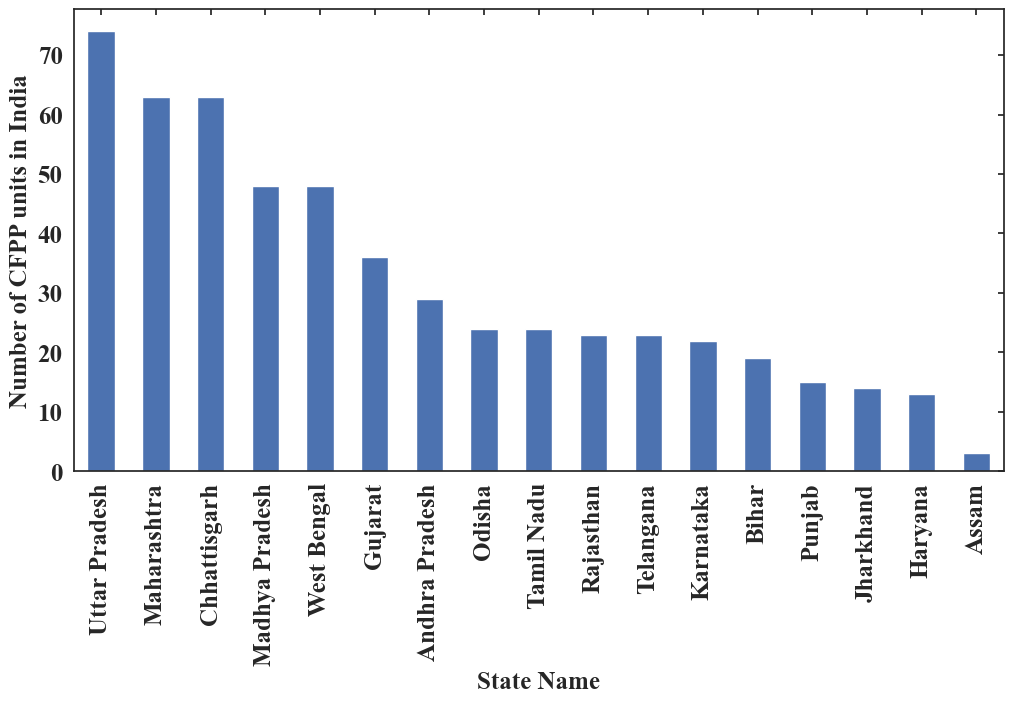

In [174]:
#set standard plot parameters
plotparams() 

#group by Unit ID and plot 
coal_savings_df.groupby(['State']).count().sort_values(by='Unit ID', ascending=False)['Unit ID'].plot(kind='bar',figsize=(12,6))

#set labels
plt.ylabel('Number of CFPP units in India',fontsize=fs,fontweight='bold')
plt.xlabel('State Name',fontsize=fs,fontweight='bold')

#save plot
plt.savefig('figures/figures/States_Units',bbox_inches='tight',dpi=1400)

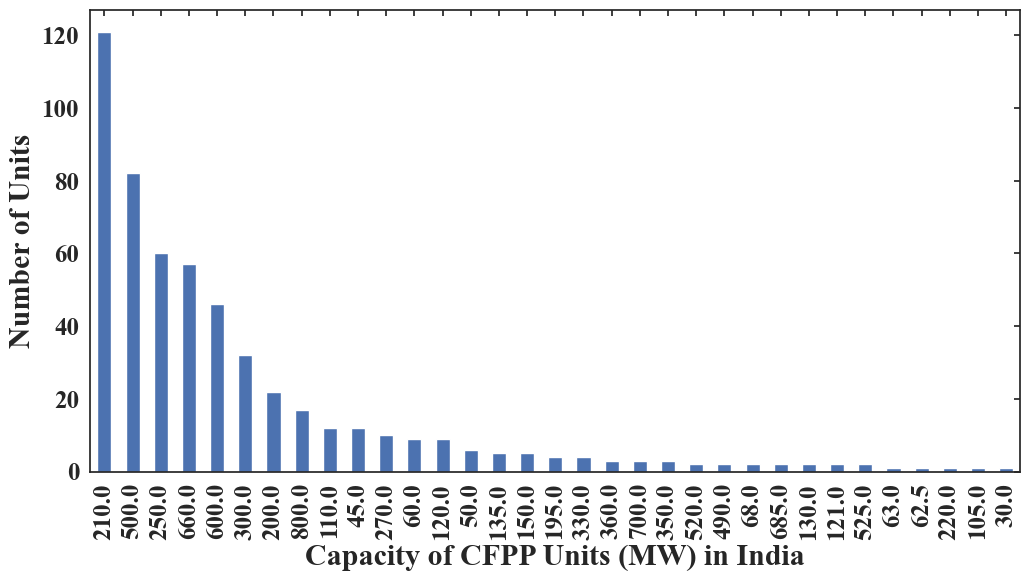

In [175]:
#set standard plot parameters
plotparams()

#group by capacity and plot with labels
coal_savings_df.groupby(['Capacity']).count().sort_values(by='Unit ID', ascending=False)['Unit ID'].plot(kind='bar',figsize=(12,6))
plt.xlabel('Capacity of CFPP Units (MW) in India')
plt.ylabel('Number of Units')

#save figure
plt.savefig('figures/figures/States_UnitCapacity',bbox_inches='tight')


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/431509444.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  coal_savings_df.groupby(['State']).sum().sort_values(by='Capacity', ascending=False)['Capacity'].plot(kind='bar',figsize=(12,6))


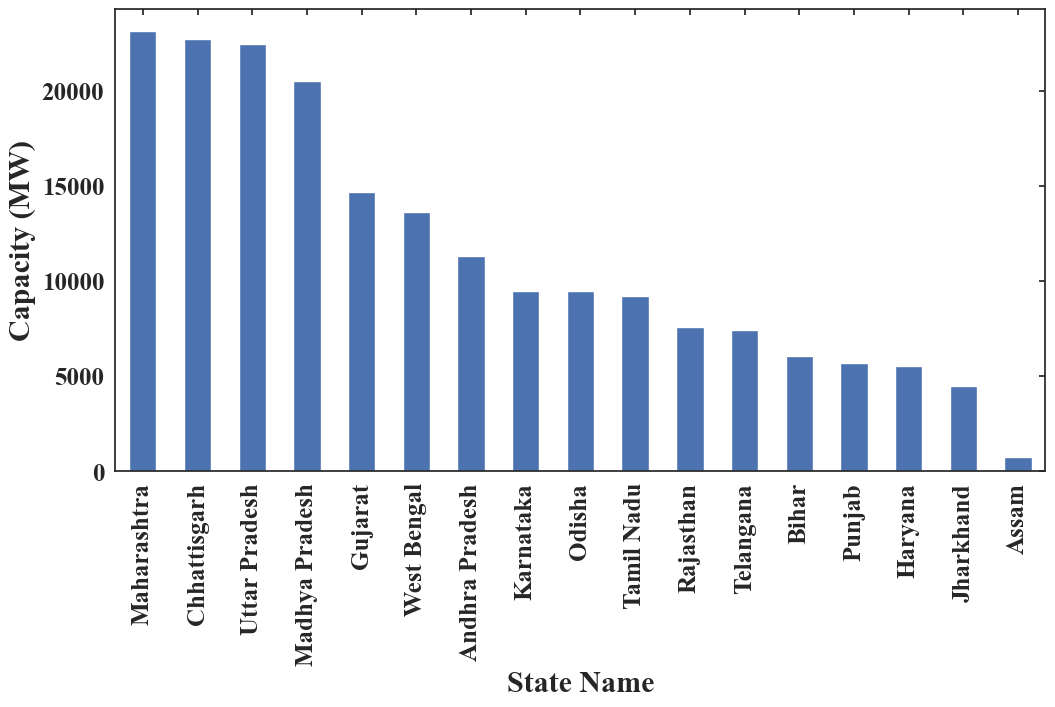

In [176]:
#set standard plot parameters
plotparams()

#plot the group by state capacity 
coal_savings_df.groupby(['State']).sum().sort_values(by='Capacity', ascending=False)['Capacity'].plot(kind='bar',figsize=(12,6))
plt.ylabel('Capacity (MW)',fontweight='bold')
plt.xlabel('State Name',fontweight='bold')

#save figure
plt.savefig('figures/figures/States_TotalCapacity',bbox_inches='tight')

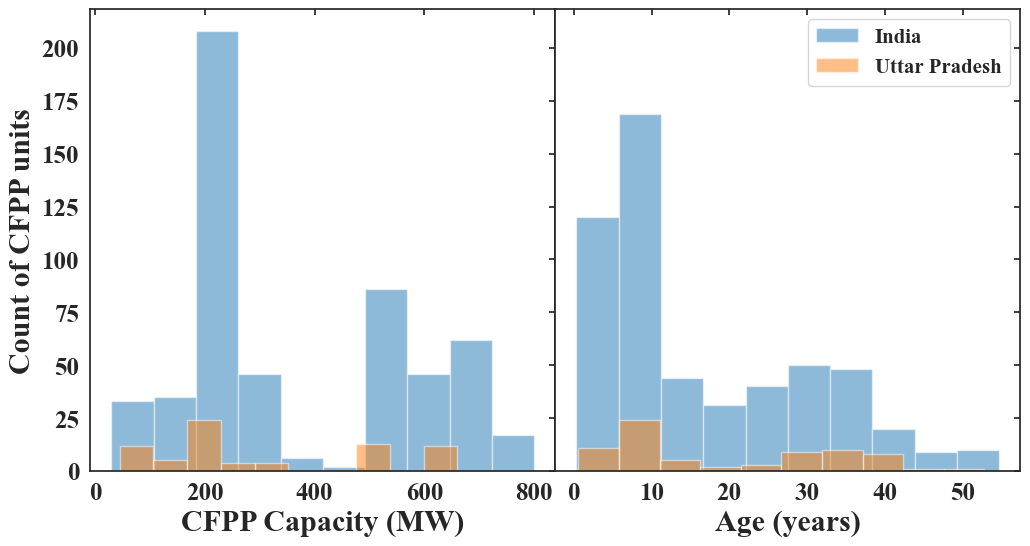

In [177]:
sns.set(style="white")
plotparams()

fig = plt.figure(figsize = (12,6))
gs = fig.add_gridspec(1,2, wspace=0)
(ax1,ax2) = gs.subplots( sharey=True)

ax1.hist(coal_savings_df.Capacity,label='India',alpha=0.5,color='tab:blue')
ax1.hist(coal_savings_df[coal_savings_df['State']=='Uttar Pradesh'].Capacity,label = 'Uttar Pradesh',alpha=0.5,color='tab:orange')
ax1.set_xlabel('CFPP Capacity (MW)')
ax1.set_ylabel('Count of CFPP units')

ax1.tick_params(axis='x')
ax1.tick_params(axis='y')


ax2.hist(coal_savings_df.Age,label='India',alpha=0.5,color='tab:blue')
ax2.hist(coal_savings_df[coal_savings_df['State']=='Uttar Pradesh'].Age,label = 'Uttar Pradesh',alpha=0.5,color='tab:orange')
ax2.set_xlabel('Age (years)')

ax2.legend(prop=font)

#save figure
plt.savefig('figures/figures/Histogram_Units',dpi=1400)

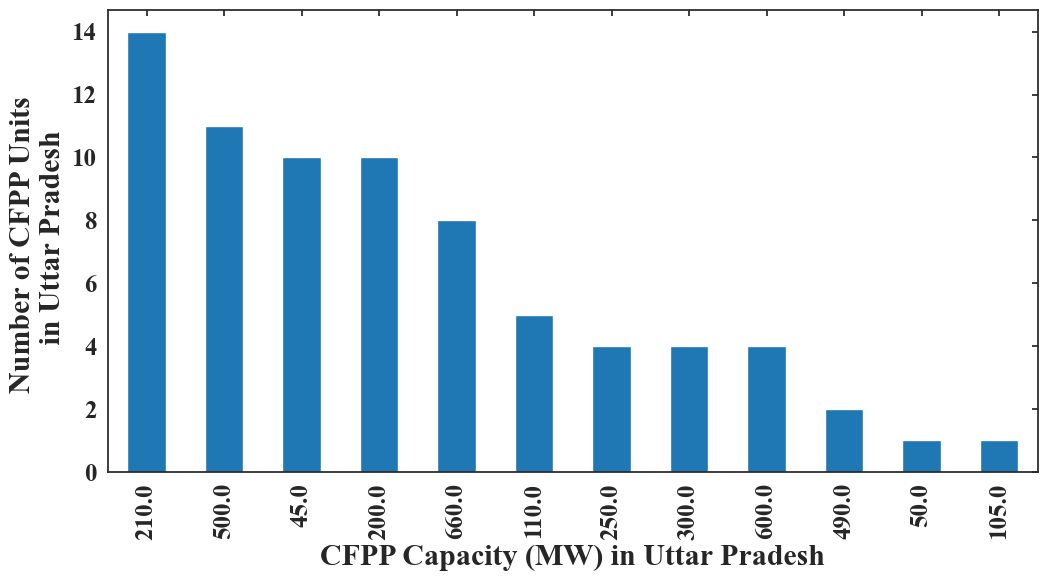

In [178]:
plotparams()

coal_savings_df[coal_savings_df['State']=='Uttar Pradesh'].groupby('Capacity').count().sort_values(by='Unit ID',ascending=False)['Unit ID'].plot(kind='bar',figsize=(12,6),color='tab:blue')
plt.xlabel('CFPP Capacity (MW) in Uttar Pradesh')
plt.ylabel('Number of CFPP Units \n in Uttar Pradesh')

plt.savefig('figures/figures/UP_CapacityUnits',bbox_inches='tight')

In [179]:
#printing metrics
coal_savings_df[(coal_savings_df['State']=='Uttar Pradesh')]['Capacity'].sum()
coal_savings_df[ (coal_savings_df['Plant status'] == 'Operational')]['Capacity'].sum()
print('total capacity in dataset (MW): ', coal_savings_df['Capacity'].sum())
print('UP coal capacity (MW): ', coal_savings_df[(coal_savings_df['State']=='Uttar Pradesh')]['Capacity'].sum())

total capacity in dataset (MW):  194023.5
UP coal capacity (MW):  22455.0


## 2.1: Maps 

In [180]:
#read in the shapefiles
fp = r'India_shape/India_Survey_of_India/STATE_BOUNDARY.shp'
map_df = gpd.read_file(fp)
map_df.head()


STATE  State_LGD    Shape_Leng    Shape_Area  \
0  ANDAMAN & NICOBAR         35  5.824763e+06  7.837276e+09   
1     ANDHRA PRADESH         28  5.334647e+06  1.599742e+11   
2  ARUN>CHAL PRADESH         12  2.618522e+06  7.933917e+10   
3              ASSAM         18  3.228020e+06  7.554956e+10   
4              BIH>R         10  2.980745e+06  9.061637e+10   

                                            geometry  
0  MULTIPOLYGON (((5575271.419 2199389.821, 55752...  
1  POLYGON ((4492847.023 3473537.880, 4492846.045...  
2  POLYGON ((5485437.255 4371711.152, 5485433.871...  
3  POLYGON ((5310055.311 4167338.817, 5310055.270...  
4  POLYGON ((4792175.926 4298744.812, 4792192.396...

In [181]:
#DATA CLEANING 
#make sure the state names are consistent 
map_df['STATE'] = [map_df.loc[i,'STATE'].replace('|','i').replace('& ','').replace(' and ','').replace('>','A').replace(' ','_').lower() for i in np.arange(len(map_df))]

#initialize capacity of coal per state in CEEW dataset with zeros
map_df['Capacity'] = np.zeros(len(map_df))

#state names of the coal_savings_df - CEEW dataset
coal_savings_df['StateName'] = [coal_savings_df.loc[i,'State'].lower().replace('& ','').replace(' ','_') for i in coal_savings_df.index]

#looking at the unique names in the gov map
print('Gov map: ',map_df.STATE.unique())

#looking at the unique names in the CEEW states
print('CEEW states: ', coal_savings_df['StateName'].unique())

#create disputed territories data subset
disputed_territories_data=map_df[['disputed' in map_df.loc[i,'STATE'] for i in np.arange(len(map_df))]]

Gov map:  ['andaman_nicobar' 'andhra_pradesh' 'arunachal_pradesh' 'assam' 'bihar'
 'chandigarh' 'chhattisgarh' 'dadra_nagar_haveli_daman_diu' 'delhi'
 'disputed_(madhya_pradesh_gujarat)' 'disputed_(madhya_pradesh_rajasthan)'
 'disputed_(rajathan_gujarat)' 'disputed_(west_bengal_,_bihar_jharkhand)'
 'goa' 'gujarat' 'haryana' 'himachal_pradesh' 'jammu_and_kashmir'
 'jharkhand' 'karnataka' 'kerala' 'ladakh' 'lakshadweep' 'madhya_pradesh'
 'maharashtra' 'manipur' 'meghalaya' 'mizoram' 'nagaland' 'odisha'
 'puducherry' 'punjab' 'rajasthan' 'sikkim' 'tamil_nadu' 'telangana'
 'tripura' 'uttarakhand' 'uttar_pradesh' 'west_bengal']
CEEW states:  ['odisha' 'madhya_pradesh' 'telangana' 'chhattisgarh' 'karnataka'
 'gujarat' 'andhra_pradesh' 'uttar_pradesh' 'bihar' 'rajasthan'
 'maharashtra' 'punjab' 'haryana' 'west_bengal' 'tamil_nadu' 'jharkhand'
 'assam']


In [182]:
for i in np.arange(len(map_df)):
    #if the map state is in the same list as the state names in ceew coal savings
    state_name = map_df.loc[i,'STATE']
    if state_name in coal_savings_df['StateName'].unique():
        #make the coal capacity of that state equal to the same as ceew data
        map_df.loc[i,'Capacity'] = coal_savings_df.groupby(by='StateName').sum()['Capacity'][state_name]

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3722408695.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  map_df.loc[i,'Capacity'] = coal_savings_df.groupby(by='StateName').sum()['Capacity'][state_name]
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3722408695.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  map_df.loc[i,'Capacity'] = coal_savings_df.groupby(by='StateName').sum()['Capacity'][state_name]
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3722408695.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecat

In [183]:
#check map_df
map_df

STATE  State_LGD    Shape_Leng  \
0                            andaman_nicobar         35  5.824763e+06   
1                             andhra_pradesh         28  5.334647e+06   
2                          arunachal_pradesh         12  2.618522e+06   
3                                      assam         18  3.228020e+06   
4                                      bihar         10  2.980745e+06   
5                                 chandigarh          4  6.211308e+04   
6                               chhattisgarh         22  3.321743e+06   
7               dadra_nagar_haveli_daman_diu         38  3.215824e+05   
8                                      delhi          7  2.348592e+05   
9          disputed_(madhya_pradesh_gujarat)          0  1.806306e+04   
10       disputed_(madhya_pradesh_rajasthan)          0  4.384445e+04   
11               disputed_(rajathan_gujarat)          0  6.995392e+04   
12  disputed_(west_bengal_,_bihar_jharkhand)          0  1.951538e+04   
13                                       goa         30  4.081664e+05   
14                                   gujarat         24  5.255585e+06   
15                                   haryana          6  2.554135e+06   
16                          himachal_pradesh          2  1.690413e+06   
17                         jammu_and_kashmir          1  1.460878e+06   
18                                 jharkhand         20  3.027574e+06   
19                                 karnataka         29  4.653505e+06   
20                                    kerala         32  1.869642e+06   
21                                    ladakh         37  3.051893e+06   
22                               lakshadweep         31  1.443223e+05   
23                            madhya_pradesh         23  7.367387e+06   
24                               maharashtra         27  5.531548e+06   
25                                   manipur         14  9.084821e+05   
26                                 meghalaya         17  1.294186e+06   
27                                   mizoram         15  1.181275e+06   
28                                  nagaland         13  9.972523e+05   
29                                    odisha         21  3.641881e+06   
30                                puducherry         34  5.472292e+05   
31                                    punjab          3  1.896601e+06   
32                                 rajasthan          8  5.421813e+06   
33                                    sikkim         11  4.665810e+05   
34                                tamil_nadu         33  3.650797e+06   
35                                 telangana         36  2.489986e+06   
36                                   tripura         16  1.000978e+06   
37                               uttarakhand          5  1.660954e+06   
38                             uttar_pradesh          9  6.169515e+06   
39                               west_bengal         19  5.962126e+06   

      Shape_Area                                           geometry  Capacity  
0   7.837276e+09  MULTIPOLYGON (((5575271.419 2199389.821, 55752...       0.0  
1   1.599742e+11  POLYGON ((4492847.023 3473537.880, 4492846.045...   11290.0  
2   7.933917e+10  POLYGON ((5485437.255 4371711.152, 5485433.871...       0.0  
3   7.554956e+10  POLYGON ((5310055.311 4167338.817, 5310055.270...     750.0  
4   9.061637e+10  POLYGON ((4792175.926 4298744.812, 4792192.396...    6040.0  
5   1.118674e+08  POLYGON ((3694950.413 4743456.293, 3695003.147...       0.0  
6   1.303554e+11  POLYGON ((4333887.202 4014427.315, 4334390.759...   22723.0  
7   5.797731e+08  MULTIPOLYGON (((3278305.843 3619549.074, 32784...       0.0  
8   1.437689e+09  POLYGON ((3721508.765 4532652.788, 3721586.729...       0.0  
9   4.222065e+06  MULTIPOLYGON (((3414027.156 3832272.975, 34140...       0.0  
10  1.525304e+07  MULTIPOLYGON (((3469720.086 3925144.222, 34698...       0.0  
11  1.362572e+07  MULTIPOLYGON (((3371277.389 3688676.989, 33711...       0.0  
12  1

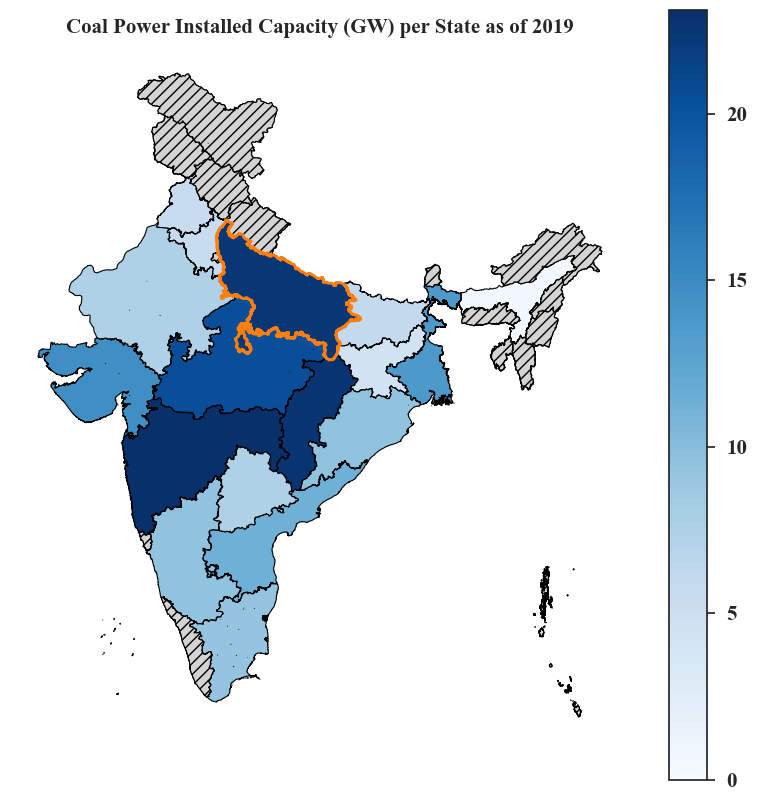

In [184]:
#plot the map
plotparams()

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Coal Power Installed Capacity (GW) per State as of 2019' ,font='Times New Roman')
sns.set(style='white')

#plot UP outline in a different color
UP_df = map_df[map_df['STATE']=='uttar_pradesh']
UP_df.boundary.plot(linewidth=2, ax=ax, edgecolor='tab:orange',markersize=[39.739192, -104.990337])

# plot the figure
#change to GW
map_df['CapacityGW'] = map_df['Capacity']/1000
ax = map_df.plot(column='CapacityGW',cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0', legend=True, markersize=[39.739192, -104.990337])

# plots for if Capacity is 0 
null_df = map_df[map_df['Capacity']==0]
null_df.plot(color='lightgray',linewidth=0.8, ax=ax, edgecolor='0', legend=True, markersize=[39.739192, -104.990337],hatch='///')


# Plot the disputed territories data
disputed_territories_data.plot(ax=ax, color='black',linewidth=2, edgecolor='black',hatch='///')

#axis parameters
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=15)
plt.setp(cb_ax.yaxis.get_ticklabels(), fontsize=15, fontname="Times New Roman")


# Save map
fig.savefig('figures/figures/Coal_map')
fig.savefig('figures/figures/Coal_map.svg',format='svg')

# Show the map
plt.show()



# 3. Processing TES Optimization Results 

## 3.1: Set directory and sort results into accessible format (dictionary)

The directory name (dir) changes depending on the scenario analyzed.

### Define functions

In [185]:
# function to make the min hours sensitivity dict from a given directory and the index number

def create_sensitivity_dict(dir):
    results_dir = dir+'results/'
    #results files
    files = [item.replace('.csv','') for item in os.listdir(results_dir)]

    #initialize scenario dictionary 
    scenarios_dict = {}

    T=168

    #for each file in the results folder
    for file in files:

    #check if it's a results file
        if 'results' in file:
            #read the file and set to Dataframe 
            locals()[file] = pd.read_csv(results_dir+file + '.csv').T.reset_index(drop=True)
            #rename to "results"
            results = locals()[file]
            #store filename here 
            filename_n = file + '.csv'
            #print results
        
            #initialize a dictionary to put results in  
            new_dict = dict()
        
            #iterate over the columns of results df
            for j in np.arange(len(results.T)):
                #print(j)
                #if this is a filename
                if 'powerTurbine_t' in results.iloc[0,j] :
                    new_dict[results.iloc[0,j]] = 0
                    #null column
                    results[j][1] = 0
                    #print(j)
                elif pd.isnull(results[j][1]) :
                    new_dict[results.iloc[0,j]] = 0
                    #null column
                    results[j][1] = 0
                    #print(j)
                elif '.csv' in results[j][1]:
                    #set in new dictionary
                    new_dict[results.iloc[0,j]] = results[j][1]
                    
                    #null column
                    results[j][1] = 0

                elif 'LCOE_dict' in results.iloc[0,j]:
                    new_dict[results.iloc[0,j]] = 0
                    #null column
                    results[j][1] = 0
                    #print(j)
                
                else:
                    #populate the dictionary 
                    new_dict[results.iloc[0,j]] = json.loads(results[j][1].replace(";;","").replace(";",",").replace("Any",""))
                    #reshape for these rep weeks
                if type(new_dict[results.iloc[0,j]]) == list: 

                    #calculate N (number of rep weeks)
                    N = int(len(new_dict[results.iloc[0,j]])/T)
                    
                    if len(new_dict[results.iloc[0,j]])==T*N :
                        #print('N:', N)
                        #print(results.iloc[0,j])
                        new_dict[results.iloc[0,j]] = pd.DataFrame(np.array(new_dict[results.iloc[0,j]]).reshape(T,N))
                
        
            #pull values from the dictionary 
            scenario = new_dict['fname'][55:] #file 

            #dict of dicts
            scenarios_dict[scenario] = new_dict

            #CHANGE AS NEEDED
            #dir = 'RESULTS/UttarPradesh_lowHX_2030/'
            #dir = 'RESULTS/UttarPradesh/'

            
    return scenarios_dict
            

In [186]:
def create_UP_min_hours_dict(scenarios_dict,dir,dir_index):
     
   profitable_scenario_keys = [key for key in scenarios_dict.keys() if scenarios_dict[key]['objective_value'] < 0]

   sensitivity_keys = [round(float(pd.read_csv(dir+scenarios_dict[key]['fname'][dir_index:])['min_hours'][0]),1) for key in scenarios_dict.keys()]
     
     #initialize dict
   min_hours_dict = {}
     #set the keys to the unique values in the sensitivity keys
     
   min_hours_keys = pd.Series(sensitivity_keys).unique()

        #for each key in the tax credit keys, make a dictionary 
   for sense_key in min_hours_keys:
      min_hours_dict[sense_key] = {}

                # for each key in the scenarios dictionary key, where each key is the same as the parameters input file
      for scen_key in scenarios_dict.keys(): 
            #read the parameters file associated with the scenario
         params = pd.read_csv(dir+scenarios_dict[scen_key]['fname'][dir_index:])

            #get the groupID if Uttar Pradesh
         if 'UttarPradesh' in dir: 
            GroupID = params['Group_ID'][0]

            #add the groupID to scenario dictionary 
            scenarios_dict[scen_key]['Group ID']=GroupID
            
            #if the tax credit is the same as the tax credit key, then re-order in the dicitonary sorted by tax credit sensitivity 
         if round(float(params['min_hours'][0]),1) == sense_key:
            min_hours_dict[sense_key][scen_key]=scenarios_dict[scen_key]

   return min_hours_dict

## 3.2: Read the coal unit clusters input data and merge with the TES optimization results

The UPclusters.csv file contains the clusters of coal plants in UP generated by the CEEW data and aspen data. It is linked to the TES results by the GroupID

In [187]:
#set directory and index
UP_dir = 'RESULTS/UttarPradesh/'
UP_dir_index = 44

UP_scenarios_dict = create_sensitivity_dict(UP_dir)
UP_min_hours_dict = create_UP_min_hours_dict(UP_scenarios_dict,UP_dir,UP_dir_index)

#read in the UPclusters which has the CEEW data, Aspen data, and Group IDs
UPclusters_df  = pd.read_csv(UP_dir+'UPclusters.csv') 
UPclusters_df.head()

Age grouping  Capacity        Age  Avg daily generation  Unnamed: 9  \
0     0-5 years     500.0   3.175907              3.897856         NaN   
1     0-5 years     600.0   4.550308              8.392746         NaN   
2     0-5 years     660.0   3.300479              6.302793    8.655455   
3   10-15 years     210.0  13.757700              3.277626         NaN   
4   10-15 years     300.0  10.253251              3.877207         NaN   

   Actual avg PLF  Target PLF  PLF Diff  Coeff of variation  \
0        0.324821      0.8500  0.525179                0.15   
1        0.582830      0.8500  0.267170                0.15   
2        0.397904      0.8500  0.452096                0.15   
3        0.650323      0.8000  0.149677                0.15   
4        0.538501      0.4925 -0.046001                0.25   

   Daily actual coal consumption - calc (tons/MW)  ...   Actual-cons  \
0                                        5.465556  ...  2.540402e+06   
1                                        8.578046  ...  5.469917e+06   
2                                        4.985740  ...  4.107804e+06   
3                                       11.839822  ...  2.136171e+06   
4                                        8.785639  ...  2.526945e+06   

   Reallocated cons     Actual age  Reallocated age  Actual capacity  \
0       6647783.700   91661.997154    239863.227926    -1.173060e+06   
1       7977340.440  285897.284134    412399.329117    -3.030956e+06   
2       8775074.484  151947.073533    329038.586267    -2.503810e+06   
3               NaN  333696.371969              NaN    -4.142886e+05   
4       2311082.451  294358.332743    269213.023860    -7.001073e+05   

   Reallocated capacity    Actual aux  Reallocated aux  \
0          -3069690.000  1.111148e+06     2.907678e+06   
1          -4420353.600  2.212648e+06     3.226931e+06   
2          -5348627.856  1.329268e+06     2.724101e+06   
3                   NaN  9.608779e+05              NaN   
4           -640301.220  1.054905e+06     9.647906e+05   

                                             Unit ID  Group ID  
0                                 ['UNCHAHAR STPS6']  Group186  
1                     ['ANPARA TPS7', 'ANPARA TPS6']  Group187  
2  ['TANDA STPS5', 'MEJA STPP1', 'BARA TPP3', 'BA...  Group188  
3  ['PARICHHA TPS3', 'PARICHHA TPS4', 'UNCHAHAR S...  Group189  
4                                 ['ROSA TPP PH-I1']  Group190  

[5 rows x 81 columns]

In [188]:

#get the df of results for one hours minimum (2 hours)
df = pd.DataFrame(UP_min_hours_dict[2]).T.reset_index()

#rename all the columnsn in the results df to results_{name}
for col_name in df.columns:
    df.rename(columns={col_name:'results_'+col_name},inplace=True)

#change groupID to match
df['Group ID'] = ['Group'+str(int(df['results_'+'Group ID'][i])) for i in np.arange(len(df))]

#merge with UP clusters df (CEEW grouping)
merged_df = df.merge(UPclusters_df, on='Group ID',indicator=True) # each column name points to the parameters file, which has the group ID
merged_df.head()

results_index results_Q_TES_heater_peak results_q_turbind_dispatch  \
0  Group196_2hrs.csv                199.413985                        0.0   
1  Group195_2hrs.csv                199.413985                        0.0   
2  Group189_2hrs.csv                199.413985                        0.0   
3  Group188_2hrs.csv                626.729667                        0.0   
4  Group193_2hrs.csv                474.795203                        0.0   

  results_subsidy results_TES_LCOE_Capex results_lifetime results_Q_ind  \
0             0.0               0.078696             23.0           0.0   
1             0.0               0.074841             30.0           0.0   
2             0.0               0.079522             37.0           0.0   
3             0.0               0.069882             47.0           0.0   
4             0.0               0.072871             35.0           0.0   

  results_CAPEX_TES_HEN results_P_coldpump results_TES_LCOE_Charge  ...  \
0           2278.851168          90.542034                0.065287  ...   
1           2278.851168          90.542034                0.065545  ...   
2           2278.851168          90.542034                0.064981  ...   
3           7126.938519         284.560679                0.064379  ...   
4           4589.880273         215.576272                 0.06543  ...   

    Actual-cons Reallocated cons    Actual age Reallocated age  \
0  1.651515e+06              NaN  5.112078e+05             NaN   
1  2.283239e+06              NaN  5.436731e+05             NaN   
2  2.136171e+06              NaN  3.336964e+05             NaN   
3  4.107804e+06      8775074.484  1.519471e+05    3.290386e+05   
4  7.172535e+06      5865691.500  1.249812e+06    1.022095e+06   

  Actual capacity Reallocated capacity    Actual aux Reallocated aux  \
0   -3.202945e+05                  NaN  4.775747e+05             NaN   
1   -4.428110e+05                  NaN  9.986674e+05             NaN   
2   -4.142886e+05                  NaN  9.608779e+05             NaN   
3   -2.503810e+06         -5348627.856  1.329268e+06    2.724101e+06   
4   -3.312000e+06         -2708550.000  2.064495e+06    1.688342e+06   

                                             Unit ID _merge  
0  ['DADRI (NCTPP)1', 'DADRI (NCTPP)2', 'DADRI (N...   both  
1               ['UNCHAHAR STPS3', 'UNCHAHAR STPS4']   both  
2  ['PARICHHA TPS3', 'PARICHHA TPS4', 'UNCHAHAR S...   both  
3  ['TANDA STPS5', 'MEJA STPP1', 'BARA TPP3', 'BA...   both  
4                                   ['RIHAND STPS3']   both  

[5 rows x 193 columns]

## 3.3 Map to the UP-only coal savings df by the Unit IDs associated with each group

In [189]:
#map this to the UP-only coal_savings df by Unit IDs associated with each group
coal_savings_dict = pd.read_csv(UP_dir+'coal_savings_adjusted_df.csv').to_dict()

In [190]:
#put the column names in coal_savings columns, rename to results_{col_name} 
# and prefill with the unit ID
for col_name in merged_df.columns:
    coal_savings_dict[col_name] = dict(coal_savings_dict['Unit ID'])
    #print(col_name)

#for each row in coal savings (541)
for i in np.arange(len(coal_savings_dict['Unit ID'])):
    #for each row in merged df 
    for m in np.arange(len(merged_df)): 
        #if the coal saving unit ID is found in any of the merged df units ID list
        if coal_savings_dict['Unit ID'][i] in merged_df['Unit ID'][m]:
            #save the merged df values to coal_savings columns 
            for col_name in merged_df.columns.drop('Unit ID'):
            #loop through the columns
                coal_savings_dict[col_name][i] = merged_df.loc[m,col_name]

In [191]:

#create dataframe
df = pd.DataFrame(coal_savings_dict)

#take only UP 
UP_df = df[df.State=='Uttar Pradesh'].reset_index(drop=True)

#save to excel
UP_df.to_excel('data/UP_CEEW.xlsx',index=False)

# 4. Link the lat-long data from Global Energy Monitor to CEEW Unit IDs

Notes on this section:

- plot all of GEM plants in India by lat-long
- filter: country:India, state:Uttar Pradesh, 
- decided against filtering by status (operational, retired, cancelled) due to inconsistencies with the CEEW dataset
- some of the names of the units were renamed in the filtered GEM file in order to align with the CEEW dataset unit identification system

In [192]:
#read in the excel file
GEM_df = pd.read_excel('data/Global-Coal-Plant-Tracker-January-2023.xlsx',sheet_name='Units')

In [193]:
## uncomment below for the filtering 
#GEM_UP_df = GEM_df[(GEM_df['Country']=='India') & (GEM_df['Subnational unit (province, state)']== 'Uttar Pradesh')].reset_index(drop=True)
#GEM_UP_df.to_excel('GEM_UP.xlsx') #edited
GEM_UP_df = pd.read_excel('data/GEM_UP.xlsx')

#add a column for remainng emissions
GEM_UP_df['remaining emissions'] = GEM_UP_df['Annual CO2 (million tonnes / annum)']*GEM_UP_df['Remaining plant lifetime (years)'] 
GEM_UP_df.head()


Unnamed: 0 Tracker ID TrackerLOC ParentID  \
0           0    G100146    L102609  Q200283   
1           1    G100147    L102609  Q200283   
2           2    G100148    L102609  Q200283   
3           3    G100253    L102610  P101538   
4           4    G100254    L102610  P101538   

                                           Wiki page Country  \
0  https://www.gem.wiki/Amauli_Fatehpur_power_sta...   India   
1  https://www.gem.wiki/Amauli_Fatehpur_power_sta...   India   
2  https://www.gem.wiki/Amauli_Fatehpur_power_sta...   India   
3          https://www.gem.wiki/Anpara_power_station   India   
4          https://www.gem.wiki/Anpara_power_station   India   

  Subnational unit (province, state)    Unit                          Plant  \
0                      Uttar Pradesh  Unit 1  Amauli Fatehpur power station   
1                      Uttar Pradesh  Unit 2  Amauli Fatehpur power station   
2                      Uttar Pradesh  Unit 3  Amauli Fatehpur power station   
3                      Uttar Pradesh   UNIT1           Anpara power station   
4                      Uttar Pradesh   UNIT2           Anpara power station   

   Chinese Name  ... Captive industry use Captive residential use  \
0           NaN  ...                  NaN                     NaN   
1           NaN  ...                  NaN                     NaN   
2           NaN  ...                  NaN                     NaN   
3           NaN  ...                  NaN                     NaN   
4           NaN  ...                  NaN                     NaN   

  Alternate Fuel  Heat rate (Btu per kWh) Emission factor (kg of CO2 per TJ)  \
0            NaN                     8605                              96100   
1            NaN                     8605                              96100   
2            NaN                     8605                              96100   
3            NaN                    12618                              94600   
4            NaN                    12618                              94600   

   Capacity factor  Annual CO2 (million tonnes / annum)  Lifetime CO2  \
0             0.53                                  2.7         106.9   
1             0.53                                  2.7         106.9   
2             0.53                                  2.7         106.9   
3             0.53                                  1.2           4.9   
4             0.53                                  1.2           6.1   

  Remaining plant lifetime (years) remaining emissions  
0                               40               108.0  
1                               40               108.0  
2                               40               108.0  
3                                4                 4.8  
4                                5                 6.0  

[5 rows x 42 columns]

## 4.1 Link by fuzzy analysis of Unit ID and Plant Names

Will need to check these when doing the check for every state 

In [194]:
#Change the names so they are lowercase etc. 

#UP results and CEEW data
list_1 = [str(UP_df['Unit ID'][i]).lower().replace('tps','').replace('tpp','').replace('project','').replace('ipp','').replace(' ','').replace('(nc)','') for i in np.arange(len(UP_df))]
#longer list of all GEM data 
list_2 = [str(GEM_UP_df['Plant'][i]).lower().replace('power','').replace('project','').replace('thermal','').replace('plant','').replace('station','').replace(' ','').replace('national','').replace('capital','') + str(GEM_UP_df['Unit'][i]).lower().replace('phase','').replace('unit','').replace(' ','').replace('stage','').replace(',','').replace('i','').replace('ii','') for i in np.arange(len(GEM_UP_df))]

In [195]:
#get the index in the filtered GEM dataset of the matching name

args = []
for i in np.arange(len(list_1)):
    scores = []
    for j in np.arange(len(list_2)):
        #scores.append(fuzz.token_sort_ratio(list_1[i],list_2[j]))
        scores.append(fuzz.ratio(list_1[i],list_2[j]))
        #scores.append(adist(list_1[i],list_2[j]))
    #print(len(scores))
    args.append(np.argmax(scores))

names = []       
for arg in args: 
    names.append(list_2[arg])


In [196]:
#check the results
pd.DataFrame({'CEEW name': list_1,'GEM name': names ,'GEM arg': args}).to_excel('data/check.xlsx')

In [197]:
#put respective arguments in the UP df
latitudes = [GEM_UP_df.loc[arg,'Latitude'] for arg in args]
longitudes = [GEM_UP_df.loc[arg,'Longitude'] for arg in args]
remaining_emissions = [GEM_UP_df.loc[arg,'remaining emissions'] for arg in args]


UP_df['Latitude']=latitudes
UP_df['Longitude']=longitudes
UP_df['results_remaining_emissions_MCO2'] = remaining_emissions

## 4.2 Show the map 

In [198]:
map3 = flm.Map(location=[20.5937,78.9629], tiles='CartoDB positron',zoom_start=4) 

In [199]:
for i in np.arange(len(UP_df)):
    circle = flm.CircleMarker(
        [UP_df.loc[i,'Latitude'], UP_df.loc[i,'Longitude']],
        radius = UP_df.loc[i,'Capacity']/50,
        popup = UP_df.loc[i,'Plant name'],
        color = 'black',
        weight=1.5,
        fill_color = "crimson",
        fill_opacity = 0.5

    )
    circle.add_to(map3)


In [200]:
map3

In [201]:
#save map 3
map3.save('India_shape/maps/CEEW_UP.html')

In [202]:
#grab indices of the operating points
GEM_UP_operating_df = GEM_UP_df[GEM_UP_df['Status']=='operating']
GEM_UP_operating_df.index

Int64Index([  3,   4,   5,   6,   7,   8,   9,  10,  11,  16,  17,  18,  24,
             25,  30,  31,  32,  33,  39,  40,  41,  42,  43,  44,  53,  57,
             58,  59,  67,  68,  72,  73,  74,  75,  76,  80,  81,  82,  83,
             87,  88,  89,  90,  91,  92,  98,  99, 100, 101, 105, 111, 112,
            113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
            126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 141, 142,
            143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 157],
           dtype='int64')

### Inconsistencies in GEM and CEEW operating units

In [203]:
#find all the indices of the "operating" units (as per GEM) that were excluded from the CEEW data 
excluded_args = [GEM_UP_operating_df.index[i] for i in np.arange(len(GEM_UP_operating_df.index)) if GEM_UP_operating_df.index[i] not in args]
print('Where are the', len(GEM_UP_operating_df) - len(UP_df), 'units that are in the GEM set and not the CEEW UP set?')

Where are the 17 units that are in the GEM set and not the CEEW UP set?


In [204]:
map4 = flm.Map(location=[20.5937,78.9629], tiles='CartoDB positron',zoom_start=4) 

In [205]:
for arg in excluded_args:
    circle = flm.CircleMarker(
        [GEM_UP_df.loc[arg,'Latitude'], GEM_UP_df.loc[arg,'Longitude']],
        radius = GEM_UP_df.loc[arg,'Capacity (MW)']/50,
        popup = GEM_UP_df.loc[arg,'Unit']+GEM_UP_df.loc[arg,'Plant'],
        color = 'blue',
        weight=1.5,
        #fill_color = "nofil",
        #fill_opacity = 0.5

    )
    circle.add_to(map4)

In [206]:
map4

# 5: Plotting fleet results

In [207]:
UP_df.reset_index(inplace=True)

## 5.1 Making a UP df for each sensitivity 


Text(0.5, 0, 'results_objective_value')

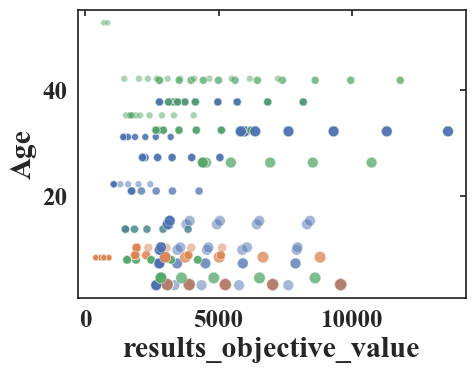

In [208]:
plotparams()

for min_hour in UP_min_hours_dict.keys():
    df = pd.DataFrame(UP_min_hours_dict[min_hour]).T.reset_index()

    #rename all the columnsn in the results df to results_{name}
    for col_name in df.columns:
        df.rename(columns={col_name:'results_'+col_name},inplace=True)

    #change groupID to match
    df['Group ID'] = ['Group'+str(int(df['results_'+'Group ID'][i])) for i in np.arange(len(df))]

    #merge with UP clusters df (CEEW grouping)
    merged_df = df.merge(UPclusters_df, on='Group ID',indicator=True) # each column name points to the parameters file, which has the group ID

    coal_savings_dict = pd.read_csv(UP_dir+'coal_savings_adjusted_df.csv').to_dict()
    merged_df.columns.drop('Unit ID')

#   put the column names in coal_savings columns, rename to results_{col_name} 
# and prefill with the unit ID
    for col_name in merged_df.columns:
        coal_savings_dict[col_name] = dict(coal_savings_dict['Unit ID'])
    #print(col_name)

    #for each row in coal savings (541)
    for i in np.arange(len(coal_savings_dict['Unit ID'])):
    #for each row in merged df 
        for m in np.arange(len(merged_df)): 
        #if the coal saving unit ID is found in any of the merged df units ID list
            if coal_savings_dict['Unit ID'][i] in merged_df['Unit ID'][m]:
            #save the merged df values to coal_savings columns 
                for col_name in merged_df.columns.drop('Unit ID'):
            #loop through the columns
                    coal_savings_dict[col_name][i] = merged_df.loc[m,col_name]
    df = pd.DataFrame(coal_savings_dict)
    UP_df = df[df.State=='Uttar Pradesh'].reset_index(drop=True)

    #setting colors
    groupID_keys = UP_df['Group ID'].unique()
    viridis = mpl.colormaps['viridis'].resampled(len(groupID_keys))

    dict_map = {}
    for i in np.arange(len(viridis.colors)):
        dict_map[groupID_keys[i]] = viridis.colors[i]

    UP_df['colormap'] = UP_df['Group ID'].map(dict_map)
    
    #plotting
    UP_df.sort_values('Age',inplace=True)
    UP_df.reset_index(inplace=True)


    g=sns.scatterplot(data = UP_df, x='results_objective_value',y='Age',hue='Ownership',alpha=0.5,size=UP_df['Capacity'],legend=False)
    
plt.ylabel('Age')
plt.xlabel("results_objective_value")


In [209]:
#some metrics
print('Age range:',UP_df.Age.min() , ' to ', UP_df.Age.max())
print('Efficiency range:',UP_df.results_steam_eff.min() , ' to ', UP_df.results_steam_eff.max())
print('Capacity range:',UP_df.Capacity.min() , ' to ', UP_df.Capacity.max())

Age range: 3.17590691307323  to  42.17659137577
Efficiency range: 0.401  to  0.415
Capacity range: 45.0  to  660.0


# 5.2: Set Functions 

In [210]:
def download_dfs(min_hours_dict,min_hours,path_data_download,dir_index,dir):
    #reads the results in "min_hours_dict" dictionary of "dir" (results dictionary), downloads data  to "path_data_download"

    # global durations_UP 
    global capex_MWh_list 
    global capex_charge_MW_list 
    global capex_discharge_MW_list
    global CRF_list 

    global names
    global profits 
    global npvs
    global group_age
    global group_cap

    durations_UP = []
    capex_MWh_list = []
    capex_charge_MW_list = []
    capex_discharge_MW_list = []
    CRF_list = [] 

    names = []
    dispatch_list = []

    profits = []
    npvs = []
    group_age = []
    group_cap = []
    energy_capacity_list = []

    df = pd.DataFrame(min_hours_dict[np.round(min_hours,1)]).T.reset_index()

    #rename all the columns in the results df to results_{name}
    for col_name in df.columns:
        df.rename(columns={col_name:'results_'+col_name},inplace=True)

    df.sort_values(by='results_tank_energy_max',inplace=True)

    df.reset_index(inplace=True)

    #set xticklabels
    xticklabels = []
    all_lcoe_df = pd.DataFrame()
    all_capex_df = pd.DataFrame()

    for i in np.arange(len(df)):   #set xtick labels as state 
        if True: 
            #set parameters file
            param_fname = dir+df['results_fname'][i][dir_index:]

            #set label, add to xticklabels
            
            if 'UttarPradesh' in path_data_download:
                label = 'Group'+str(int(df['results_Group ID'][i]))

            elif 'bottomup' in path_data_download:
                label = df['results_index'][i].replace('bayU5_2hrs_','').replace('.csv','').replace('_',' ')
                
            else:
                label=str(i)

            xticklabels.append(label)

            #read parameters file
            params_df = pd.read_csv(param_fname)

            TES_FOM = float(pd.read_csv(param_fname)['TES_FOM'][0])
        
            capex_df = pd.DataFrame({
                                    'Heat Exchanger':[df['results_cost_HX'][i]],
                                    'Tank Cost':[df['results_CAPEX_TES_storage'][i]],
                                    'Pumps':[df['results_CAPEX_TES_pumps'][i]],
                                    'Pipes and Valves':[df['results_CAPEX_TES_pipes_valves'][i]],
                                    'Charger':[df['results_CAPEX_TES_charger'][i]],
                                    'Industrial Heater':[df['results_CAPEX_TES_Ind_charger'][i]],
                                    'Upgrade Cost': [df['results_CAPEX_TES_upgrade_costs'][i]],
                                    })

            flowSalt_charge_t = df['results_flowSalt_charge_t'][i]
            cost_energy_t = df['results_cost_energy_t'][i]
            start_z_t = df['results_start_z_t'][i]
            Q_heater_t = df['results_q_heater_t'][i]
            powerOut_t = df['results_net_discharge_t'][i]

            w = df['results_weights'][i]
            N = len(w)
            T = float(params_df['T'][0])
            start_cost = float(params_df['start_cost'][0])*float(params_df['powerPeak'][0])
            deltaT_salt = float(params_df['T_hot'][0]) -  float(params_df['T_cold'][0])
            cp = float(params_df['cp'][0])
            beta = float(params_df['beta'][0])
            gbi_subsidy = float(params_df['gbi_subsidy'][0])
            steam_eff = float(params_df['steam_eff'][0])
            CRF = df['results_CRF'][i]
            lifetime = float(params_df['life'][0])

            #energy capacity (MWh_th)
            energy_capacity = df['results_tank_energy_max'][i] 
            energy_capacity_list = np.append(energy_capacity_list,energy_capacity)


            #power capacity (MW_e)
            power_capacity = df['results_powerPeak'][i]

            #power charging mwe
            charge_capacity = df['results_flowSalt_charge_peak'][i]*cp*deltaT_salt / beta

            #metrics for capex
            total_capex = df['results_TES_capex'][i] 

            #energy capex
            energy_capex = df['results_CAPEX_TES_storage'][i]

            #charging capex
            charge_capex = df['results_charger_cost'][i]+df['results_cost_coldpump'][i]

            #discharge capex
            discharge_capex = df['results_cost_HX'][i]+df['results_cost_hotpump'][i]+df['results_cost_coldpump'][i]+df['results_pipes_valves_cost'][i] + df['results_upgrade_cost'][i]*df['results_powerTurbine'][i]

            capex_MWh = energy_capex*1000/energy_capacity
            capex_dischargeMW = discharge_capex*1000/power_capacity
            capex_chargeMW = charge_capex*1000/charge_capacity


            #save 
            capex_MWh_list = np.append(capex_MWh_list,capex_MWh)
            capex_charge_MW_list = np.append(capex_charge_MW_list,capex_chargeMW)
            capex_discharge_MW_list = np.append(capex_discharge_MW_list,capex_dischargeMW)
            names = np.append(names, label)
            CRF_list = np.append(CRF_list,CRF)
            group_cap = np.append(group_cap,df['results_powerPeak'][i])
            group_age = np.append(group_age, lifetime)

            #annual generation 
            dispatch = df['results_TES_dispatch'][i] 
            #save to dispatch list
            dispatch_list = np.append(dispatch_list,dispatch)

            #start costs 
            lcoe_start = df['results_TES_startup_costs'][i] 

            #charging costs
            lcoe_charging = df['results_TES_charge_costs'][i] 

            #heater costs (industrial)
            lcoe_industrial_heat = df['results_TES_indheater_costs'][i]

            #revenue
            revenue = df['results_TES_revenue'][i] 

            #subsidy
            subsidy = 0

            #profits
            profit = df['results_objective_value'][i]
            profits = np.append(profits,df['results_objective_value'][i])

            #fixed O&M
            TES_fixed_operating = df['results_TES_fom_yr'][i]

            #annualized_capex = capex_df.T.sum()[0]*CRF #get it back to $1k MWh
            annualized_capex = df['results_TES_annualized_capex'][i]

           

            lcoe_df = pd.DataFrame({'Pipes and Valves':[df['results_CAPEX_TES_pipes_valves'][i]*-1*CRF],
                                    'Pumps': [df['results_CAPEX_TES_pumps'][i]*-1*CRF],
                                    'Charger': [df['results_CAPEX_TES_charger'][i]*-1*CRF],
                                    'Tank Cost':[df['results_CAPEX_TES_storage'][i]*-1*CRF],
                                    'Heat Exchanger':[df['results_cost_HX'][i]*-1*CRF],
                                    'Start-Up Costs':[lcoe_start*-1],
                                    'Charging Costs':[lcoe_charging*-1],
                                    'Industrial Electric Heater Costs':[lcoe_industrial_heat*-1],
                                    'Annualized Capital Cost':[annualized_capex*-1],
                                    'Revenue':[revenue],
                                    'Profits':[profit*-1],
                                    'Fixed O&M Cost':[TES_fixed_operating*-1]
                                    })*1000/dispatch #get it to $/MWh

            
            ## Simple Coal Plant Profits under same price profile
            dischargepowerPeak = float(params_df['powerPeak'][0])
            coal_FOM = float(params_df['coal_FOM'][0])*dischargepowerPeak
            emissions_rate = float(params_df['emissions_rate'][0])
            coal_fuel_cost = float(params_df['coal_fuel_cost'][0]) 
            coal_VOM = float(params_df['coal_VOM'][0]) 
            carbon_price = float(params_df['carbon_price'][0]) 

            #add labels
            lcoe_df['Name'] = label
            capex_df['Name'] = label

            #appending dfs
            all_lcoe_df = all_lcoe_df.append(lcoe_df)
            all_capex_df = all_capex_df.append(capex_df)


    #save disptach list
    dispatch_df = pd.DataFrame({'Name':names,'Dispatch':dispatch_list})
    dispatch_df.to_csv(path_data_download+'DISPATCH.csv')
    #save energy capacity list
    energy_capacity_df = pd.DataFrame({'Name':names,'EnergyCapacity':energy_capacity_list})
    energy_capacity_df.to_csv(path_data_download+'energy_capacity.csv')

    all_lcoe_df.set_index('Name',inplace=True)
    all_capex_df.set_index('Name',inplace=True);

    #sort by lcoe total 
    all_lcoe_df['for_sort'] = all_lcoe_df.T.sum()
    all_lcoe_df.sort_values(by='for_sort',inplace=True)
    #all_lcoe_df.reset_index(inplace=True,drop=True)
    all_lcoe_df.drop('for_sort',axis=1,inplace=True)

    #save
    all_lcoe_df.to_csv(path_data_download+'LCOE.csv')

    all_capex_df_inv =  all_capex_df*-1000 
    all_capex_df_inv.to_csv(path_data_download+'CAPEX.csv')




In [211]:
#define plotting function for LCOE
def plotting_LCOE(data,columns,path_figures_download):
    plotparams()

    fig = plt.figure(figsize=(9,3))
    gs = fig.add_gridspec(1, 1, wspace=0)
    (ax) = gs.subplots()
    sns.set(style="white")

    
    cost_data = data.loc[:,columns]
    cost_data.plot(kind='bar',stacked = True, x = 'Name', colormap='tab10',xlabel=None, legend=False,width=0.8,ax=ax)

    data.plot(kind='scatter',x = 'Name', y = 'Profits',color= 'gold',xlabel = None,label='Profit', ax=ax,s=30)
    ax.axhline(y=0,color='black',alpha=0.4,ls=':')
    ax.set_xlabel(None)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)

    font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=15)
    
    handles_legend, labels_legend = ax.get_legend_handles_labels()
    ax.legend([handles_legend[0]]+[handles_legend[-1]]+handles_legend[1:-1], [labels_legend[0]]+[labels_legend[-1]]+labels_legend[1:-1], loc='upper right',bbox_to_anchor=(1.45, 1),prop=font)
    ax.set_ylabel('Cost and Revenue \n  ($/MWh)')
    ax.set_xlabel('CFPP Type in Uttar Pradesh',labelpad=9)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    type_labels = ['Type '+ str(i+1) for i in np.arange(len(labels))]
    ax.set_xticklabels(type_labels)
    plt.xticks(rotation=90);
    plt.ylim(bottom=-300)

    plt.savefig(path_figures_download+'LCOE',bbox_inches='tight')


In [212]:
#capex plots
def plotting_capex(data,columns,path_figures_download):
    plotparams()
    
    fig = plt.figure(figsize=(9,3))
    gs = fig.add_gridspec(1, 1, wspace=0)
    (ax) = gs.subplots()
    sns.set(style="white")

    data.loc[:,columns].plot(kind='bar',x = 'Name', stacked = True, colormap='Set1',figsize=(10,5),fontsize=fs,ax=ax)

    ax.set_ylabel('USD')
    ax.set_xlabel('CFPP Type in Uttar Pradesh',labelpad=9)

    plt.legend(prop=font)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    type_labels = ['Type '+ str(i+1) for i in np.arange(len(labels))]
    ax.set_xticklabels(type_labels)

    plt.savefig(path_figures_download+'CAPEX.svg',format='svg')
    plt.savefig(path_figures_download+'CAPEX',bbox_inches='tight',dpi=1000)




## 5.3: Analysis

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

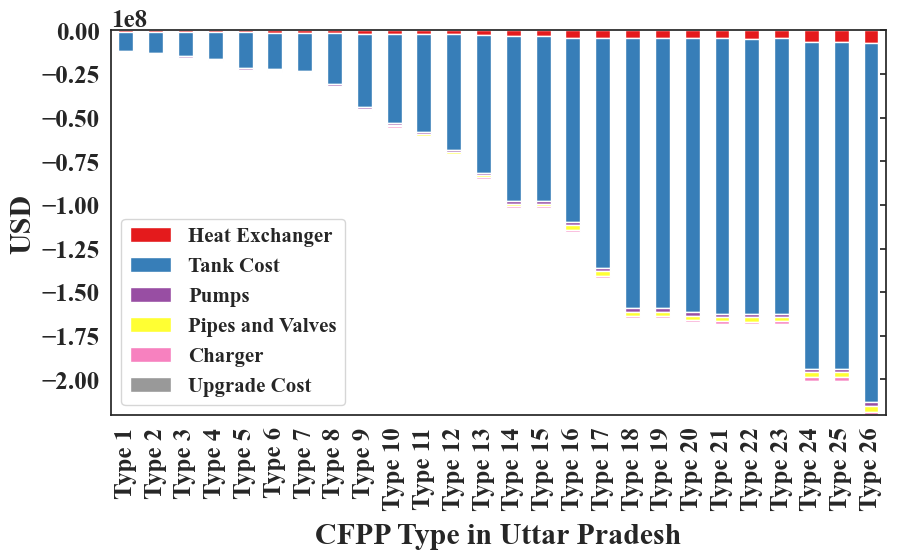

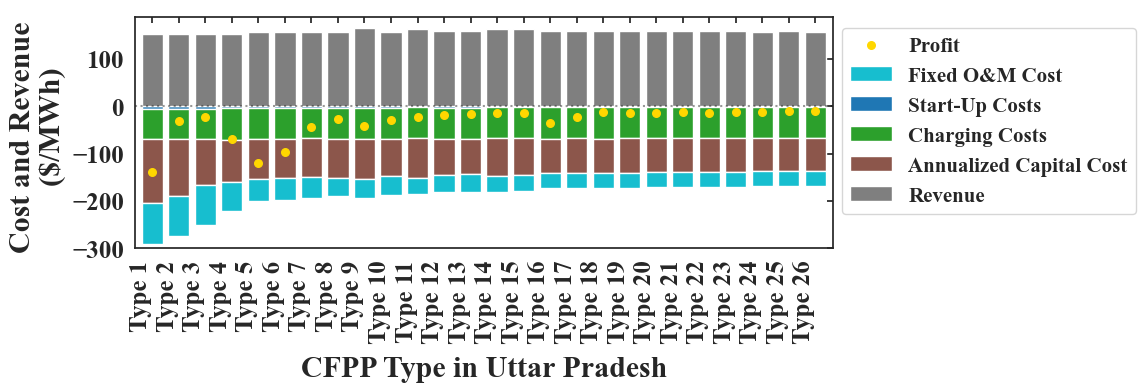

In [213]:
#set download paths
UP_path_data_download = 'figures/data/UP/'
UP_path_figures_download  = 'figures/figures/'

#download the data
download_dfs(UP_min_hours_dict,2,UP_path_data_download,UP_dir_index,UP_dir) ## set the others as global

#plot CAPEX 
#read in df_capex
df_capex = pd.read_csv(UP_path_data_download+'CAPEX.csv') ## check the units on this function
#select columns
CAPEX_columns  = ['Name','Heat Exchanger', 'Tank Cost', 'Pumps', 'Pipes and Valves', 'Charger', 'Upgrade Cost'] 
#plot
plotting_capex(df_capex,CAPEX_columns,UP_path_figures_download)

#plot LCOE
#read in df_lcoe
df_lcoe = pd.read_csv(UP_path_data_download+'LCOE.csv')
#select columns
LCOE_columns = ['Name', 'Start-Up Costs', 'Charging Costs',
       'Annualized Capital Cost',
       'Revenue', 'Fixed O&M Cost']

#plot
plotting_LCOE(df_lcoe,LCOE_columns,UP_path_figures_download)

## 5.3: Age vs. Profit of Fleet


In [214]:
ownership_dict = {"STATE SECTOR":'State Sector', 'PVT SECTOR': 'Private Sector', 'CENTRAL SECTOR':'Central Sector'}
ownership_list = UP_df['Ownership']
UP_df["Ownership"] = [*map(ownership_dict.get, ownership_list)]

In [215]:
UP_df

index          Unit ID      Plant name          State Region  \
0      12   UNCHAHAR STPS6   UNCHAHAR STPS  Uttar Pradesh     NR   
1       7        BARA TPP2        BARA TPP  Uttar Pradesh     NR   
2       6    LALITPUR TPS2    LALITPUR TPS  Uttar Pradesh     NR   
3       5    LALITPUR TPS1    LALITPUR TPS  Uttar Pradesh     NR   
4       0      TANDA STPS5      TANDA STPS  Uttar Pradesh     NR   
..    ...              ...             ...            ...    ...   
69     54        OBRA TPS9        OBRA TPS  Uttar Pradesh     NR   
70     52       OBRA TPS12        OBRA TPS  Uttar Pradesh     NR   
71     50       OBRA TPS10        OBRA TPS  Uttar Pradesh     NR   
72     51       OBRA TPS11        OBRA TPS  Uttar Pradesh     NR   
73     42  HARDUAGANJ TPS7  HARDUAGANJ TPS  Uttar Pradesh     NR   

         Ownership  Age grouping        Age Capacity Avg daily generation  \
0   Central Sector     0-5 years   3.175907    500.0             3.897856   
1   Private Sector     0-5 years   3.300479    660.0             6.302793   
2   Private Sector     0-5 years   3.300479    660.0             6.302793   
3   Private Sector     0-5 years   3.300479    660.0             6.302793   
4   Central Sector     0-5 years   3.300479    660.0             6.302793   
..             ...           ...        ...      ...                  ...   
69    State Sector   35-40 years  37.788159    200.0             2.948001   
70    State Sector   35-40 years  37.788159    200.0             2.948001   
71    State Sector   40-45 years  41.880903    200.0             3.225673   
72    State Sector   40-45 years  41.880903    200.0             3.225673   
73    State Sector   40-45 years  42.176591    105.0             0.531176   

    ... results_tank_energy_max results_min_hours  \
0   ...             7555.961879               4.0   
1   ...             9853.702576               4.0   
2   ...             9853.702576               4.0   
3   ...             9853.702576               4.0   
4   ...             9853.702576               4.0   
..  ...                     ...               ...   
69  ...              1980.19802               4.0   
70  ...              1980.19802               4.0   
71  ...              1980.19802               4.0   
72  ...              1980.19802               4.0   
73  ...             1047.381546               4.0   

                                results_y_binary_coal results_Li_LCOE_Charge  \
0         0    1    2    3    4    5    6    7    ...               0.037316   
1         0    1    2    3    4    5    6    7    ...               0.037316   
2         0    1    2    3    4    5    6    7    ...               0.037316   
3         0    1    2    3    4    5    6    7    ...               0.037316   
4         0    1    2    3    4    5    6    7    ...               0.037316   
..                                                ...                    ...   
69        0    1    2    3    4    5    6    7    ...               0.037316   
70        0    1    2    3    4    5    6    7    ...               0.037316   
71        0    1    2    3    4    5    6    7    ...               0.037316   
72        0    1    2    3    4    5    6    7    ...               0.037316   
73        0    1    2    3    4    5    6    7    ...               0.037316   

   results_TES_LCOE_Revenue results_upgrade_cost results_Group ID  Group ID  \
0                  0.158189                  0.0            186.0  Group186   
1                  0.157642                  0.0            188.0  Group188   
2                  0.157642                  0.0            188.0  Group188   
3                  0.157642                  0.0            188.0  Group188   
4                  0.157642                  0.0            188.0  Group188   
..                      ...                  ...              ...       ...   
69                 0.156657                  0.0            202.0  Group202   
70                 0.156657     

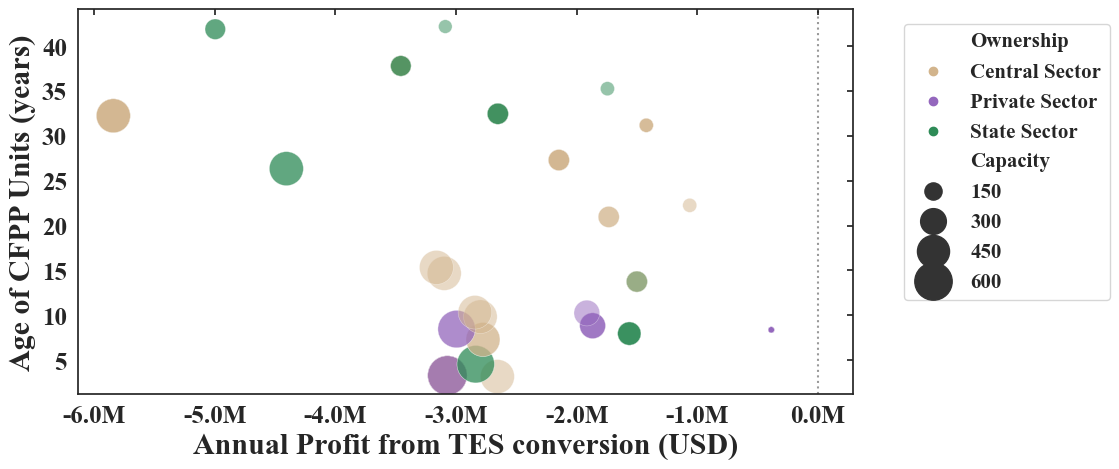

In [216]:
plotparams()

fig, ax = plt.subplots(figsize=(10,5))
sns.set(style="white")


custom_colors = ["tan", "tab:purple" , "seagreen"]  # Custom colors for the legend
#custom_colors = "tab10"

UP_df['TES_annualprofit'] = UP_df['results_objective_value']*-1 #$M


x=sns.scatterplot(data = UP_df, x='TES_annualprofit',y='Age',hue='Ownership',alpha=0.5,size=UP_df['Capacity'],sizes = (20,800), palette=custom_colors)

plt.ylabel('Age of CFPP Units (years)',fontname='Times New Roman')
plt.xlabel('Annual Profit from TES conversion (USD)',fontname='Times New Roman')
#plt.title('Retrofit Readiness of coal units in Uttar Pradesh', fontsize=fs)
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x * 1e-3))
plt.gca().xaxis.set_major_formatter(formatter)

sizes_legend = [50, 150, 250, 500]  # Marker sizes for the legend
sizes_labels = [f'{size} MW' for size in sizes_legend]  # Labels for the legend


# Display the plot with the marker size legend
plt.axvline(x=0,color='black',alpha=0.4,ls=':')

x.legend(borderaxespad=0.7,loc='upper right', bbox_to_anchor=(1.35, 1),prop=font)


for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
#save figure
plt.savefig('figures/figures/UttarPradesh_Retrofits_objfunc_circle',bbox_inches='tight',dpi=1000)



## 5.4: Durations

In [217]:
durations_UP = []

for min_hour in [2]:

    #get the df of results for one sensitivity determined in the setup above
    df = pd.DataFrame(UP_min_hours_dict[np.round(min_hour,1)]).T.reset_index()

    #rename all the columnsn in the results df to results_{name}
    for col_name in df.columns:
        df.rename(columns={col_name:'results_'+col_name},inplace=True)

    durations_UP = df['results_tank_energy_max']*df['results_steam_eff']/ df['results_powerPeak']

    profitable_df = df[df['results_objective_value']<0]
    durations_UP_profitable = profitable_df['results_tank_energy_max']*profitable_df['results_steam_eff']/ profitable_df['results_powerPeak']


# 6. Temperature-Efficiency Tradeoff for Case Study Unit

## 6.1: Download and LCOE

In [218]:
#set directories and read results
temp_eff_dir = 'RESULTS/temp_eff/'
temp_eff_dir_index = 40

temp_eff_scenarios_dict = create_sensitivity_dict(temp_eff_dir)
temp_eff_min_hours_dict = create_UP_min_hours_dict(temp_eff_scenarios_dict,temp_eff_dir,temp_eff_dir_index)

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

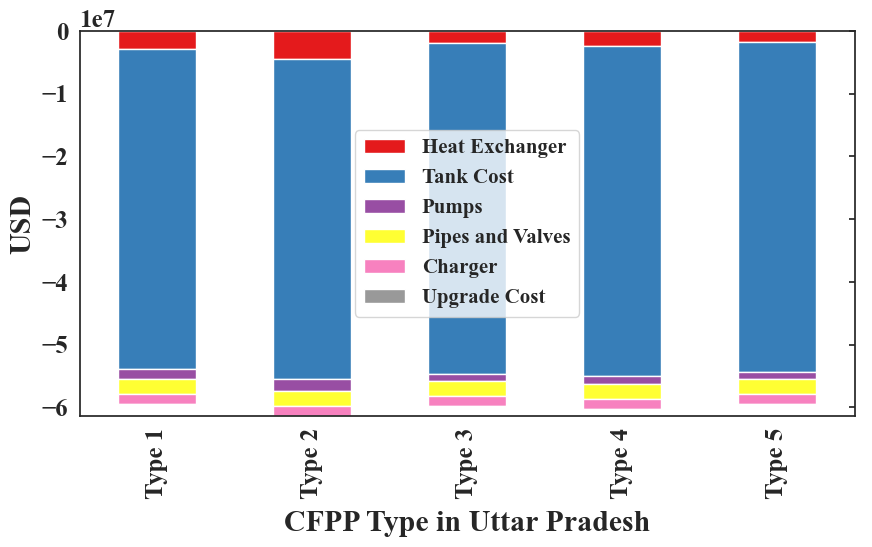

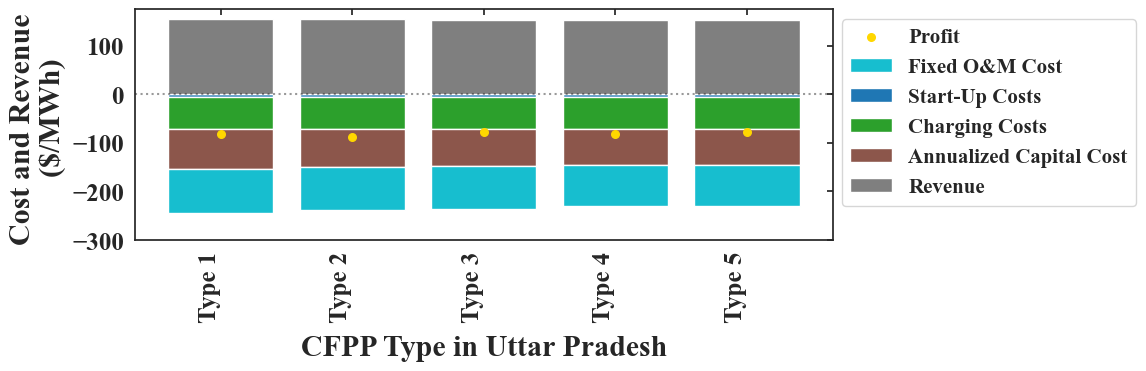

In [219]:
#set download paths
temp_eff_path_data_download = 'figures/data/temp_eff/'
temp_eff_path_figures_download  = 'figures/figures/temp_eff/'

#download the data
download_dfs(temp_eff_min_hours_dict,2,temp_eff_path_data_download,temp_eff_dir_index,temp_eff_dir) ## set the others as global

#plot CAPEX 
#read in df_capex
df_capex = pd.read_csv(temp_eff_path_data_download+'CAPEX.csv') ## check the units on this function
#select columns
CAPEX_columns  = ['Name','Heat Exchanger', 'Tank Cost', 'Pumps', 'Pipes and Valves', 'Charger', 'Upgrade Cost'] 
#plot
plotting_capex(df_capex,CAPEX_columns,temp_eff_path_figures_download)

#plot LCOE
#read in df_lcoe
df_lcoe = pd.read_csv(temp_eff_path_data_download+'LCOE.csv')
#select columns
LCOE_columns = ['Name', 'Start-Up Costs', 'Charging Costs',
       'Annualized Capital Cost',
       'Revenue', 'Fixed O&M Cost']
#plot
plotting_LCOE(df_lcoe,LCOE_columns,temp_eff_path_figures_download)

## 6.2: Duration


In [220]:
durations_temp_eff = []

for min_hour in [2]:

    #get the df of results for one sensitivity determined in the setup above
    df = pd.DataFrame(temp_eff_min_hours_dict[np.round(min_hour,1)]).T.reset_index()

    #rename all the columnsn in the results df to results_{name}
    for col_name in df.columns:
        df.rename(columns={col_name:'results_'+col_name},inplace=True)
    df.sort_values(by='results_deltaT_salt',inplace=True)
    
    #plt.scatter(df['results_cost_tank']/df['results_tank_energy_max'],df['results_objective_value']/-1000,label=np.round(min_hour,1),alpha = 0.7,s=100)

    deltaT_salt_reference = df['results_deltaT_salt']
    results_objective_reference = df['results_objective_value']/-1000
    results_UA_3_reference = df['results_UA_3']
    results_UA_2_reference = df['results_UA_2']
    results_UA_1_reference = df['results_UA_1']
    durations_temp_eff = df['results_tank_energy_max']*df['results_steam_eff']/ df['results_powerPeak']

    profitable_df = df[df['results_objective_value']<0]
    durations_temp_eff_profitable = profitable_df['results_tank_energy_max']*profitable_df['results_steam_eff']/ profitable_df['results_powerPeak']

    
    

## 6.3: Figure

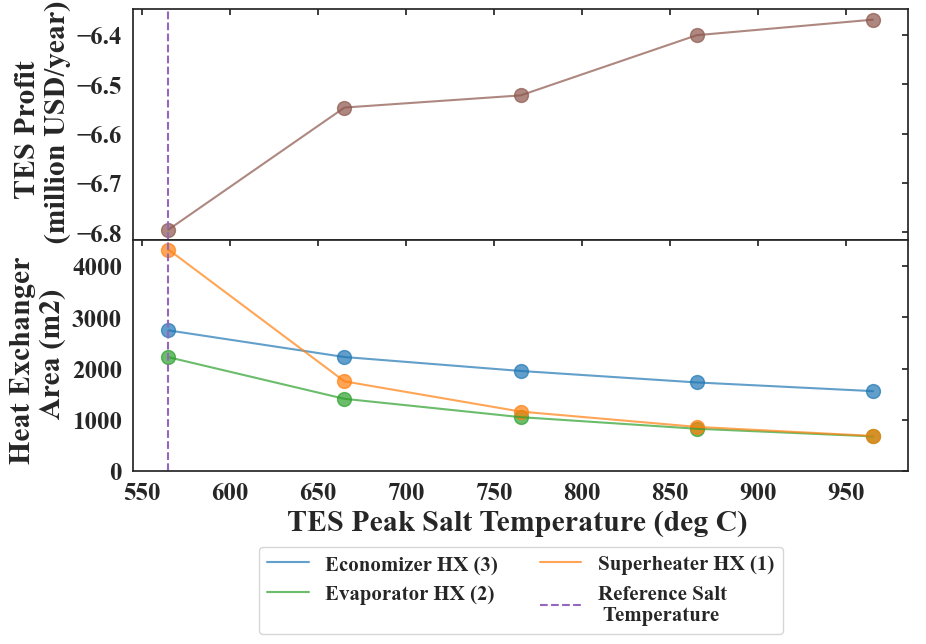

In [221]:
plotparams()

fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(2,1, hspace=0)
(ax1, ax2) = gs.subplots( sharex=True)

sns.set(style="white")


#plot the reference objective values
ax1.plot(deltaT_salt_reference+290,results_objective_reference,label='Reference HX \n Cost Input',color='tab:brown',alpha = 0.7)
ax1.scatter(deltaT_salt_reference+290,results_objective_reference,s=100,color='tab:brown',alpha = 0.7)

ax1.axvline(x=565,linestyle = '--',color='tab:purple',label='Reference Salt \n Temperature')




for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman")

#U values
U_1	= 1.241/1000	#kW/m2 K	superheater
U_2	= 1.295/1000	#kW/m2 K	evaporator
U_3	= 1.448/1000	#kW/m2 K	economizer / preheater

#plot the UA decision variable of reference
ax2.plot(deltaT_salt_reference+290,results_UA_3_reference/U_3,label='Economizer HX (3)',color='tab:blue',alpha = 0.7)
ax2.scatter(deltaT_salt_reference+290,results_UA_3_reference/U_3,s=100,color='tab:blue',alpha = 0.7)

ax2.plot(deltaT_salt_reference+290,results_UA_2_reference/U_2,label='Evaporator HX (2)',color='tab:green',alpha = 0.7)
ax2.scatter(deltaT_salt_reference+290,results_UA_2_reference/U_2,s=100,color='tab:green',alpha = 0.7)

ax2.plot(deltaT_salt_reference+290,results_UA_1_reference/U_1,label='Superheater HX (1)',color='tab:orange',alpha = 0.7)
ax2.scatter(deltaT_salt_reference+290,results_UA_1_reference/U_1,s=100,color='tab:orange',alpha = 0.7)


#set labels
ax2.set_ylabel('Heat Exchanger \n Area (m2)')
ax2.set_xlabel('TES Peak Salt Temperature (deg C) \n')#,fontname='Times New Roman')
#MW/K to m2 

plt.ylim(bottom=0)
ax2.axvline(x=565,linestyle = '--',color='tab:purple',label='Reference Salt \n Temperature')
ax2.legend(loc='lower center',prop=font,ncol=2,bbox_to_anchor=(0.5,-0.75))

for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman")


ax1.set_ylabel('TES Profit \n (million USD/year)',fontname='Times New Roman')

#save figure
plt.savefig('figures/figures/temp_eff/temp_eff_profits_HX', bbox_inches='tight',dpi=1400) 
plt.savefig('figures/figures/temp_eff/temp_eff_profits_HX.svg',format='svg')


# 7. Storage Cost Sensitivity



/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

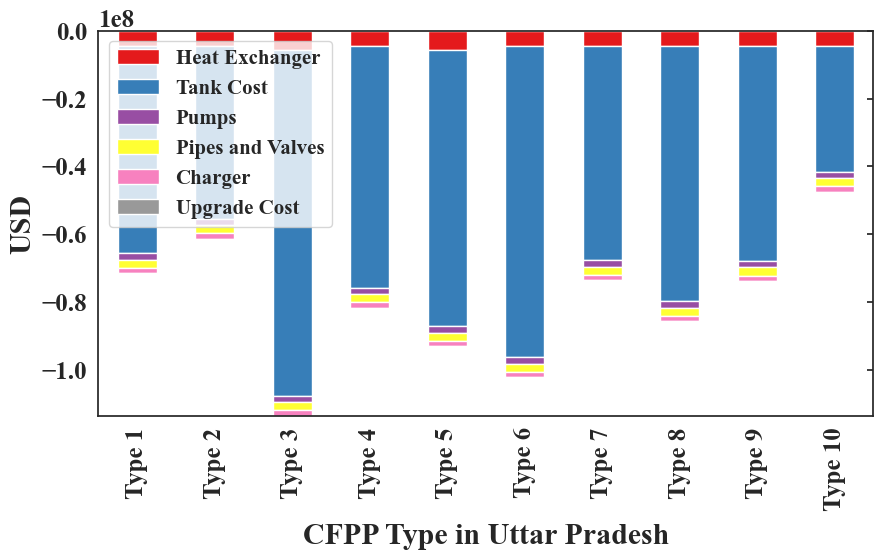

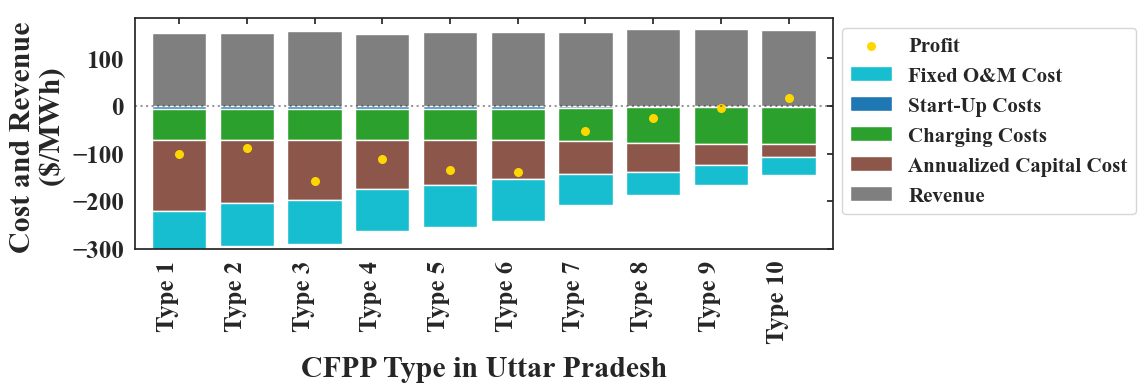

In [222]:
storage_cost_dir = 'RESULTS/storage_cost/'
storage_cost_dir_index = 44

storage_cost_scenarios_dict = create_sensitivity_dict(storage_cost_dir)
storage_cost_min_hours_dict = create_UP_min_hours_dict(storage_cost_scenarios_dict,storage_cost_dir,storage_cost_dir_index)

#set download paths
storage_cost_path_data_download = 'figures/data/storage_cost/'
storage_cost_path_figures_download  = 'figures/figures/storage_cost/'

#download the data
download_dfs(storage_cost_min_hours_dict,2,storage_cost_path_data_download,storage_cost_dir_index,storage_cost_dir) ## set the others as global

#plot CAPEX 
#read in df_capex
df_capex = pd.read_csv(storage_cost_path_data_download+'CAPEX.csv') ## check the units on this function
#select columns
CAPEX_columns  = ['Name','Heat Exchanger', 'Tank Cost', 'Pumps', 'Pipes and Valves', 'Charger', 'Upgrade Cost'] 
#plot
plotting_capex(df_capex,CAPEX_columns,storage_cost_path_figures_download)

# plt.xlabel('temperatures') 

#plot LCOE
#read in df_lcoe
df_lcoe = pd.read_csv(storage_cost_path_data_download+'LCOE.csv')
#select columns
LCOE_columns = ['Name', 'Start-Up Costs', 'Charging Costs',
       'Annualized Capital Cost',
       'Revenue', 'Fixed O&M Cost']
#plot
plotting_LCOE(df_lcoe,LCOE_columns,storage_cost_path_figures_download)

## 7.1: Figure

In [223]:
min_hour = 1 #choose which min hour you want to plot
df =  pd.DataFrame(storage_cost_min_hours_dict[np.round(min_hour,1)]).T.reset_index()
df.sort_values(by='CAPEX_TES_storage',inplace=True)
storage_cost_list_ref=df['CAPEX_TES_storage']/df['tank_energy_max'] #$/kWh
results_objective_ref = df['objective_value']/-1000  #Millions USD
tank_cost_ref = df['CAPEX_TES_storage']/-1000   #Millions USD   
tank_size_ref = df['tank_energy_max']  #MWh
results_UA_ref = df['UA_3'] #don't need this

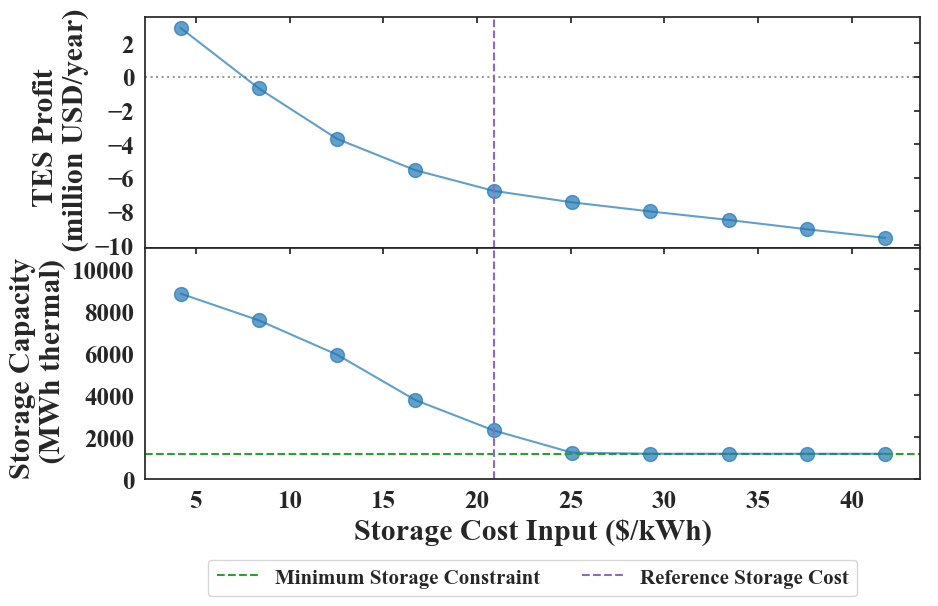

In [224]:
plotparams()
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(2,1, hspace=0)
(ax1, ax2) = gs.subplots( sharex=True)


sns.set(style="white")

ax1.axhline(y=0,color='black',alpha=0.4,ls=':')

ax1.plot(np.sort(storage_cost_list_ref),np.sort(results_objective_ref)[::-1],label='Reference HX Cost Input',color='tab:blue',alpha = 0.7)
ax1.scatter(storage_cost_list_ref,results_objective_ref,s=100,color='tab:blue',alpha = 0.7)

# ax1.plot(storage_cost_list_high,results_objective_high,label='High HX Cost Input',color='tab:orange',alpha = 0.7)
# ax1.scatter(storage_cost_list_high,results_objective_high,s=100,color='tab:orange',alpha = 0.7)

ax1.axvline(x=20.89,linestyle = '--',color='tab:purple')

#font = font_manager.FontProperties(family='Times New Roman',
                                   #weight='bold'                                   )

ax2.axhline(y=500*1/0.41,linestyle = '--',color='tab:green',label='Minimum Storage Constraint')

# plt.xlim(left=0)
# plt.ylim(bottom=0)

for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman")

ax2.plot(np.sort(storage_cost_list_ref),np.sort(tank_size_ref)[::-1],color='tab:blue',alpha = 0.7)
ax2.scatter(storage_cost_list_ref,tank_size_ref,s=100,color='tab:blue',alpha = 0.7)

# ax2.plot(storage_cost_list_high,tank_size_high,label='High HX Cost Input',color='tab:orange',alpha = 0.7)
# ax2.scatter(storage_cost_list_high,tank_size_high,s=100,color='tab:orange',alpha = 0.7)


ax2.set_ylabel('Storage Capacity \n (MWh thermal)',fontname='Times New Roman')
ax2.set_xlabel('Storage Cost Input ($/kWh)',fontname='Times New Roman')

ax2.axvline(x=20.89,linestyle = '--',color='tab:purple',label='Reference Storage Cost')
ax2.legend(bbox_to_anchor=(0.5, -0.55),prop=font,loc='lower center',ncols=2)


for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman")

plt.ylim(ymin = 0,ymax=11000)
ax1.set_ylabel('TES Profit \n (million USD/year)',fontname='Times New Roman')

#save figure
plt.savefig('figures/figures/storage_cost/storage_sensitivity', bbox_inches='tight',dpi=1000) 
plt.savefig('figures/figures/storage_cost/storage_sensitivity.svg',format='svg')


## 7.3: plot storage and temp-eff sensitivities side by side

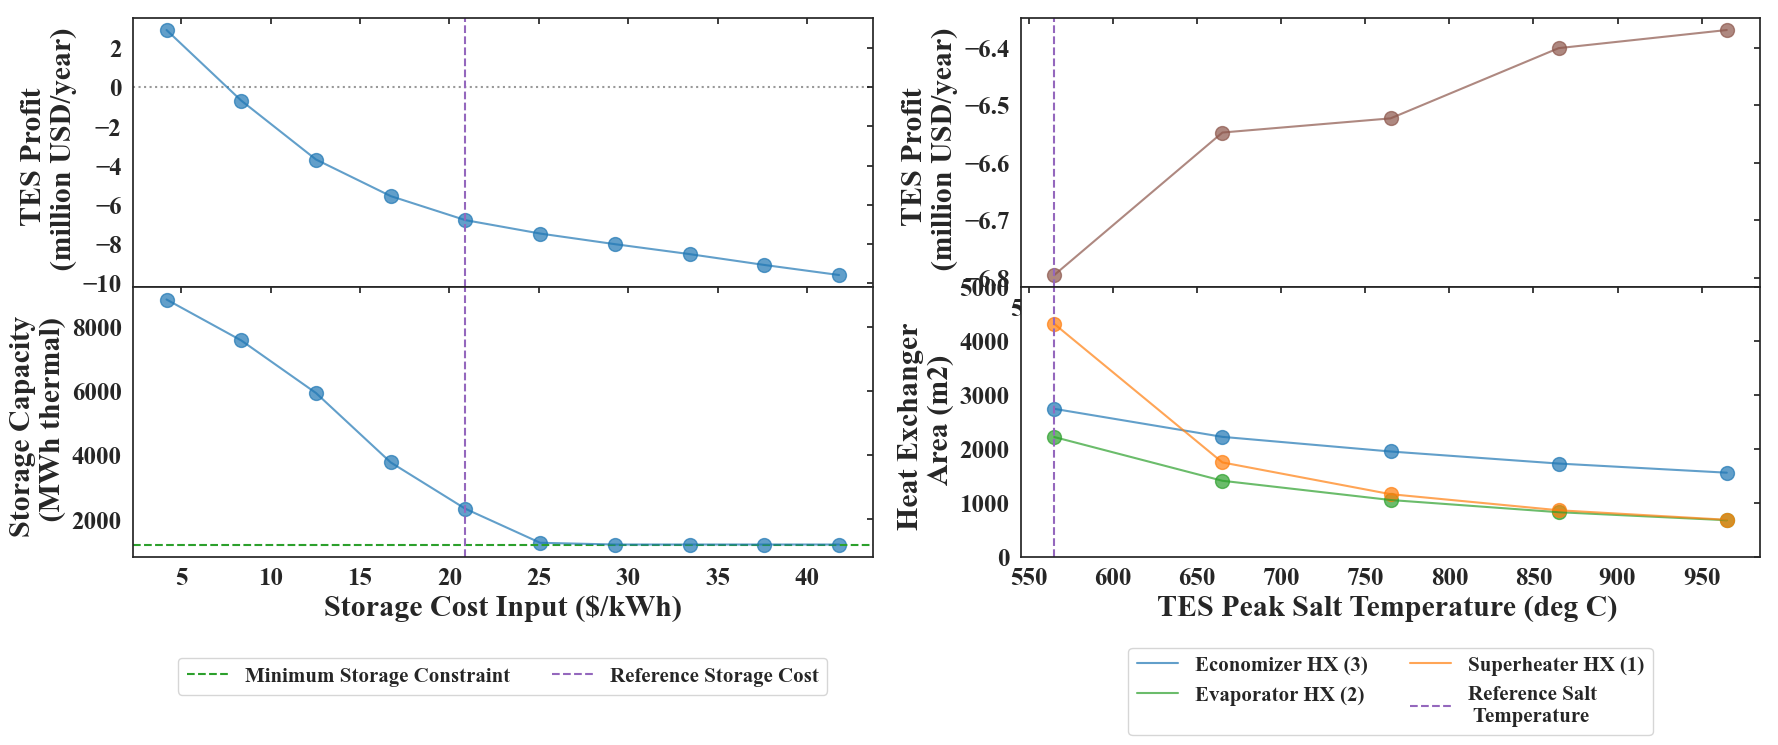

In [225]:
plotparams()
fig = plt.figure(figsize=(21,7))
gs = fig.add_gridspec(2,2, hspace=0)
((ax1, ax3),(ax2, ax4)) = gs.subplots()


sns.set(style="white")

ax1.axhline(y=0,color='black',alpha=0.4,ls=':')

ax1.plot(np.sort(storage_cost_list_ref),np.sort(results_objective_ref)[::-1],label='Reference HX Cost Input',color='tab:blue',alpha = 0.7)
ax1.scatter(storage_cost_list_ref,results_objective_ref,s=100,color='tab:blue',alpha = 0.7)

# ax1.plot(storage_cost_list_high,results_objective_high,label='High HX Cost Input',color='tab:orange',alpha = 0.7)
# ax1.scatter(storage_cost_list_high,results_objective_high,s=100,color='tab:orange',alpha = 0.7)

ax1.axvline(x=20.89,linestyle = '--',color='tab:purple')

#font = font_manager.FontProperties(family='Times New Roman',
                                   #weight='bold'                                   )

ax2.axhline(y=500*1/0.41,linestyle = '--',color='tab:green',label='Minimum Storage Constraint')

# plt.xlim(left=0)
# plt.ylim(bottom=0)

for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman")

ax2.plot(np.sort(storage_cost_list_ref),np.sort(tank_size_ref)[::-1],color='tab:blue',alpha = 0.7)
ax2.scatter(storage_cost_list_ref,tank_size_ref,s=100,color='tab:blue',alpha = 0.7)


ax2.set_ylabel('Storage Capacity \n (MWh thermal)',fontname='Times New Roman')
ax2.set_xlabel('Storage Cost Input ($/kWh)',fontname='Times New Roman')

ax2.axvline(x=20.89,linestyle = '--',color='tab:purple',label='Reference Storage Cost')
ax2.legend(bbox_to_anchor=(0.5, -0.55),prop=font,loc='lower center',ncols=2)


for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman")

plt.ylim(ymin = 0,ymax=5000)
ax1.set_ylabel('TES Profit \n (million USD/year)',fontname='Times New Roman')


#################################


#plot the reference objective values
ax3.plot(deltaT_salt_reference+290,results_objective_reference,label='Reference HX \n Cost Input',color='tab:brown',alpha = 0.7)
ax3.scatter(deltaT_salt_reference+290,results_objective_reference,s=100,color='tab:brown',alpha = 0.7)

ax3.axvline(x=565,linestyle = '--',color='tab:purple',label='Reference Salt \n Temperature')




for tick in ax3.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Times New Roman")

#U values
U_1	= 1.241/1000	#kW/m2 K	superheater
U_2	= 1.295/1000	#kW/m2 K	evaporator
U_3	= 1.448/1000	#kW/m2 K	economizer / preheater

#plot the UA decision variable of reference
ax4.plot(deltaT_salt_reference+290,results_UA_3_reference/U_3,label='Economizer HX (3)',color='tab:blue',alpha = 0.7)
ax4.scatter(deltaT_salt_reference+290,results_UA_3_reference/U_3,s=100,color='tab:blue',alpha = 0.7)

ax4.plot(deltaT_salt_reference+290,results_UA_2_reference/U_2,label='Evaporator HX (2)',color='tab:green',alpha = 0.7)
ax4.scatter(deltaT_salt_reference+290,results_UA_2_reference/U_2,s=100,color='tab:green',alpha = 0.7)

ax4.plot(deltaT_salt_reference+290,results_UA_1_reference/U_1,label='Superheater HX (1)',color='tab:orange',alpha = 0.7)
ax4.scatter(deltaT_salt_reference+290,results_UA_1_reference/U_1,s=100,color='tab:orange',alpha = 0.7)


#set labels
ax4.set_ylabel('Heat Exchanger \n Area (m2)')
ax4.set_xlabel('TES Peak Salt Temperature (deg C) \n')#,fontname='Times New Roman')
#MW/K to m2 

plt.ylim(bottom=0)
ax4.axvline(x=565,linestyle = '--',color='tab:purple',label='Reference Salt \n Temperature')
ax4.legend(loc='lower center',prop=font,ncol=2,bbox_to_anchor=(0.5,-0.7))

for tick in ax4.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax4.get_yticklabels():
    tick.set_fontname("Times New Roman")


ax3.set_ylabel('TES Profit \n (million USD/year)',fontname='Times New Roman')


#save figure
plt.savefig('figures/figures/storage_cost/storage_and_temp', bbox_inches='tight',dpi=1000) 
# plt.savefig('figures/figures/storage_cost/storage_sensitivity.svg',format='svg')


## 7.4: Dispatch Plot under different storage cost

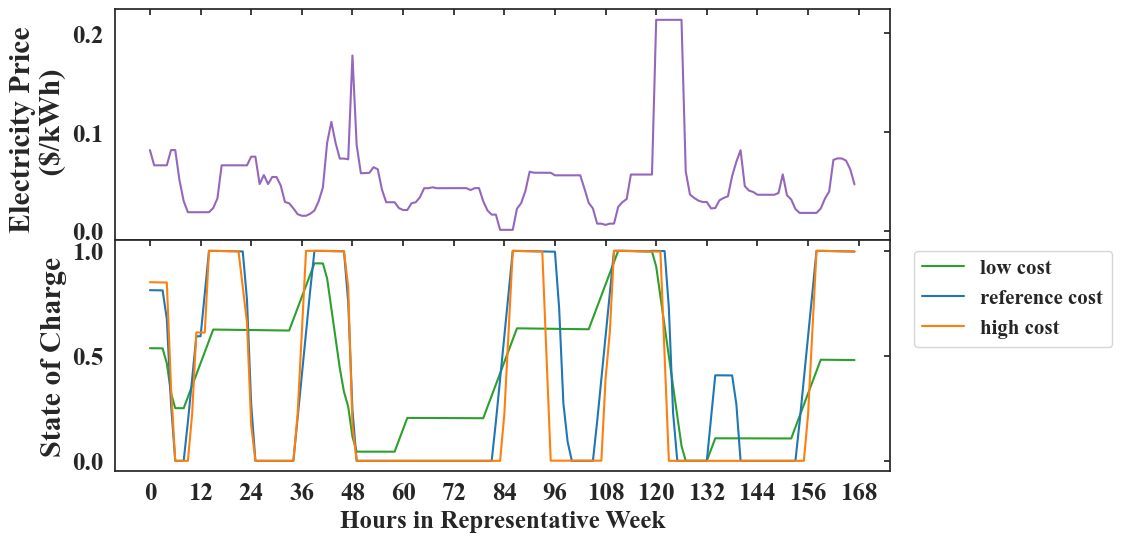

In [226]:
plotparams()

#plot the storage dispatch under a representative week for different costs
rep_week = 10
#plot the figures

fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2,1, hspace=0)
(ax1,ax2) = gs.subplots( sharex=True)

df_1 = storage_cost_min_hours_dict[1]['TrombayU5_4_1hrs.csv']
df_2 = storage_cost_min_hours_dict[1]['TrombayU5_20_1hrs.csv']
df_3 = storage_cost_min_hours_dict[1]['TrombayU5_41_1hrs.csv']


ax1.plot(df_1['cost_energy_t'][rep_week],label='Electricity Price ($/kWh)',color='tab:purple')
ax1.set_ylabel('Electricity Price \n ($/kWh)') 
ax1.tick_params(axis='both')
#handles0, labels0 = plt.gca().get_legend_handles_labels()

def abs_max(x):
    y = abs(max(x))
    return y

# flow_d = df_1['flowSalt_discharge_t'].loc[:,rep_week]/abs_max(df_1['flowSalt_discharge_t'].loc[:,rep_week])
# ax2.plot(flow_d,label='Discharge Salt Flow',color='tab:orange')

# flow_c = df_1['flowSalt_charge_t'].loc[:,rep_week]/abs_max(df_1['flowSalt_charge_t'].loc[:,rep_week])
# ax2.plot(flow_c,label='Charge Salt Flow',color='brown',linestyle='dashed')

ax2.set_ylabel('State of Charge')
ax2.set_xlabel('Hours in Representative Week')

handles, labels = plt.gca().get_legend_handles_labels()


#ax3 = ax2.twinx()
tank_e1 = df_1['tank_energy_t'].loc[:,rep_week]/1000/abs_max(df_1['tank_energy_t'].loc[:,rep_week]/1000)
tank_e2 = df_2['tank_energy_t'].loc[:,rep_week]/1000/abs_max(df_2['tank_energy_t'].loc[:,rep_week]/1000)
tank_e3 = df_3['tank_energy_t'].loc[:,rep_week]/1000/abs_max(df_3['tank_energy_t'].loc[:,rep_week]/1000)


ax2.plot(tank_e1,label = 'low cost',color='tab:green')
ax2.plot(tank_e2,label = 'reference cost',color='tab:blue')
ax2.plot(tank_e3,label = 'high cost',color='tab:orange')

#ax3.set_ylabel('GWh (thermal)',rotation=270,labelpad=12,color='tab:blue') #adding a space here... and adding different ones
ax2.set_xlabel('Hours in Representative Week',fontsize=fs)
ax2.xaxis.set_ticks(np.arange(0, 168+12, 12))

# plt.xticks(fontsize=fs)
# plt.yticks(fontsize=fs)

handles2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles2,loc='upper right', bbox_to_anchor=(1.3, 1),prop=font)
plt.savefig('figures/figures/storage_cost/representative_dispatch_storage.svg',format='svg')
plt.savefig('figures/figures/storage_cost/representative_dispatch_storage.png')


## 7.5: Durations

In [227]:
## storage durations

min_hour = 2

#get the df of results for one sensitivity determined in the setup above
df = pd.DataFrame(storage_cost_min_hours_dict[np.round(min_hour,1)]).T.reset_index()

#rename all the columnsn in the results df to results_{name}
for col_name in df.columns:
    df.rename(columns={col_name:'results_'+col_name},inplace=True)

    
durations_storage = df['results_tank_energy_max']*df['results_steam_eff']/ df['results_powerPeak']

profitable_df = df[df['results_objective_value']<0]
durations_storage_profitable = profitable_df['results_tank_energy_max']*profitable_df['results_steam_eff']/ profitable_df['results_powerPeak']

    

## 7.6: Plot of Li-sample dispatch

In [228]:

dict25 = storage_cost_min_hours_dict[2]['TrombayU5_20_2hrs.csv']
rep_week = 3 #randomly chosen

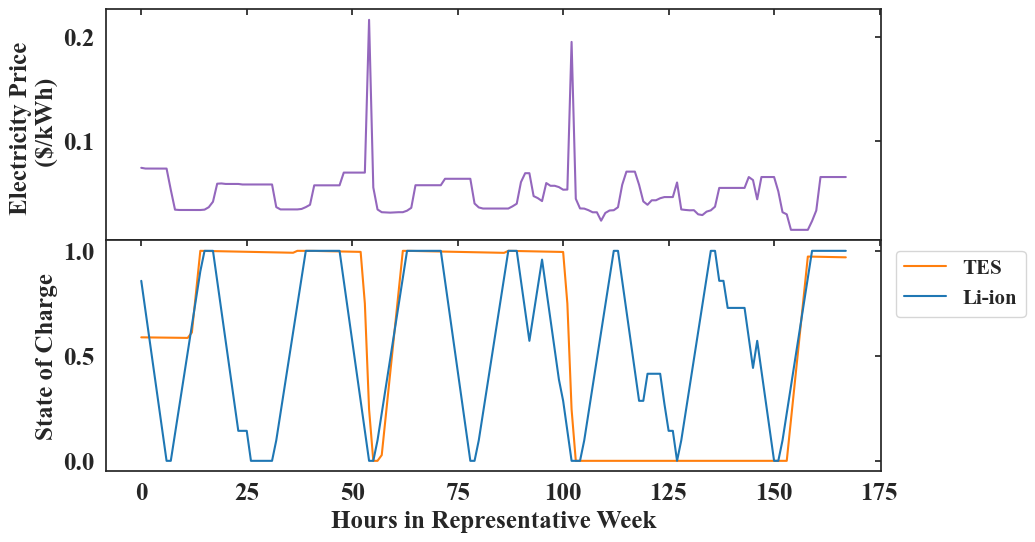

In [229]:
#plot the figures
plotparams()


fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2,1, hspace=0)
(ax1,ax2) = gs.subplots( sharex=True)


ax1.plot(dict25['cost_energy_t'][rep_week],label='Electricity Price ($/kWh)',color='tab:purple')
ax1.set_ylabel('Electricity Price \n ($/kWh)',fontsize=fs) 
ax1.tick_params(axis='both', labelsize = fs)
#handles0, labels0 = plt.gca().get_legend_handles_labels()

def abs_max(x):
    y = abs(max(x))
    return y

ax2.set_ylabel('State of Charge',fontsize=fs)
ax2.set_xlabel('Hours in Representative Week',fontsize=fs)

handles, labels = plt.gca().get_legend_handles_labels()


#ax3 = ax2.twinx()
Li_soc = dict25['soc_t'].loc[:,rep_week]/1000/abs_max(dict25['soc_t'].loc[:,rep_week]/1000)
tank_e = dict25['tank_energy_t'].loc[:,rep_week]/1000/abs_max(dict25['tank_energy_t'].loc[:,rep_week]/1000)
ax2.plot(tank_e,label = 'TES',color='tab:orange')
ax2.plot(Li_soc,label = 'Li-ion',color='tab:blue')

#ax3.set_ylabel('GWh (thermal)',rotation=270,labelpad=12,color='tab:blue') #adding a space here... and adding different ones
ax2.set_xlabel('Hours in Representative Week',fontsize=fs)
plt.xticks(fontsize=fs)


plt.yticks(fontsize=fs)

handles2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles2,loc='upper right', bbox_to_anchor=(1.2, 1),prop=font)

plt.savefig('figures/figures/storage_cost/representative_Li', bbox_inches='tight',dpi=1000)


In [230]:
#print LCOE values
print(dict25['Li_LCOE_total'])
print(dict25['TES_LCOE_total'])

0.11007225678580941
0.2426589675979845


# 8. Industrial Sensitivity

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

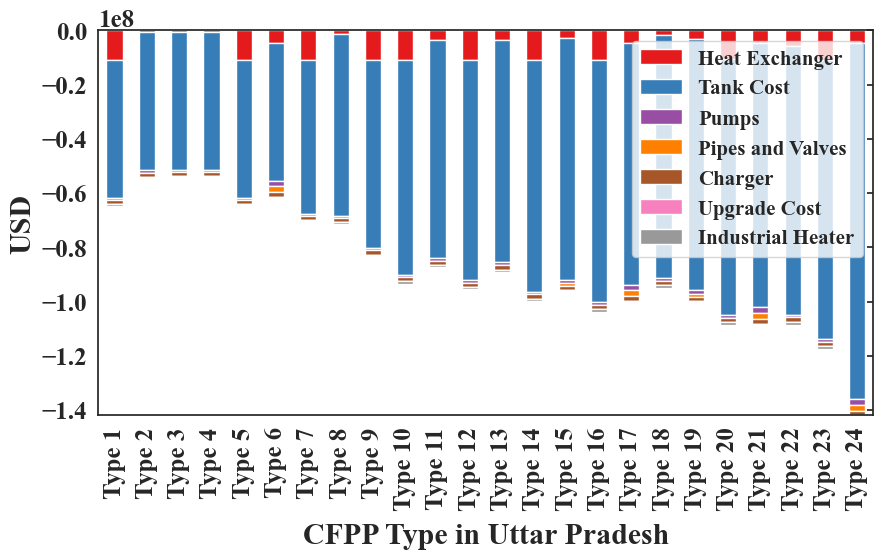

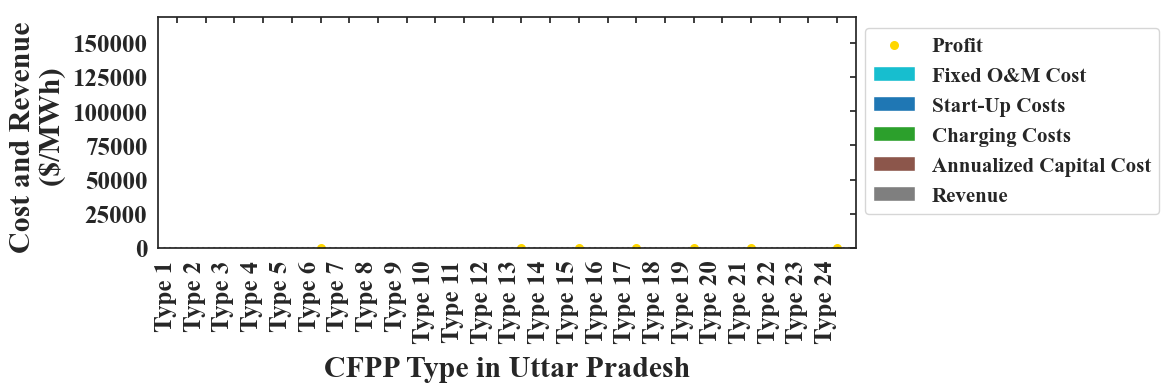

In [231]:
industrial_dir = 'RESULTS/industrial/'
industrial_dir_index = 42

industrial_scenarios_dict = create_sensitivity_dict(industrial_dir)
industrial_min_hours_dict = create_UP_min_hours_dict(industrial_scenarios_dict,industrial_dir,industrial_dir_index)

#set download paths
industrial_path_data_download = 'figures/data/industrial/'
industrial_path_figures_download  = 'figures/figures/industrial/'

#download the data
download_dfs(industrial_min_hours_dict,2,industrial_path_data_download,industrial_dir_index,industrial_dir) ## set the others as global

#plot CAPEX 
#read in df_capex
df_capex = pd.read_csv(industrial_path_data_download+'CAPEX.csv') ## check the units on this function
#select columns
CAPEX_columns  = ['Name','Heat Exchanger', 'Tank Cost', 'Pumps', 'Pipes and Valves', 'Charger', 'Upgrade Cost', 'Industrial Heater'] 
#plot
plotting_capex(df_capex,CAPEX_columns,industrial_path_figures_download)

# plt.xlabel('temperatures') 

#plot LCOE
#read in df_lcoe
df_lcoe = pd.read_csv(industrial_path_data_download+'LCOE.csv')
#select columns
LCOE_columns = ['Name', 'Start-Up Costs', 'Charging Costs',
       'Annualized Capital Cost',
       'Revenue', 'Fixed O&M Cost']
#plot
plotting_LCOE(df_lcoe,LCOE_columns,industrial_path_figures_download)

## 8.1: Durations

In [232]:
#get durations for industrial case 
min_hour = 2

#get the df of results for one sensitivity determined in the setup above
df = pd.DataFrame(industrial_min_hours_dict[np.round(min_hour,1)]).T.reset_index()

#rename all the columnsn in the results df to results_{name}
for col_name in df.columns:
    df.rename(columns={col_name:'results_'+col_name},inplace=True)
    
durations_industrial = df['results_tank_energy_max']*df['results_steam_eff']/ df['results_powerPeak']

## 8.2: Dispatch comparison

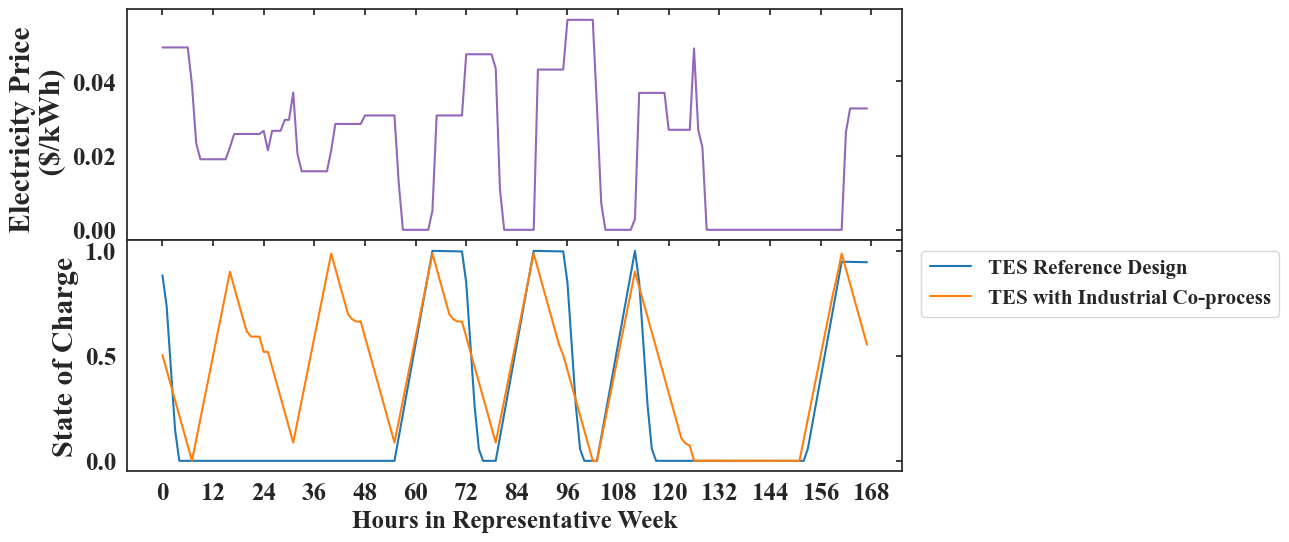

In [233]:
rep_week = 7
zero_index = 23
ind_index = 20 ## have to check these with df above

min_hour = 2
df = pd.DataFrame(industrial_min_hours_dict[np.round(min_hour,1)]).T.reset_index()

plotparams()


fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2,1, hspace=0)
(ax1,ax2) = gs.subplots( sharex=True)


zeros = df['tank_energy_t'][zero_index][rep_week]/df['tank_energy_max'][zero_index]
ind = df['tank_energy_t'][ind_index][rep_week]/df['tank_energy_max'][ind_index]


ax1.plot(df['cost_energy_t'][zero_index][rep_week],label='Electricity Price ($/kWh)',color='tab:purple')
ax1.set_ylabel('Electricity Price \n ($/kWh)') 
ax1.tick_params(axis='both')

def abs_max(x):
    y = abs(max(x))
    return y


ax2.set_ylabel('State of Charge')
ax2.set_xlabel('Hours in Representative Week')

handles, labels = plt.gca().get_legend_handles_labels()

ax2.plot(zeros,label = 'TES Reference Design' ,color='tab:blue')
ax2.plot(ind,label = 'TES with Industrial Co-process',color='tab:orange')

ax2.set_xlabel('Hours in Representative Week',fontsize=fs)
ax2.xaxis.set_ticks(np.arange(0, 168+12, 12))


handles2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles2,loc='upper right', bbox_to_anchor=(1.5, 1),prop=font)

plt.savefig('figures/figures/industrial/industrialSOC', bbox_inches='tight',dpi=1000)


## 8.3: Break even price with multiple price profiles

In [234]:
#picking the min_hours case (CHANGE IF NEEDED)
df = pd.DataFrame(industrial_min_hours_dict[np.round(2,1)]).T.reset_index()

 #rename all the columnsn in the results df to results_{name}
for col_name in df.columns:
    df.rename(columns={col_name:'results_'+col_name},inplace=True)
df.sort_values(by='results_tank_energy_max',inplace=True) 

In [235]:

df_profile = df[['UTTAR_PRADESH' in df.loc[i,'results_index'] for i in df.index]].reset_index(drop=True)
df_profile[['results_Q_ind','results_objective_value',
            'results_tank_energy_max','results_powerTurbine']]

results_Q_ind results_objective_value results_tank_energy_max  \
0         100.0            41423.209919              2439.02439   
1          50.0            25351.463237              2439.02439   
2         150.0            58700.470618              2713.53276   
3         200.0            75768.843362              3320.27463   
4         250.0            93551.279391             3889.748337   
5         300.0           112577.826945             4519.193866   
6         350.0           132478.361319              4933.26663   
7           0.0             4240.713336             6295.322463   

  results_powerTurbine  
0             0.275658  
1             0.137829  
2             0.413487  
3             0.551315  
4             0.689144  
5             0.826973  
6             0.964802  
7           515.463918

In [236]:
df_profile = df[['MAHARASHTRA' in df.loc[i,'results_index'] for i in df.index]].reset_index(drop=True)
df_profile[['results_Q_ind','results_objective_value','results_tank_energy_max','results_powerTurbine']]

results_Q_ind results_objective_value results_tank_energy_max  \
0         150.0            61241.030144              2439.02439   
1          50.0            27199.763364              2439.02439   
2         100.0            44312.529832              2439.02439   
3           0.0             6747.915146              2439.02439   
4         200.0            78672.409015             3215.885747   
5         250.0            100032.76922             3792.826956   
6         300.0           122024.186327              4094.17287   
7         350.0           144292.036478             4267.107926   

  results_powerTurbine  
0             0.413487  
1             0.137829  
2             0.275658  
3           515.463918  
4             0.551315  
5             0.689144  
6             0.281171  
7             0.328033

In [237]:
df_profile = df[['GUJARAT' in df.loc[i,'results_index'] for i in df.index]].reset_index(drop=True)
df_profile[['results_Q_ind','results_objective_value','results_tank_energy_max','results_powerTurbine']]


results_Q_ind results_objective_value results_tank_energy_max  \
0         250.0             35865.92016              3856.85343   
1         200.0            28189.570541             3915.874094   
2         150.0            21036.502022             4266.041814   
3           0.0            -2357.938991             4267.653511   
4         300.0            43287.252101             4300.034126   
5         100.0            13770.171974             4424.548206   
6          50.0             6205.168515             4665.473818   
7         350.0            54335.847978              4740.14213   

  results_powerTurbine  
0             0.231861  
1            50.091702  
2           197.212629  
3           515.463918  
4             0.826973  
5           276.078554  
6           515.463918  
7             0.318808

In [238]:
df.reset_index(drop=True,inplace=True)

In [239]:
color_map = {'UTTAR PRADESH.csv': {'color': 'tab:purple'},
            'MAHARASHTRA.csv': {'color': np.array([0.4, 0.4, 0.4, 1. ])},
            'GUJARAT.csv': {'color': np.array([0.10588235, 0.61960784, 0.46666667, 1.        ])}
}


## 8.4: Figure

percentage:  0.3 
 local TES: 849729.6914614178 
 heater: 460670.3085385824 
 elec only: 1310400.0
percentage:  0.09999999999999999 
 local TES: 343093.53233141056 
 heater: 93706.46766858947 
 elec only: 436799.99999999994
percentage:  0.19999999999999998 
 local TES: 660127.8418991602 
 heater: 213472.15810084 
 elec only: 873599.9999999999
percentage:  0.0 
 local TES: 0.0 
 heater: 0.0 
 elec only: 0.0
percentage:  0.39999999999999997 
 local TES: 1125693.5764842348 
 heater: 621506.423515765 
 elec only: 1747199.9999999998
percentage:  0.49999999999999994 
 local TES: 1315450.2941511248 
 heater: 868549.705848875 
 elec only: 2183999.9999999995
percentage:  0.6 
 local TES: 1400794.9499045478 
 heater: 1220005.0500954522 
 elec only: 2620800.0


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:186: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:186: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

percentage:  0.7 
 local TES: 1470104.332014116 
 heater: 1587495.667985884 
 elec only: 3057600.0


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:186: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)


percentage:  0.19999999999999998 
 local TES: 587445.1054958056 
 heater: 286154.8945041942 
 elec only: 873599.9999999999
percentage:  0.09999999999999999 
 local TES: 331080.7195845589 
 heater: 105719.2804154409 
 elec only: 436799.99999999994
percentage:  0.3 
 local TES: 826580.9202683668 
 heater: 483819.0797316331 
 elec only: 1310400.0
percentage:  0.39999999999999997 
 local TES: 1050779.6090088403 
 heater: 696420.3909911598 
 elec only: 1747199.9999999998
percentage:  0.49999999999999994 
 local TES: 1257717.1219649212 
 heater: 926282.878035079 
 elec only: 2183999.9999999995
percentage:  0.6 
 local TES: 1402775.696248651 
 heater: 1218024.303751349 
 elec only: 2620800.0
percentage:  0.7 
 local TES: 1521433.963992319 
 heater: 1536166.0360076807 
 elec only: 3057600.0
percentage:  0.0 
 local TES: 0.0 
 heater: 0.0 
 elec only: 0.0


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:186: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:186: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

percentage:  0.49999999999999994 
 local TES: 1137532.9892005543 
 heater: 1046467.0107994468 
 elec only: 2183999.9999999995
percentage:  0.39999999999999997 
 local TES: 948467.053372587 
 heater: 798732.9466274128 
 elec only: 1747199.9999999998
percentage:  0.3 
 local TES: 648850.1175534948 
 heater: 661549.8824465052 
 elec only: 1310400.0
percentage:  0.0 
 local TES: 0.0 
 heater: 0.0 
 elec only: 0.0
percentage:  0.6 
 local TES: 1294410.765400251 
 heater: 1326389.234599749 
 elec only: 2620800.0
percentage:  0.19999999999999998 
 local TES: 403027.1071707589 
 heater: 470572.892829241 
 elec only: 873599.9999999999
percentage:  0.09999999999999999 
 local TES: 145534.64619523002 
 heater: 291265.35380477 
 elec only: 436799.99999999994
percentage:  0.7 
 local TES: 1349975.9395496438 
 heater: 1707624.0604503565 
 elec only: 3057600.0


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:186: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:186: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2309353915.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

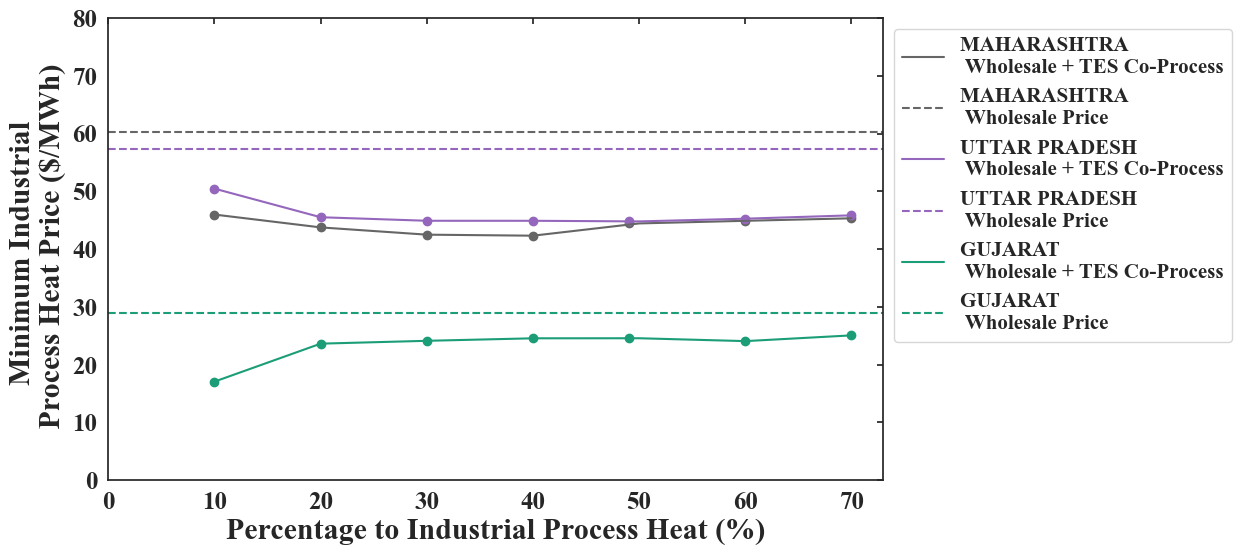

In [240]:
# EXPAND to all scenarios in 2 hr df under the different price profiles
#set xticklabels
plotparams()

fig, ax = plt.subplots(figsize=(10,6))


for priceprofile_name in ['MAHARASHTRA','UTTAR_PRADESH','GUJARAT']:

    xticklabels = []
    all_lcoe_df = pd.DataFrame()
    all_capex_df = pd.DataFrame()
    capex_MWh_list = []
    capex_MW_list = []
    x_list =  []
    coprocess_list = []
    elec_only_list = []
    gaps = []

    df_profile = df[[priceprofile_name in df.loc[i,'results_index'] for i in df.index]].reset_index(drop=True)
    #set the base, where there is no demand from local industry
    base = df_profile[df_profile['results_Q_ind']==0]['results_objective_value'].to_list()[0]
    
    for i in np.arange(len(df_profile)):   #set xtick labels as state 
        if True:#'2030' in df['results_index'][i]: #conditionality because of how you accidently made the price profiles
            #set parameters file
            param_fname = industrial_dir+df_profile['results_fname'][i][industrial_dir_index:]

            #set label, add to xticklabels
            label = df_profile['results_index'][i].replace('bayU5_2hrs_','').replace('.csv','').replace('_',' ')
            xticklabels.append(label)

            #read parameters file
            params_df = pd.read_csv(param_fname)

            TES_FOM = float(pd.read_csv(param_fname)['TES_FOM'][0])
            cost_HX_total = df_profile['results_cost_HX_1'][i]+df_profile['results_cost_HX_2'][i]+df_profile['results_cost_HX_3'][i]
            capex_df = pd.DataFrame({
                                    'Heat Exchanger':cost_HX_total,
                                    'Tank Cost':[df_profile['results_cost_tank'][i]],
                                    'Hot Pump':[df_profile['results_cost_hotpump'][i]],
                                    'Cold Pump':[df_profile['results_cost_coldpump'][i]],
                                    'Pipes and Valves':[df_profile['results_pipes_valves_cost'][i]],
                                    'Charger':[df_profile['results_charger_cost'][i]],
                                    'Industrial Heater':[df_profile['results_charger_cost'][i]],
                                    'Upgrade Cost': [df_profile['results_upgrade_cost'][i]*df['results_powerPeak'][i]],
                                    'TES Fixed O&M Cost':[df_profile['results_powerPeak'][i]*TES_FOM]
                                    })/1000 #million USD

            flowSalt_charge_t = df_profile['results_flowSalt_charge_t'][i]
            cost_energy_t = df_profile['results_cost_energy_t'][i]
            start_z_t = df_profile['results_start_z_t'][i]
            Q_heater_t = df_profile['results_q_heater_t'][i] #the electric heater for local ind load
            Q_steam_t = df_profile['results_q_turbind_t'][i] #the steam-turbine for local ind load
            powerOut_t = df_profile['results_net_discharge_t'][i]
            gap_analysis = df_profile['results_relative_gap'][i]

            w = df_profile['results_weights'][i]
            N = len(w)
            T = float(params_df['T'][0])
            start_cost = float(params_df['start_cost'][0])*float(params_df['powerPeak'][0])
            deltaT_salt = float(params_df['T_hot'][0]) -  float(params_df['T_cold'][0])
            cp = float(params_df['cp'][0])
            beta = float(params_df['beta'][0])
            gbi_subsidy = float(params_df['gbi_subsidy'][0])
            steam_eff = float(params_df['steam_eff'][0])
            x = float(params_df['x'][0])
            CRF = float(df['results_CRF'][i])

            #energy capacity (MWh_e)
            energy_capacity = df_profile['results_tank_energy_max'][i] * steam_eff

            #power capacity (MW_e)
            power_capacity = df_profile['results_powerPeak'][i] 

            #metrics for capex
            total_capex = capex_df.T.sum()*1000000*CRF
            capex_MWh = total_capex/energy_capacity
            capex_MW = total_capex/power_capacity

            #save 
            x_list = np.append(x_list, x)
            capex_MWh_list = np.append(capex_MWh_list,capex_MWh)
            capex_MW_list = np.append(capex_MW_list,capex_MW)
            gaps = np.append(gaps,gap_analysis)


            #annual generation 
            #dispatch = sum([sum(powerOut_t.iloc[:,n])*w[n] for n in np.arange(N)])
            dispatch = df_profile['results_TES_dispatch'][i]

            #start costs 
            lcoe_start = sum([sum(start_z_t.iloc[:,n])*start_cost*w[n] for n in np.arange(N)])

            #charging costs
            lcoe_charging = sum([sum(deltaT_salt*cp*flowSalt_charge_t.iloc[:,n]/beta * cost_energy_t[n])*w[n] for n in np.arange(N)])

            #heater costs (industrial)
            lcoe_industrial_heat = 0

            #revenue
            #revenue = -1*sum([sum(powerOut_t.iloc[:,n] * cost_energy_t[n])*w[n] for n in np.arange(N)])
            revenue = df_profile['results_TES_revenue'][i]

            #subsidy
            subsidy = 0

            #profits
            profit = df_profile['results_objective_value'][i]*dispatch

            annualized_capex = capex_df.T.sum()[0]*CRF*1000 #get it back to $1k MWh
            capex_npv = capex_df.T.sum()

            # discount_rate = 0.08
            # age = 25
            #dipatch 
            TES_ind = sum([sum(Q_steam_t[n])*w[n] for n in np.arange(N)]) #MWh_t
            TES_elec = sum([sum(Q_heater_t[n])*w[n] for n in np.arange(N)]) #MWh_t

            #TES_ind = 
            # ind_total = sum([sum(float(df['results_Q_ind'][x]))*w[n] for n in np.arange(N)])
            #print(x,'local TES:', TES_ind, 'heater:', TES_elec)


            #plt.scatter(int(x*100),(10982277.234152569 - npf.npv(discount_rate, np.append(capex_npv[0]*-1000000,np.ones(age)*(lcoe_start+lcoe_charging+lcoe_industrial_heat+revenue)*-1000)))/TES_ind,color="teal")
            #electricity_heat_cost = sum([sum(float(df['results_Q_ind'][x]) * pd.Series(cost_energy_t[n]))*w[n] for n in np.arange(N)])*1000/ind_total
            #electricity_heat_cost = sum([sum(Q_heater_t[n] * pd.Series(cost_energy_t[n]))*w[n] for n in np.arange(N)])
            electricity_heat_cost = df_profile['results_TES_indheater_costs'][i]
            electricity_only_cost = sum([sum(df_profile['results_Q_ind'][i] * pd.Series(cost_energy_t[n]) / beta)*w[n] for n in np.arange(N)]) 
            electricity_only_dispatch = df_profile['results_Q_ind'][i]*8736
            print('percentage: ', x,'\n local TES:', TES_ind, '\n heater:', TES_elec, '\n elec only:',electricity_only_dispatch)


            if x == 0: 
                base2 = df_profile['results_objective_value'][i]
                coprocess_list= np.append(coprocess_list, 0)
                elec_only_list= np.append(elec_only_list, 0)
            elif TES_ind == 0:  ### change this!
                print(x, TES_ind)
                coprocess_list= np.append(coprocess_list, 0)
                elec_only_list= np.append(elec_only_list, 0)
            else:
                #the objective value of no supplying any heat, just the coal plant as standalone TES
                coprocess = (base - (df_profile['results_objective_value'][i]-df_profile['results_charger_cost'][i]-electricity_heat_cost))*-1000/TES_ind
                coprocess_list= np.append(coprocess_list, coprocess)

                elec_only = electricity_only_cost*1000/electricity_only_dispatch
                elec_only_list= np.append(elec_only_list, elec_only)

                #plotting  

                ax.scatter(int(x*100),coprocess,color = color_map[priceprofile_name.replace('_',' ')+'.csv']['color'])
                #ax.scatter(int(x*100),elec_only,alpha=0)
                #print(df_profile['results_objective_value'][i])
                
            lcoe_df = pd.DataFrame({
                                    'Start-Up Costs':[lcoe_start],
                                    'Charging Costs':[lcoe_charging],
                                    'Industrial Electric Heater Costs':[lcoe_industrial_heat],
                                    'Annualized Capital Cost':[annualized_capex],
                                    'Revenue':[revenue],
                                    'Profits':[profit]
                                    })*1000/dispatch #get it to $/MWh

            ## Simple Coal Plant Profits under same price profile
            dischargepowerPeak = float(params_df['powerPeak'][0])
            coal_FOM = float(params_df['coal_FOM'][0])*dischargepowerPeak
            emissions_rate = float(params_df['emissions_rate'][0])
            coal_fuel_cost = float(params_df['coal_fuel_cost'][0]) 
            coal_VOM = float(params_df['coal_VOM'][0]) 
            carbon_price = float(params_df['carbon_price'][0]) 

            #marginal cost with carbon price (if set)
            # coal_MC = coal_VOM+coal_fuel_cost + carbon_price*emissions_rate #$1k/MWh 

            # coal_revenue_total = sum([sum(dischargepowerPeak * pd.Series(cost_energy_t[n])[pd.Series(cost_energy_t[n])>coal_MC])*w[n] for n in np.arange(N)])
            # coal_cost_total = sum([(dischargepowerPeak * sum(pd.Series(cost_energy_t[n])>coal_MC)*coal_MC)*w[n] for n in np.arange(N)])

            # coal_profits = (coal_cost_total+coal_FOM) - coal_revenue_total #$1k per year

            #add labels
            lcoe_df['Name'] = label
            capex_df['Name'] = label

            #appending dfs
            all_lcoe_df = all_lcoe_df.append(lcoe_df)
            all_capex_df = all_capex_df.append(capex_df)

    all_lcoe_df.set_index('Name',inplace=True)
    all_capex_df.set_index('Name',inplace=True);

    rcParams["font.family"] = "Times New Roman"
    rcParams["font.weight"] = "bold"
    rcParams["font.size"] = "18"

    sns.set(style='white')
    plt.xlim(left=0)
    plt.ylim(bottom=0,top=80)

    coprocess_df = pd.DataFrame({'x':x_list*100, 'coprocess':coprocess_list}).sort_values(by='x')[1:].reset_index(drop=True)
    ax.plot(coprocess_df['x'],coprocess_df['coprocess'],label=priceprofile_name.replace('_',' ') + ' \n Wholesale + TES Co-Process',color=color_map[priceprofile_name.replace('_',' ')+'.csv']['color'])

    elec_df = pd.DataFrame({'x':x_list*100, 'elec':elec_only_list}).sort_values(by='x')[1:].reset_index(drop=True)
    #plot a dotted line for reference value
    ax.axhline(y = elec_df['elec'][0], linestyle='--', label=priceprofile_name.replace('_',' ')+ ' \n Wholesale Price' , color=color_map[priceprofile_name.replace('_',' ')+'.csv']['color'])

    #plt.tick_params(labelsize=fs)
    #label='Grid-supplied Industrial Process Cost'

    for tick in ax.get_xticklabels():
        tick.set_fontname("Times New Roman")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Times New Roman")


    #plot modifications
    #plt.title('Break-even price for industrial process heat',fontsize=fs)
    plt.xlabel('Percentage to Industrial Process Heat (%)',fontname='Times New Roman')
    plt.ylabel('Minimum Industrial \n Process Heat Price ($/MWh)',fontname='Times New Roman')
    plt.legend(prop=font,ncols=1,bbox_to_anchor=(1,1))


    #save figure
    plt.savefig('figures/figures/industrial/industrial_BEP',bbox_inches='tight',dpi=1000);
    plt.savefig('figures/figures/industrial/industrial_BEP.svg',format='svg')


# 9. Price Profile Sensitivity 

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_capex_df = all_capex_df.append(capex_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_lcoe_df = all_lcoe_df.append(lcoe_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4101995396.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

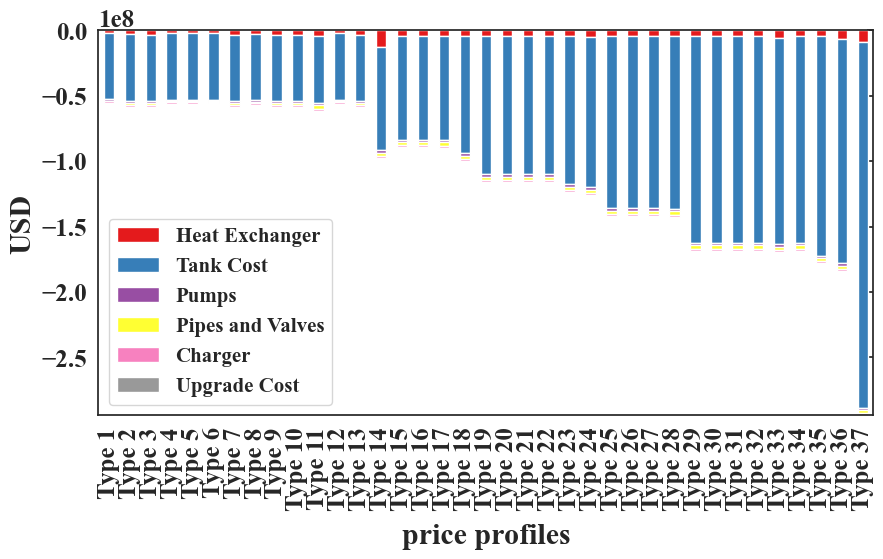

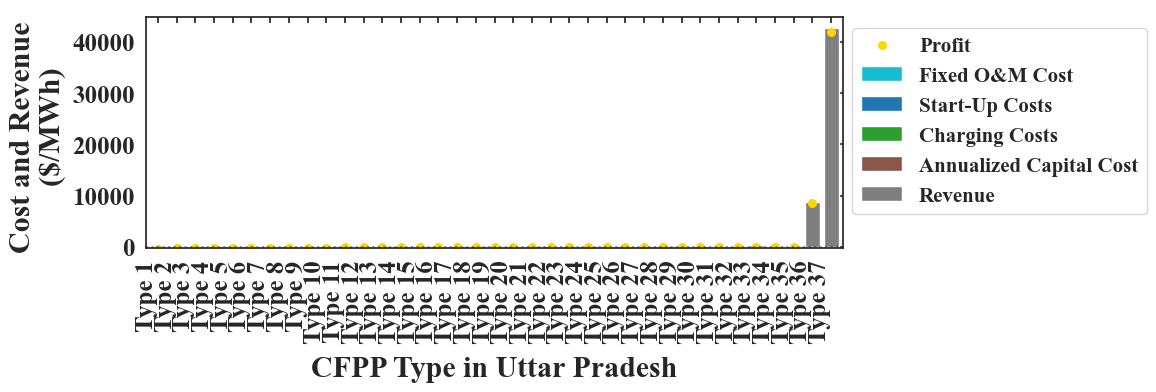

In [243]:
bottomup_dir = 'RESULTS/bottomup/'
bottomup_dir_index = 40

bottomup_scenarios_dict = create_sensitivity_dict(bottomup_dir)
bottomup_min_hours_dict = create_UP_min_hours_dict(bottomup_scenarios_dict,bottomup_dir,bottomup_dir_index)

#set download paths
bottomup_path_data_download = 'figures/data/bottomup/'
bottomup_path_figures_download  = 'figures/figures/bottomup/'

#download the data
download_dfs(bottomup_min_hours_dict,2,bottomup_path_data_download,bottomup_dir_index,bottomup_dir) ## set the others as global

#plot CAPEX 
#read in df_capex
df_capex = pd.read_csv(bottomup_path_data_download+'CAPEX.csv') ## check the units on this function
#select columns
CAPEX_columns  = ['Name','Heat Exchanger', 'Tank Cost', 'Pumps', 'Pipes and Valves', 'Charger', 'Upgrade Cost'] 
#plot
plotting_capex(df_capex,CAPEX_columns,bottomup_path_figures_download)

plt.xlabel('price profiles') 

#plot LCOE
#read in df_lcoe
df_lcoe = pd.read_csv(bottomup_path_data_download+'LCOE.csv')
#select columns
LCOE_columns = ['Name', 'Start-Up Costs', 'Charging Costs',
       'Annualized Capital Cost',
       'Revenue', 'Fixed O&M Cost']
#plot
plotting_LCOE(df_lcoe,LCOE_columns,bottomup_path_figures_download)

## 9.1: Metrics on price scenarios

In [248]:
## datasets
iex2019= pd.read_csv("data/prices_fullyear/IEX2019_fullyear.csv")
iex2021= pd.read_csv("data/prices_fullyear/IEX2021_fullyear.csv")
MH_2030 = pd.read_csv("data/NREL_2030_fullyear_profiles/MAHARASHTRA.csv")
GJ_2030 = pd.read_csv("data/NREL_2030_fullyear_profiles/GUJARAT.csv")
UP_2030 = pd.read_csv("data/NREL_2030_fullyear_profiles/UTTAR PRADESH.csv")
HY_2030 = pd.read_csv("data/NREL_2030_fullyear_profiles/HARYANA.csv")
OS_2030 = pd.read_csv("data/NREL_2030_fullyear_profiles/ODISHA.csv")

## 
iex2019_data =iex2019['AVG(dam_price)']
iex2021_data =iex2021['AVG(dam_price)']

MH_2030_data = MH_2030.Value
GJ_2030_data = GJ_2030.Value
UP_2030_data = UP_2030.Value
HY_2030_data = HY_2030.Value
OS_2030_data = OS_2030.Value



## define the funciton
def price_profile_stats(data):
    print('less than 5: % ', (sum(data<5)/len(data)*100))
    print('greater than 200:% ', sum(data>200)/len(data)*100)
    print('std: ', np.std(data))
    print('mean: ', np.mean(data))

print('2019')
price_profile_stats(iex2019_data)
print('\n 2021')
price_profile_stats(iex2021_data)
print('\n Maharashtra')
price_profile_stats(MH_2030_data)
print('\n Gujarat')
price_profile_stats(GJ_2030_data)
print('\n Uttar Pradesh')
price_profile_stats(UP_2030_data)
print('\n Haryana')
price_profile_stats(HY_2030_data)
print('\n Odisha')
price_profile_stats(OS_2030_data)

2019
less than 5: %  0.0
greater than 200:%  0.0
std:  11.227138535992863
mean:  39.09585976956578

 2021
less than 5: %  0.0
greater than 200:%  1.495433789954338
std:  33.74628399957129
mean:  49.441638477943464

 Maharashtra
less than 5: %  1.1217948717948718
greater than 200:%  1.4423076923076923
std:  27.417128517376003
mean:  52.770620672136445

 Gujarat
less than 5: %  32.01694139194139
greater than 200:%  0.8928571428571428
std:  29.703381908543477
mean:  26.67267486855632

 Uttar Pradesh
less than 5: %  0.8241758241758242
greater than 200:%  2.152014652014652
std:  30.304923342071113
mean:  55.93684552682108

 Haryana
less than 5: %  0.8241758241758242
greater than 200:%  2.0604395604395602
std:  29.926246018530634
mean:  56.099916808017866

 Odisha
less than 5: %  0.8241758241758242
greater than 200:%  0.8470695970695971
std:  24.238673124742263
mean:  39.96006487381333


## 9.2: Durations

In [249]:
##  durations

min_hour = 2

#get the df of results for one sensitivity determined in the setup above
df = pd.DataFrame(bottomup_min_hours_dict[np.round(min_hour,1)]).T.reset_index()

#rename all the columnsn in the results df to results_{name}
for col_name in df.columns:
    df.rename(columns={col_name:'results_'+col_name},inplace=True)
    
durations_bottomup = df['results_tank_energy_max']*df['results_steam_eff']/ df['results_powerPeak']

profitable_df = df[df['results_objective_value']<0]
durations_bottomup_profitable = profitable_df['results_tank_energy_max']*profitable_df['results_steam_eff']/ profitable_df['results_powerPeak']



Text(0, 0.5, 'Duration (hr)')

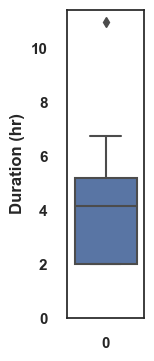

In [250]:
plt.figure(figsize=(1,4))
sns.boxplot(data = durations_bottomup)
plt.ylim(bottom=0) 
plt.ylabel('Duration (hr)')

## 9.3: Price scenario plots 

In [253]:
dir = 'data/NREL_2030_fullyear_profiles/'
price_files = [item for item in os.listdir(dir)]

In [254]:
#select which ones to remove
price_files.remove('BANGLADESH.csv')
price_files.remove('CHANDIGARH.csv')
price_files.remove('NEPAL.csv')
price_files.remove('DADRA & NAGAR HAVELI.csv')

price_files.remove('BHUTAN.csv')
price_files.remove('ARUNACHAL PRADESH.csv')
price_files.remove('DELHI.csv')
price_files.remove('GOA.csv')
price_files.remove('HIMACHAL PRADESH.csv')
price_files.remove('JAMMU & KASHMIR.csv')
price_files.remove('KERALA.csv')

price_files.remove('MANIPUR.csv')

price_files.remove('MEGHALAYA.csv')

price_files.remove('MIZORAM.csv')
price_files.remove('NAGALAND.csv')
price_files.remove('PUDUCHERRY.csv')
price_files.remove('UTTARAKHAND.csv')
price_files.remove('DAMAN & DIU.csv')
price_files.remove('TRIPURA.csv')

In [255]:
#creating map with colors

#strip csv name in price files array
price_files_array = [price_files[i].replace('.csv','').replace(' &','').replace(' ','_').upper() for i in np.arange(len(price_files))]

#get mapped to region 
state_region_df = pd.read_csv('India_shape/hierarchy_state_zone.csv')

state_region_df["0"] = [state_region_df["0"][i].upper() for i in np.arange(len(state_region_df))]

state_region_df.rename({"1":"region"},axis=1,inplace=True)

#make the full region names
regionname_dict = {'WR':'Western Region','ER':'Eastern Region','NER':'Northeastern Region','SR':'Southern Region','NR':'Northern Region'}
regions_lst = state_region_df["region"]
state_region_df['FullRegionName'] = [*map(regionname_dict.get, regions_lst)]

#set colors
cm = mpl.colormaps['Dark2'].resampled(5)
cm_5 = cm(range(5))
#manually setting the colors
#region_color = {'WR':'tan','ER':'turquoise','NER':'orchid','SR':'salmon','NR':'olive'}
region_color = {'WR':cm_5[0],'ER':cm_5[1],'NER':cm_5[2],'SR':cm_5[3],'NR':cm_5[4]}

#initialize color map dictionary
color_map = dict(zip(price_files,price_files_array))

#populate
for key in color_map.keys():
    for i in np.arange(len(state_region_df)):
        name = color_map[key]
        if name == state_region_df["0"][i]:
            region = state_region_df["region"][i]
            color = region_color[region]
            region_name = state_region_df["FullRegionName"][i]
            color_map[key] = {'name':name,'color':color,'label':region_name}

In [256]:
cm = mpl.colormaps['Dark2'].resampled(5)
cm(range(5))

array([[0.10588235, 0.61960784, 0.46666667, 1.        ],
       [0.45882353, 0.43921569, 0.70196078, 1.        ],
       [0.4       , 0.65098039, 0.11764706, 1.        ],
       [0.65098039, 0.4627451 , 0.11372549, 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ]])

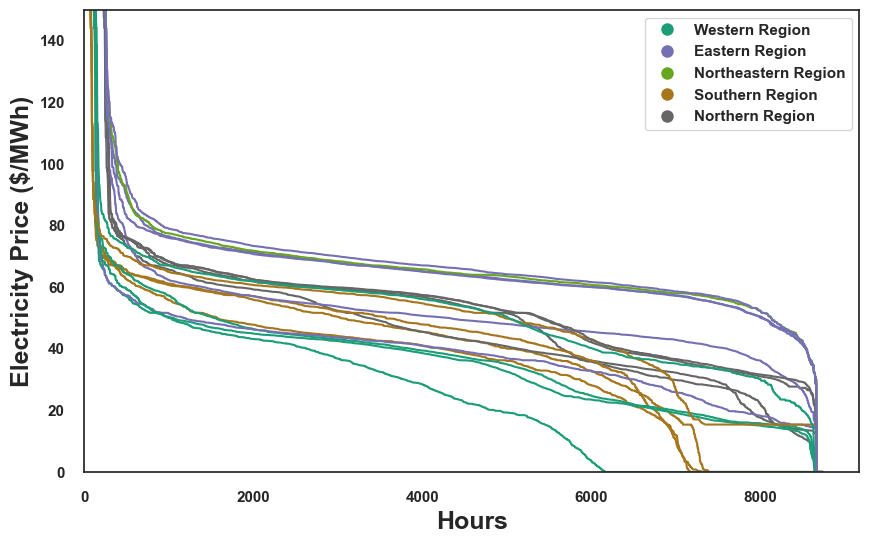

In [257]:


plt.figure(figsize = (10,6))

prices = []

for price_file in price_files:
    price_df = pd.read_csv(dir+price_file).sort_values(by='Value',ascending=False).reset_index(drop=True)
    #print(price_file, np.mean(price_df)
    price_file_dict = color_map[price_file]

    if type(price_file_dict) != dict:
        print(color_map[price_file])

    else:
        price_df['interval'] = 1
        price_df['Duration'] = price_df['interval'].cumsum()
        #print(max(price_df['Value']))
        plt.plot(price_df['Duration'], price_df['Value'], color = price_file_dict['color'], label = price_file_dict['label'])
        prices = prices + list(price_df['Value'])

plt.ylim(0,150)
plt.xlabel('Hours',fontsize=fs)
plt.ylabel('Electricity Price ($/MWh)',fontsize =fs)
plt.xlim(0)
sns.set(style="white")
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_color[key], markersize=10) for key in region_color.keys()]
plt.legend(handles=legend_elements, labels=regionname_dict.values())

plt.savefig('figures/figures/duration')

PUNJAB
Empty DataFrame
Columns: [Value, interval, Duration]
Index: []
ANDHRA_PRADESH
Empty DataFrame
Columns: [Value, interval, Duration]
Index: []
TAMIL_NADU
Empty DataFrame
Columns: [Value, interval, Duration]
Index: []
RAJASTHAN
Empty DataFrame
Columns: [Value, interval, Duration]
Index: []
KARNATAKA
Empty DataFrame
Columns: [Value, interval, Duration]
Index: []
CHHATTISGARH
Empty DataFrame
Columns: [Value, interval, Duration]
Index: []
GUJARAT
Empty DataFrame
Columns: [Value, interval, Duration]
Index: []
MAHARASHTRA
Empty DataFrame
Columns: [Value, interval, Duration]
Index: []


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1606242824.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prices_all_stats_df = prices_all_stats_df.append(prices_stats_df).reset_index(drop=True)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1606242824.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prices_all_stats_df = prices_all_stats_df.append(prices_stats_df).reset_index(drop=True)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1606242824.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prices_all_stats_df = prices_all_stats_df.append(prices_stats_df).reset_index(drop=True)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1606242824.py:

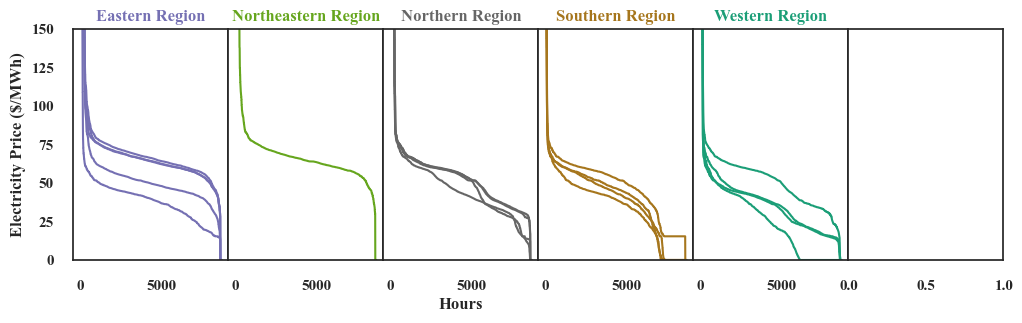

In [258]:
rcParams["font.family"] = "Times New Roman"
rcParams["font.size"] = "12"
fig = plt.figure(figsize=(12,3))
gs = fig.add_gridspec(1, 6, wspace=0)
(ax1, ax2, ax3, ax4, ax5,ax6) = gs.subplots( sharey=True)
plt.ylim(0,150)
ax3.set_xlabel('Hours')
ax1.set_ylabel('Electricity Price ($/MWh)')
plt.xlim(0)

#set this price_stats dataframe
prices_all_stats_df = pd.DataFrame()

#set the upper and lower bounds as these percentiles for ALL profiles 
lower_bound = round(np.percentile(prices,5))
upper_bound = round(np.percentile(prices,95))        

for price_file in price_files:
    price_df = pd.read_csv(dir+price_file).sort_values(by='Value',ascending=False).reset_index(drop=True)
    #print(price_file, np.mean(price_df)
    price_file_dict = color_map[price_file]

    if type(price_file_dict) != dict:
        print(color_map[price_file])

    else:
        #initialize
        prices_stats_df = pd.DataFrame()

        price_df['interval'] = 1
        price_df['Duration'] = price_df['interval'].cumsum()

        #checking and seeing which ones have large negatives
        if sum(price_df['Value']<0)>0:
            print(color_map[price_file]['name'])
            print(price_df[price_df['Value']<-5])
        
        if price_file_dict['label'] == 'Eastern Region':
            ax1.plot(price_df['Duration'], price_df['Value'], color = price_file_dict['color'], label = price_file_dict['label'])
            ax1.set_title('Eastern Region',color=price_file_dict['color'],fontweight='bold',font="Times New Roman")
        if price_file_dict['label'] == 'Northeastern Region':
            ax2.plot(price_df['Duration'], price_df['Value'], color = price_file_dict['color'], label = price_file_dict['label'])
            ax2.set_title('Northeastern Region',color=price_file_dict['color'],fontweight='bold',font="Times New Roman")
        if price_file_dict['label'] == 'Northern Region':
            ax3.plot(price_df['Duration'], price_df['Value'], color = price_file_dict['color'], label = price_file_dict['label'])
            ax3.set_title('Northern Region',color=price_file_dict['color'],fontweight='bold',font="Times New Roman")
        if price_file_dict['label'] == 'Southern Region':
            ax4.plot(price_df['Duration'], price_df['Value'], color = price_file_dict['color'], label = price_file_dict['label'])
            ax4.set_title('Southern Region',color=price_file_dict['color'],fontweight='bold',font="Times New Roman")
        if price_file_dict['label'] == 'Western Region':
            ax5.plot(price_df['Duration'], price_df['Value'], color = price_file_dict['color'], label = price_file_dict['label'])
            ax5.set_title('Western Region',color=price_file_dict['color'],fontweight='bold',font="Times New Roman")

        #stats for this price profile 
        total_hours = len(price_df)

        #add the price Profile name
        prices_stats_df['Name'] = [str(price_file_dict['name'])]
        #print( str(price_file_dict['name']) )

        prices_stats_df['Pct below lower price'] = [int(sum(price_df['Value'] < lower_bound)/total_hours * 100)]
        prices_stats_df['Pct above upper price'] = [int(sum(price_df['Value'] > upper_bound)/total_hours * 100)]

        #getting the other price stats
        prices_describe = price_df.describe(include='all').Value

        for i_name in prices_describe.index:
            #add this column to the df
            prices_stats_df[i_name] = [prices_describe.loc[i_name]]
        
        prices_all_stats_df = prices_all_stats_df.append(prices_stats_df).reset_index(drop=True)



sns.set(style="white")
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_color[key], markersize=10) for key in region_color.keys()]
# plt.legend(handles=legend_elements, labels=regionname_dict.values(),loc='upper right')

plt.savefig('figures/figures/duration',dpi=1000, bbox_inches='tight')


## 9.4: Statistics Table

In [259]:
#rename the columns if you like

#round the values
prices_all_stats_df=round(prices_all_stats_df)

#drop the 'count' column
prices_all_stats_df.drop('count',axis=1,inplace=True)

#save the stats table to excel file 
prices_all_stats_df.to_excel('data/stats_priceprofiles.xlsx')


## 9.5 Make map of regions 

In [260]:
#create a column for the name of the state to the region by region code (then can re-use region colors dicitonary by region code)
state_region_df['State'] = [state_region_df.loc[i,'0'].lower() for i in np.arange(len(state_region_df))]
state_region_df

map_df['Region'] = [state_region_df[state_region_df.loc[:,'State']==map_state]['region'].to_list() for map_state in map_df.STATE]
#making only regions and capacities with color
map_df['Region'] = [map_df.loc[i,'Region'][0] if (len(map_df.loc[i,'Region'])>0) & (map_df.loc[i,'Capacity']>0) else '' for i in np.arange(len(map_df))]

#some odd ones out
map_df.loc[map_df['STATE']=='dadra_nagar_haveli_daman_diu']['Region']='WR'
map_df.loc[map_df['STATE']=='jammu_and_kashmir']['Region']='NR'
#map_df.loc[map_df['STATE']=='ladakh']['Region']='NR'



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [261]:
map_df.loc[7,'Region']='WR'
map_df.loc[17,'Region']='NR'

In [262]:
map_df['Region'] = [map_df['Region'][i] if map_df['Capacity'][i]>0 else '' for i in np.arange(len(map_df)) ]

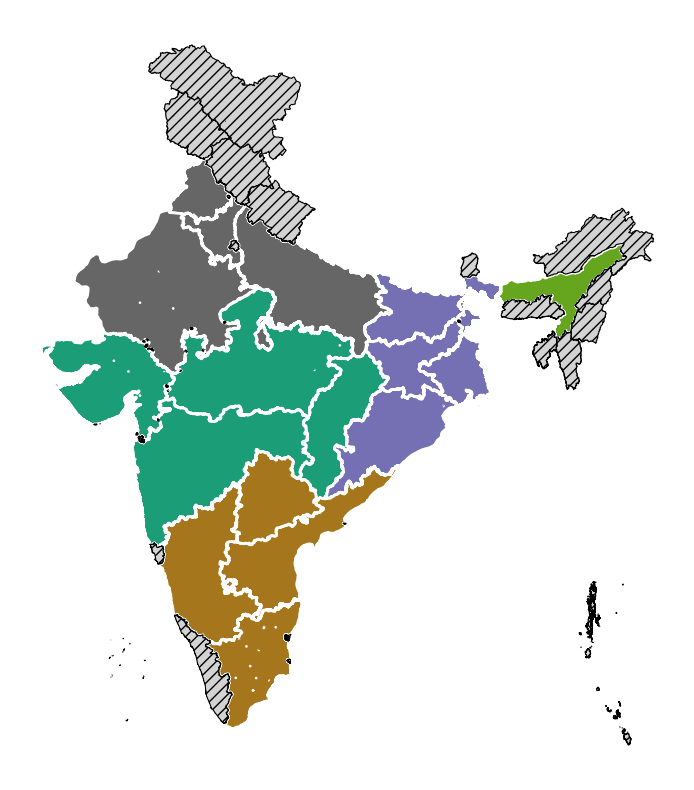

In [263]:
# #
plotparams()

# # create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')

# #plot UP outline in a different color
for region_abbr in region_color.keys():

    NR_df = map_df[map_df['Region']==region_abbr]
    NR_df.plot(linewidth=2, ax=ax, color =region_color[region_abbr],markersize=[39.739192, -104.990337])

# # plots for if null is 0 
null_df = map_df[map_df['Region']=='']
null_df.plot(color='lightgray',linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337],hatch='///')


# # Plot the disputed territories data
disputed_territories_data.plot(ax=ax, color='black',linewidth=2, edgecolor='black',hatch='///')


# save figure
fig.savefig('figures/figures/states_regions_map',dpi=1400)


# # Show the map
plt.show()




## 9.6: Download and Defining Plotting Functions

In [264]:
#picking the 2 hours case (CHANGE IF NEEDED)
dir = 'RESULTS/bottomup/'
dir_index = 40

df = pd.DataFrame(bottomup_min_hours_dict[np.round(2,1)]).T.reset_index()

 #rename all the columnsn in the results df to results_{name}
for col_name in df.columns:
    df.rename(columns={col_name:'results_'+col_name},inplace=True)
df.sort_values(by='results_tank_energy_max',inplace=True)


In [265]:
# #LCOE stacked bars with overlay
df_lcoe = pd.read_csv('figures/data/bottomup/LCOE.csv')

In [266]:
#get the names of the states w/ capacity greater than 0
states_0 = map_df[map_df['Capacity'] > 0 ]['STATE']

In [267]:
#grouping these into a few key categories:
df_lcoe['Operational Cost'] = df_lcoe['Start-Up Costs'] + df_lcoe['Charging Costs']
df_lcoe['Capital Cost'] =  df_lcoe.iloc[:,6:].sum(axis=1)

df_lcoe['states'] = [df_lcoe.loc[i,'Name'].lower().replace(' ','_') .replace('__','_') for i in np.arange(len(df_lcoe))]
df_lcoe['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list() for state_name in df_lcoe.states]

In [268]:
lcoe_india = df_lcoe[(df_lcoe['Name']!='CHANDIGARH')&(df_lcoe['Name']!='BANGLADESH') & (df_lcoe['Name']!='NEPAL') 
                    & (df_lcoe['Name']!='BHUTAN') 
                    & (df_lcoe['Name']!='ARUNACHAL PRADESH') 
                    & (df_lcoe['Name']!='DADRA  NAGAR HAVELI') 
                    & (df_lcoe['Name']!='DELHI') 
                    & (df_lcoe['Name']!='GOA') 
                    & (df_lcoe['Name']!='HIMACHAL PRADESH') 
                    & (df_lcoe['Name']!='JAMMU  KASHMIR') 
                    & (df_lcoe['Name']!='KERALA') 
                    & (df_lcoe['Name']!='LADAKH') 
                    & (df_lcoe['Name']!='LAKSHADWEEP') 
                    & (df_lcoe['Name']!='MANIPUR') 
                    & (df_lcoe['Name']!='MEGHALAYA') 
                    & (df_lcoe['Name']!='MIZORAM') 
                    & (df_lcoe['Name']!='NAGALAND') 
                    & (df_lcoe['Name']!='PUDUCHERRY') 
                    & (df_lcoe['Name']!='UTTARAKHAND')
                    & (df_lcoe['Name']!='DAMAN  DIU')
                    & (df_lcoe['Name']!='TRIPURA')]



lcoe_india['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list()[0] for state_name in lcoe_india.states]
lcoe_india.sort_values(['state_region','Profits'],inplace=True)

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4160471452.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcoe_india['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list()[0] for state_name in lcoe_india.states]
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/4160471452.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcoe_india.sort_values(['state_region','Profits'],inplace=True)


In [269]:


#sort by the mean
quant_cols = lcoe_india.mean().sort_values().index.to_list()
columns_reindexed=quant_cols+['Name','states','state_region']

lcoe_india=lcoe_india.reindex(columns_reindexed, axis=1)

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1472109138.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  quant_cols = lcoe_india.mean().sort_values().index.to_list()


In [270]:
lcoe_india.columns

Index(['Capital Cost', 'Annualized Capital Cost', 'Profits',
       'Operational Cost', 'Fixed O&M Cost', 'Tank Cost', 'Charging Costs',
       'Start-Up Costs', 'Heat Exchanger', 'Pipes and Valves', 'Pumps',
       'Charger', 'Industrial Electric Heater Costs', 'Revenue', 'Name',
       'states', 'state_region'],
      dtype='object')

In [271]:
def append_row(df, row):
    return pd.concat([
                df, 
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

new_row = pd.Series({'Tank Cost':0, 'Capital Cost':0, 'Annualized Capital Cost':0, 'Profits':0,
       'Operational Cost':0, 'Fixed O&M Cost':0, 'Charging Costs':0,
       'Heat Exchanger':0, 'Pipes and Valves':0, 'Pumps':0, 'Charger':0,
       'Start-Up Costs':0, 'Industrial Electric Heater Costs':0, 'Revenue':0, 'Name':'',
       'states':'', 'state_region':'NER'})



/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3452634567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Other'] = data.loc[:,['Pipes and Valves',
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3452634567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Other'] = data.loc[:,['Pipes and Valves',
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3452634567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

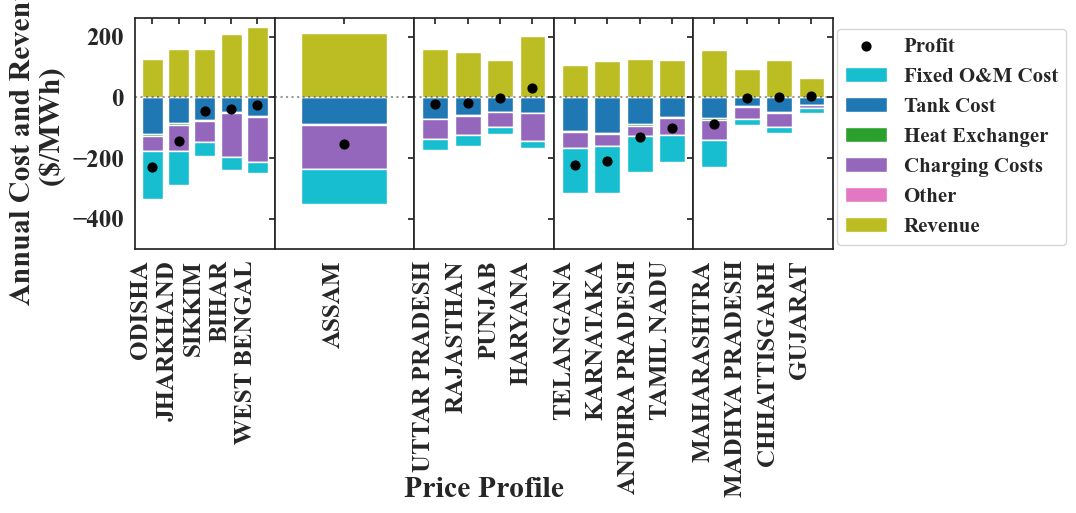

In [272]:
# define plotting function
plotparams()



fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(1, 5, wspace=0)
(ax1, ax2, ax3, ax4, ax5) = gs.subplots( sharey=True)


def plotting_bottomup_LCOE(data,ax):

    
    
    data['Other'] = data.loc[:,['Pipes and Valves',
        'Charger', 'Pumps','Start-Up Costs']].sum(axis=0)
    
    columns = [
      'Tank Cost','Heat Exchanger',
       'Charging Costs','Other',
       'Revenue', 'Fixed O&M Cost','Name'
       ]

    cost_data = data.loc[:,columns]
    cost_data.plot(kind='bar',stacked = True, x = 'Name', colormap='tab10',xlabel=None, legend=False,width=0.8,ax=ax)
    
    if ax==ax5:
        label='Profit'
    else:
        label=None
    data.plot(kind='scatter',x = 'Name', y = 'Profits',color= 'black',xlabel = None,label=label, ax=ax,s=40)
    ax.axhline(y=0,color='black',alpha=0.4,ls=':')
    ax.set_xlabel(None)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)



    

#set plot style
sns.set(style="white")

columns = ['Tank Cost', 'Capital Cost', 'Annualized Capital Cost', 'Profits',
       'Operational Cost', 'Fixed O&M Cost', 'Charging Costs', 'Heat Exchanger',
       'Pipes and Valves', 'Pumps', 'Charger', 'Start-Up Costs',
       'Industrial Electric Heater Costs', 'Revenue', 'Name', 'states',
       'state_region']

df_lcoe_filtered = lcoe_india.loc[:,columns].reset_index(drop=True)


for state_region in df_lcoe_filtered['state_region'].unique():
    #if state_region_data Capacity is greater than 0 
    state_region_data = df_lcoe_filtered[df_lcoe_filtered.state_region==state_region]
    if state_region == 'ER':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax2)
    if state_region == 'NR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax3)
    if state_region == 'SR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax4)
    if state_region == 'WR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax5)




ax1.set_ylabel('Annual Cost and Revenue \n  ($/MWh)')
ax3.set_xlabel('Price Profile')

handles_legend, labels_legend = ax5.get_legend_handles_labels()
ax5.legend([handles_legend[0]]+[handles_legend[-1]]+handles_legend[1:-1], [labels_legend[0]]+[labels_legend[-1]]+labels_legend[1:-1], loc='upper right',bbox_to_anchor=(2.75, 1),prop=font)
plt.ylim(bottom=-500)

plt.savefig('figures/figures/bottomup/LCOS_priceprofiles', bbox_inches='tight',dpi=1000)
plt.savefig('figures/figures/bottomup/LCOS_priceprofiles.svg',format='svg')




In [285]:
dir='data/NREL_2030_fullyear_profiles/'

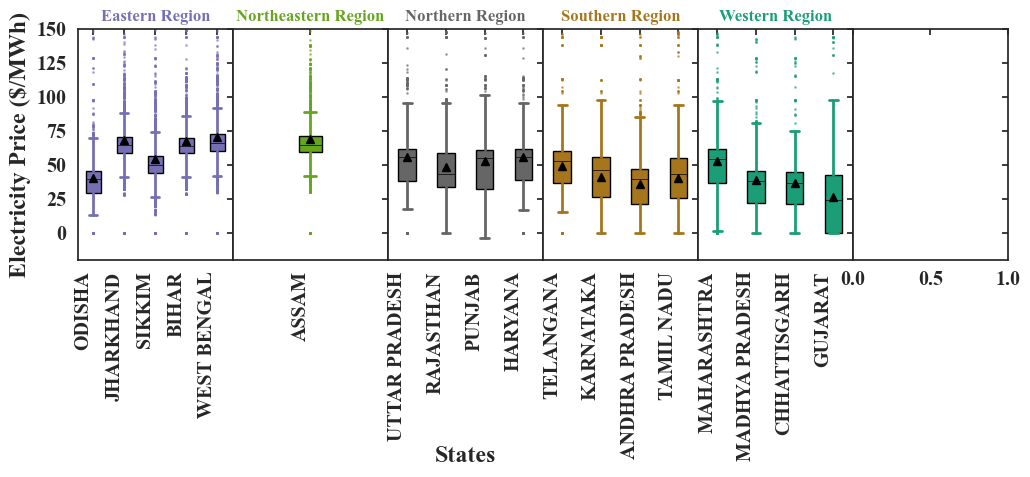

In [286]:
def plotting_duration(data,ax):

    regional_prices_df = pd.DataFrame()
    for state_name in list(data.Name):
        price_file = state_name+'.csv'
        price_file_dict = color_map[price_file]
        price_df = pd.read_csv(dir+price_file)
        #add price data to the regional df
        regional_prices_df[state_name]=price_df.Value

    regional_prices_df.plot(kind='box',ax=ax,
                capprops = dict(color =price_file_dict['color'], linewidth = 2),
                whiskerprops = dict(color = price_file_dict['color'], linewidth = 2),
                medianprops = dict(color = "black", linewidth = 0.5),
                flierprops = dict(marker='o', markerfacecolor= price_file_dict['color'], markeredgecolor= price_file_dict['color'],markersize=1,alpha=0.5),
                patch_artist = True,
                boxprops = dict(facecolor = price_file_dict['color']),
                showmeans=True,
                meanprops=dict(markeredgecolor='black',
                      markerfacecolor='black'))
    ax.set_title(price_file_dict['label'],color=price_file_dict['color'],fontweight='bold',font="Times New Roman")
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)




rcParams["font.family"] = "Times New Roman"
rcParams["font.size"] = "12"
fig = plt.figure(figsize=(12,3))
gs = fig.add_gridspec(1, 6, wspace=0)
(ax1, ax2, ax3, ax4, ax5,ax6) = gs.subplots( sharey=True)
plt.ylim(-20,150)
ax3.set_xlabel('States')
ax1.set_ylabel('Electricity Price ($/MWh)')
plt.xlim(0)

for state_region in df_lcoe_filtered['state_region'].unique():
    state_region_data = df_lcoe_filtered[df_lcoe_filtered.state_region==state_region]
    if state_region == 'ER':
        plotting_duration(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_duration(data=state_region_data,ax=ax2)
    if state_region == 'NR':
        plotting_duration(data=state_region_data,ax=ax3)
    if state_region == 'SR':
        plotting_duration(data=state_region_data,ax=ax4)
    if state_region == 'WR':
        plotting_duration(data=state_region_data,ax=ax5)

sns.set(style="white")

plt.savefig('figures/figures/boxplots',dpi=1000, bbox_inches='tight')




In [ ]:
percentiles = np.percentile(price_df.Value, [25, 50, 75])
percentiles

array([58.61907962, 64.05893801, 70.09413939])

In [287]:
len(price_df[(price_df.Value>=0) & (price_df.Value<5)]) / len(price_df) * 100 

0.8241758241758242

<Axes: >

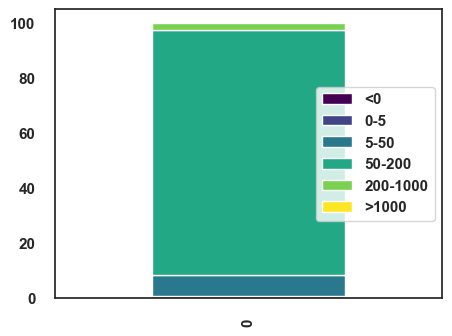

In [288]:

price_bands_df = pd.DataFrame()
#less than 0
price_bands_df['<0'] = [len(price_df[price_df.Value<0]) / len(price_df) * 100] 

#0 to 5
price_bands_df['0-5']= [len(price_df[(price_df.Value>=0) & (price_df.Value<5)]) / len(price_df) * 100 ]

#5 to 50
price_bands_df['5-50']= [len(price_df[(price_df.Value>=5) & (price_df.Value<50)]) / len(price_df) * 100 ]

#50 to 200
price_bands_df['50-200']= [len(price_df[(price_df.Value>=50) & (price_df.Value<200)]) / len(price_df) * 100] 

#200 to 1000
price_bands_df['200-1000']= [len(price_df[(price_df.Value>=200) & (price_df.Value<1000)]) / len(price_df) * 100 ]

#greater than 1000
price_bands_df['>1000']= [len(price_df[(price_df.Value>=1000)]) / len(price_df) * 100 ]

price_bands_df.plot(kind='bar',stacked=True,cmap='viridis')

In [289]:
dir = 'RESULTS/bottomup/'

# make a directory of the 8760 price profile inputs
output_dir = 'model/prices_2030_23/'

for state_name_1 in list(df_lcoe_filtered.Name):
    state_name=state_name_1.replace(' ','_')
    repweeks_series = pd.Series()
#for the week
    fn_map_dict = pd.read_csv(dir+'clustering_parameters/fn_map_'+state_name+'.csv')
    repweeks_df = pd.read_csv(dir+'prices/23'+state_name+'.csv')

    for week in np.arange(len(fn_map_dict)):
        cluster_number = fn_map_dict.iloc[week,0]
        repweeks_series=repweeks_series.append(repweeks_df.iloc[cluster_number,:])

    repweeks_series.to_csv(output_dir+state_name_1+'.csv',index=False)
    

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1237871788.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  repweeks_series=repweeks_series.append(repweeks_df.iloc[cluster_number,:])
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1237871788.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  repweeks_series=repweeks_series.append(repweeks_df.iloc[cluster_number,:])
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1237871788.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  repweeks_series=repweeks_series.append(repweeks_df.iloc[cluster_number,:])
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1237871788.py:15: FutureWarning: The series.append me

In [290]:
dir = 'model/prices_2030_23/'


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_78951/672566353.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  regional_bands_df = regional_bands_df.append(price_bands_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_78951/672566353.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  regional_top5_df = regional_top5_df.append(price_top5_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_78951/672566353.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  regional_bands_df = regional_bands_df.append(price_bands_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_78951/672566353.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

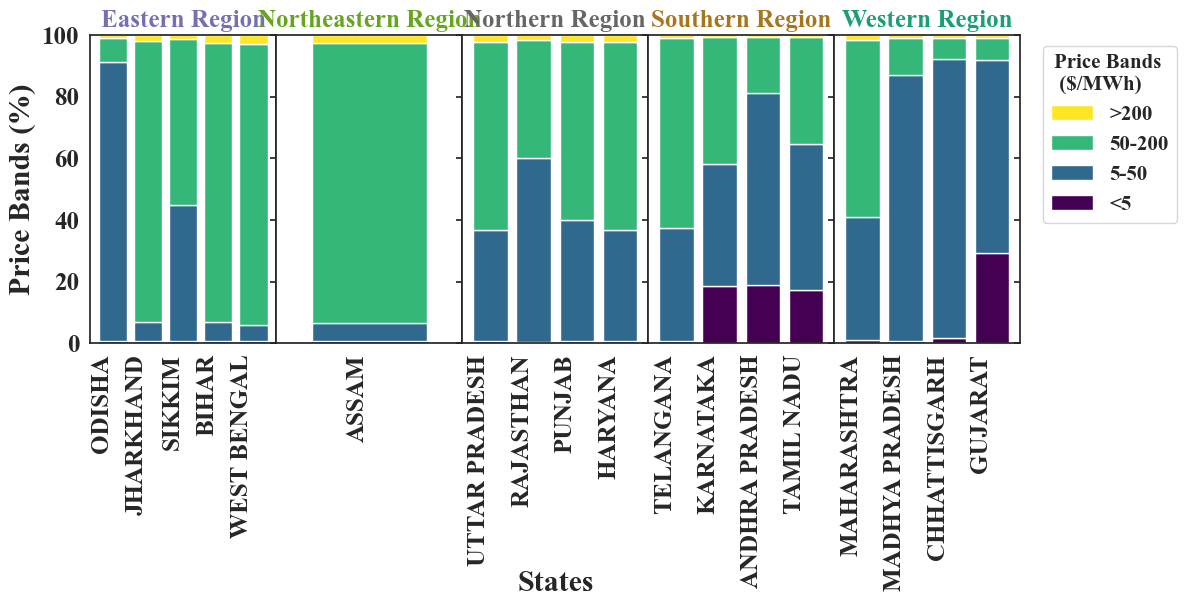

In [ ]:
def plotting_duration(data,ax):

    #iniitalize df
    regional_bands_df = pd.DataFrame()
    regional_top5_df = pd.DataFrame()
    # for each state name in the dataset of the region
    for state_name in list(data.Name):
        #get the price file

        price_file = state_name+'.csv'
        #get the price file dicitonary that maps to the color and names
        price_file_dict = color_map[price_file]
        #read the csv file
        price_df = pd.read_csv(dir+price_file)

        price_bands_df = pd.DataFrame(index=[state_name])
        price_top5_df = pd.DataFrame(index=[state_name])
        #populate price_bands_df
         
        #less than 5
        price_bands_df['<5'] = [len(price_df[price_df.iloc[:,0]<5]) / len(price_df) * 100] 


        #5 to 50
        price_bands_df['5-50']= [len(price_df[(price_df.iloc[:,0]>=5) & (price_df.iloc[:,0]<50)]) / len(price_df) * 100 ]

        #50 to 200
        price_bands_df['50-200']= [len(price_df[(price_df.iloc[:,0]>=50) & (price_df.iloc[:,0]<200)]) / len(price_df) * 100] 

        #greater than 1000
        price_bands_df['>200']= [len(price_df[(price_df.iloc[:,0]>=200)]) / len(price_df) * 100 ]

        #append
        regional_bands_df = regional_bands_df.append(price_bands_df)
        regional_top5_df = regional_top5_df.append(price_top5_df)



    #plot the price bands df
    regional_bands_df.plot(kind='bar',stacked=True,cmap='viridis',ax=ax,legend=False,width=0.8)

    ax.set_title(price_file_dict['label'],color=price_file_dict['color'],fontweight='bold',font="Times New Roman",fontsize=18)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)




plotparams()
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 5, wspace=0)
(ax1, ax2, ax3, ax4, ax5) = gs.subplots( sharey=True)
plt.ylim(0,100)
ax3.set_xlabel('States')
ax1.set_ylabel('Price Bands (%)')
plt.xlim(0)

for state_region in df_lcoe_filtered['state_region'].unique():
    state_region_data = df_lcoe_filtered[df_lcoe_filtered.state_region==state_region]
    if state_region == 'ER':
        plotting_duration(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_duration(data=state_region_data,ax=ax2)
    if state_region == 'NR':
        plotting_duration(data=state_region_data,ax=ax3)
    if state_region == 'SR':
        plotting_duration(data=state_region_data,ax=ax4)
    if state_region == 'WR':
        plotting_duration(data=state_region_data,ax=ax5)

sns.set(style="white")


# font = font_manager.FontProperties(family='Times New Roman',
#                                    weight='bold',
#                                    style='normal', size=12)
handles_legend, labels_legend = ax5.get_legend_handles_labels()
legend =plt.legend(handles_legend[::-1],labels_legend[::-1], loc='upper right',bbox_to_anchor=(1.9, 1),prop=font,title = 'Price Bands \n ($/MWh)')
legend.get_title().set_fontname('Times New Roman') 
legend.get_title().set_fontsize('15') 


#plt.savefig('figures/figures/pricebands',dpi=1000, bbox_inches='tight')
# plt.savefig('figures/figures/pricebands_23',dpi=1000, bbox_inches='tight')

# plt.savefig('figures/figures/pricebands_23.svg',bbox_inches='tight',format='svg')



## 9.7: Figure for duration and LCOE

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_78951/3215732963.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Other'] = data.loc[:,['Pipes and Valves',
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_78951/672566353.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  regional_bands_df = regional_bands_df.append(price_bands_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_78951/672566353.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  regional_top5_df = regional_top5_df.append(price_top5_df)
/var/folders/d2/m883jtg90d

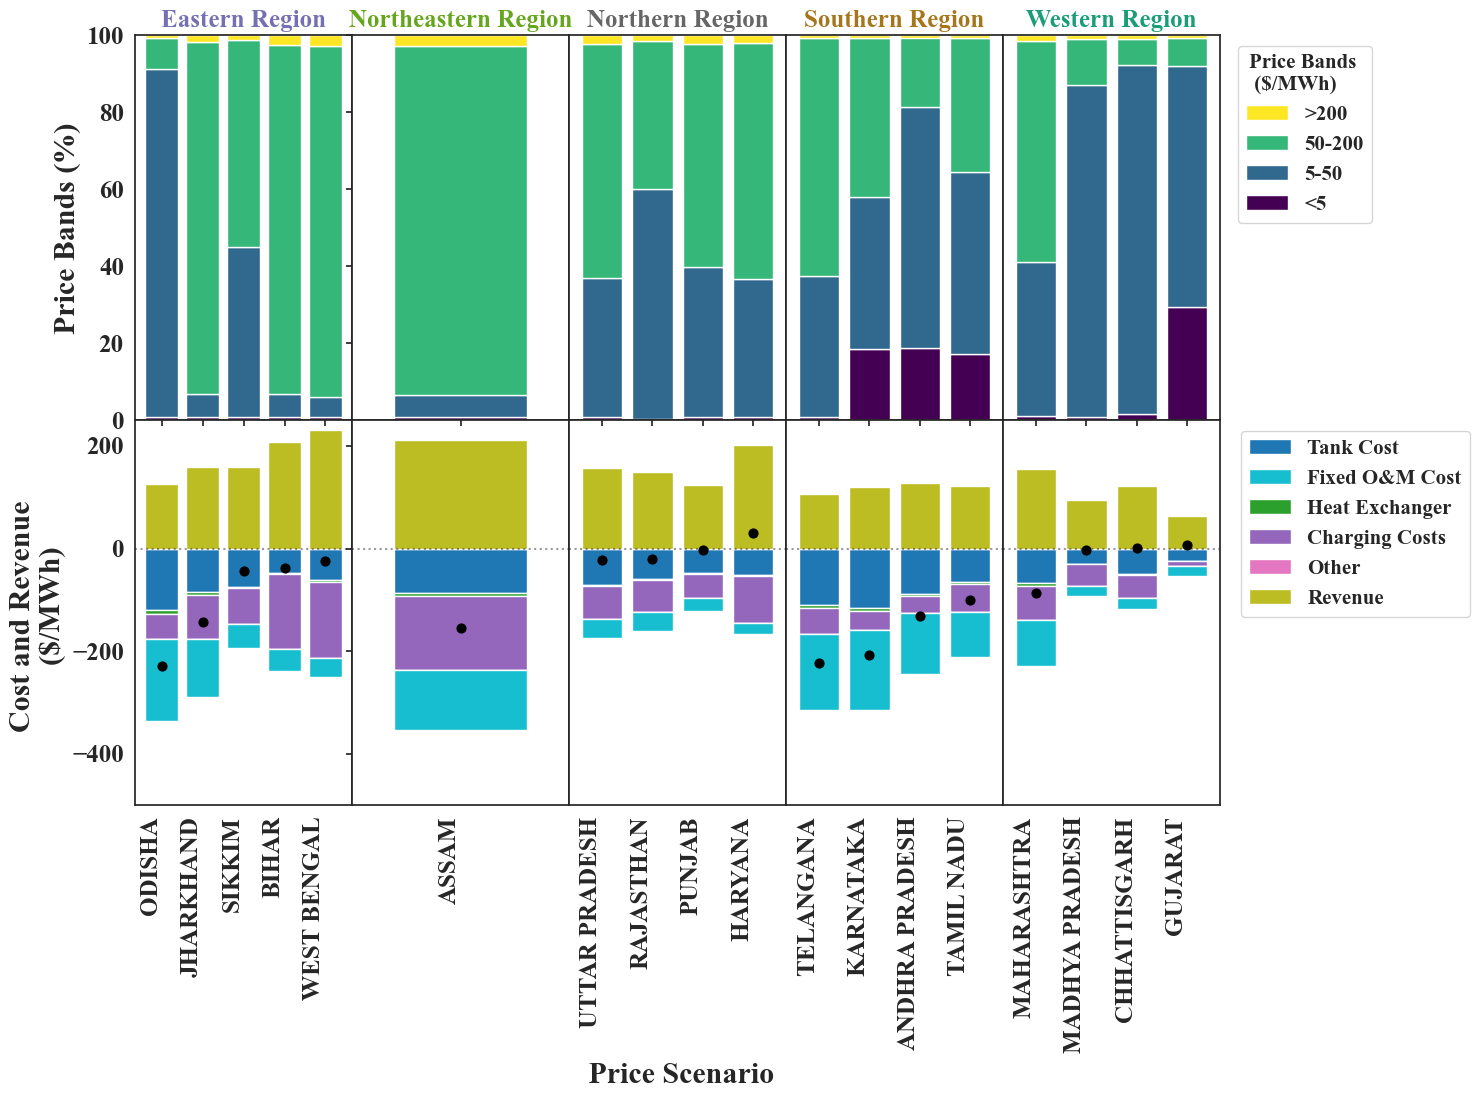

In [ ]:

plotparams()


fig = plt.figure(figsize=(14,10))
gs = fig.add_gridspec(2, 5, wspace=0,hspace=0)
((ax1, ax2, ax3, ax4, ax5),(ax6, ax7, ax8, ax9, ax10)) = gs.subplots()


columns = ['Tank Cost', 'Capital Cost', 'Annualized Capital Cost', 'Profits',
       'Operational Cost', 'Fixed O&M Cost', 'Charging Costs', 'Heat Exchanger',
       'Pipes and Valves', 'Pumps', 'Charger', 'Start-Up Costs',
       'Industrial Electric Heater Costs', 'Revenue', 'Name', 'states',
       'state_region']

df_lcoe_filtered = lcoe_india.loc[:,columns].reset_index(drop=True)

#df_lcoe_filtered['Operational Cost'] = df_lcoe_filtered['Operational Cost']+df_lcoe_filtered['Capital Cost']

for state_region in df_lcoe_filtered['state_region'].unique():
    #if state_region_data Capacity is greater than 0 
    state_region_data = df_lcoe_filtered[df_lcoe_filtered.state_region==state_region]
    if state_region == 'ER':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax6)
        plotting_duration(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax7)
        plotting_duration(data=state_region_data,ax=ax2)
        ax7.yaxis.set_tick_params(labelleft=False)
        ax7.set_yticks([])
        ax7.set_ylabel('')
        ax2.yaxis.set_tick_params(labelleft=False)
        ax2.set_yticks([])
        

    if state_region == 'NR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax8)
        plotting_duration(data=state_region_data,ax=ax3)
        ax8.yaxis.set_tick_params(labelleft=False)
        ax8.set_yticks([])
        ax8.set_ylabel('')
        ax3.yaxis.set_tick_params(labelleft=False)
        ax3.set_yticks([])

    if state_region == 'SR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax9)
        plotting_duration(data=state_region_data,ax=ax4)
        ax9.yaxis.set_tick_params(labelleft=False)
        ax9.set_yticks([])
        ax9.set_ylabel('')
        ax4.yaxis.set_tick_params(labelleft=False)
        ax4.set_yticks([])

    if state_region == 'WR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax10)
        plotting_duration(data=state_region_data,ax=ax5)
        ax10.yaxis.set_tick_params(labelleft=False)
        ax10.set_yticks([])
        ax10.set_ylabel('')
        ax5.yaxis.set_tick_params(labelleft=False)
        ax5.set_yticks([])


handles_legend, labels_legend = ax5.get_legend_handles_labels()
legend = ax5.legend(handles_legend[::-1],labels_legend[::-1], loc='upper right',bbox_to_anchor=(1.75, 1),prop=font,title = 'Price Bands \n ($/MWh)')
legend.get_title().set_fontname('Times New Roman') 
legend.get_title().set_fontsize('15') 
ax1.set_ylabel('Price Bands (%)')

ax6.set_ylabel('Cost and Revenue \n  ($/MWh)')
ax8.set_xlabel('\n Price Scenario')
ax1.set_ylim(0,100)
ax2.set_ylim(0,100)
ax3.set_ylim(0,100)
ax4.set_ylim(0,100)
ax5.set_ylim(0,100)



ax6.set_ylim(-500,250)
ax7.set_ylim(-500,250)
ax8.set_ylim(-500,250)
ax9.set_ylim(-500,250)
ax10.set_ylim(-500,250)

handles_legend, labels_legend = ax10.get_legend_handles_labels()
ax10.legend([handles_legend[0]]+[handles_legend[-1]]+handles_legend[1:-1], [labels_legend[0]]+[labels_legend[-1]]+labels_legend[1:-1], loc='upper right',bbox_to_anchor=(2.2, 1),prop=font)

    #ax.legend(loc='upper right',bbox_to_anchor=(1.3, 1),prop=font)
# plt.ylim(bottom=-500)

plt.savefig('figures/figures/bottomup/price_profiles', bbox_inches='tight',dpi=1000)
# plt.savefig('figures/figures/bottomup/LCOS_priceprofiles.svg',format='svg')




## 9.8: Figures for Dispatch, Capex, Energy Capacity

In [275]:
df_dispatch = pd.read_csv('figures/data/bottomup/DISPATCH.csv')
df_dispatch['states'] = [df_dispatch.loc[i,'Name'].lower().replace(' ','_') .replace('__','_') for i in np.arange(len(df_dispatch))]

df_dispatch_filter = df_dispatch[(df_dispatch['Name']!='CHANDIGARH')&(df_dispatch['Name']!='BANGLADESH') & (df_dispatch['Name']!='NEPAL') 
                    & (df_dispatch['Name']!='BHUTAN') 
                    & (df_dispatch['Name']!='ARUNACHAL PRADESH') 
                    & (df_dispatch['Name']!='DADRA  NAGAR HAVELI') 
                    & (df_dispatch['Name']!='DELHI') 
                    & (df_dispatch['Name']!='GOA') 
                    & (df_dispatch['Name']!='HIMACHAL PRADESH') 
                    & (df_dispatch['Name']!='JAMMU  KASHMIR') 
                    & (df_dispatch['Name']!='KERALA') 
                    & (df_dispatch['Name']!='LADAKH') 
                    & (df_dispatch['Name']!='LAKSHADWEEP') 
                    & (df_dispatch['Name']!='MANIPUR') 
                    & (df_dispatch['Name']!='MEGHALAYA') 
                    & (df_dispatch['Name']!='MIZORAM') 
                    & (df_dispatch['Name']!='NAGALAND') 
                    & (df_dispatch['Name']!='PUDUCHERRY') 
                    & (df_dispatch['Name']!='UTTARAKHAND')
                    & (df_dispatch['Name']!='DAMAN  DIU')
                    & (df_dispatch['Name']!='TRIPURA')]

df_dispatch_filter['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list()[0] for state_name in df_dispatch_filter.states]
df_dispatch_filter['dispatch_gwh'] = df_dispatch_filter['Dispatch']/1000
df_dispatch_filter=pd.merge(df_lcoe_filtered.loc[:,['Profits','Name']],df_dispatch_filter,on='Name')


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/288093447.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dispatch_filter['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list()[0] for state_name in df_dispatch_filter.states]
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/288093447.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dispatch_filter['dispatch_gwh'] = df_dispatch_filter['Dispatch']/1000


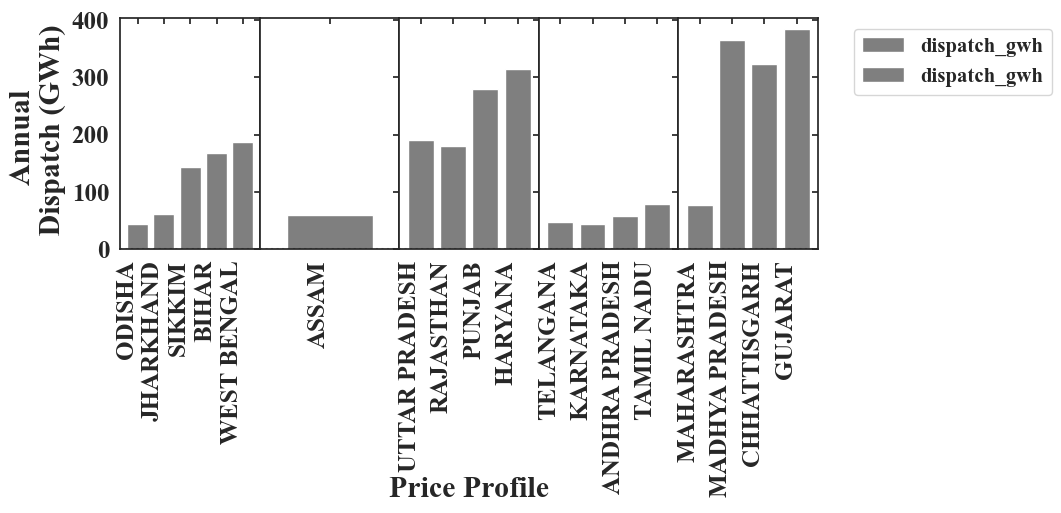

In [276]:
#trying different panels 


plotparams()


fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(1, 5, wspace=0)
(ax1, ax2, ax3, ax4, ax5) = gs.subplots( sharey=True)


def plotting_bottomup_dispatch(data,ax):
    
    columns = [
      'dispatch_gwh','Name'
       ]

    cost_data = data.loc[:,columns]
    cost_data.plot(kind='bar',stacked = True, x = 'Name', color='tab:gray',xlabel=None, legend=False,width=0.8,ax=ax)
    
        
    ax.axhline(y=0,color='black',alpha=0.4,ls=':')
    ax.set_xlabel(None)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)



    

#set plot style
sns.set(style="white")

for state_region in df_dispatch_filter['state_region'].unique():
    #if state_region_data Capacity is greater than 0 
    state_region_data = df_dispatch_filter[df_dispatch_filter.state_region==state_region]
    if state_region == 'ER':
        plotting_bottomup_dispatch(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_bottomup_dispatch(data=state_region_data,ax=ax2)
    if state_region == 'NR':
        plotting_bottomup_dispatch(data=state_region_data,ax=ax3)
    if state_region == 'SR':
        plotting_bottomup_dispatch(data=state_region_data,ax=ax4)
    if state_region == 'WR':
        plotting_bottomup_dispatch(data=state_region_data,ax=ax5)




ax1.set_ylabel('Annual \n Dispatch (GWh)')
ax3.set_xlabel('Price Profile')

handles_legend, labels_legend = ax5.get_legend_handles_labels()
ax5.legend([handles_legend[0]]+[handles_legend[-1]]+handles_legend[1:-1], [labels_legend[0]]+[labels_legend[-1]]+labels_legend[1:-1], loc='upper right',bbox_to_anchor=(2.75, 1),prop=font)


plt.savefig('figures/figures/bottomup/dispatch', bbox_inches='tight',dpi=1000)


In [277]:
df_capex = pd.read_csv('figures/data/bottomup/CAPEX.csv')
df_capex['states'] = [df_capex.loc[i,'Name'].lower().replace(' ','_') .replace('__','_') for i in np.arange(len(df_capex))]

df_capex_filter = df_capex[(df_capex['Name']!='CHANDIGARH')&(df_capex['Name']!='BANGLADESH') & (df_capex['Name']!='NEPAL') 
                    & (df_capex['Name']!='BHUTAN') 
                    & (df_capex['Name']!='ARUNACHAL PRADESH') 
                    & (df_capex['Name']!='DADRA  NAGAR HAVELI') 
                    & (df_capex['Name']!='DELHI') 
                    & (df_capex['Name']!='GOA') 
                    & (df_capex['Name']!='HIMACHAL PRADESH') 
                    & (df_capex['Name']!='JAMMU  KASHMIR') 
                    & (df_capex['Name']!='KERALA') 
                    & (df_capex['Name']!='LADAKH') 
                    & (df_capex['Name']!='LAKSHADWEEP') 
                    & (df_capex['Name']!='MANIPUR') 
                    & (df_capex['Name']!='MEGHALAYA') 
                    & (df_capex['Name']!='MIZORAM') 
                    & (df_capex['Name']!='NAGALAND') 
                    & (df_capex['Name']!='PUDUCHERRY') 
                    & (df_capex['Name']!='UTTARAKHAND')
                    & (df_capex['Name']!='DAMAN  DIU')
                    & (df_capex['Name']!='TRIPURA')]

df_capex_filter['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list()[0] for state_name in df_capex_filter.states]
df_capex_filter=pd.merge(df_lcoe_filtered.loc[:,['Profits','Name']],df_capex_filter,on='Name')


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/967293708.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_capex_filter['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list()[0] for state_name in df_capex_filter.states]


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1792672407.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Other'] = data.loc[:,['Pipes and Valves',
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1792672407.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Other'] = data.loc[:,['Pipes and Valves',
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1792672407.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

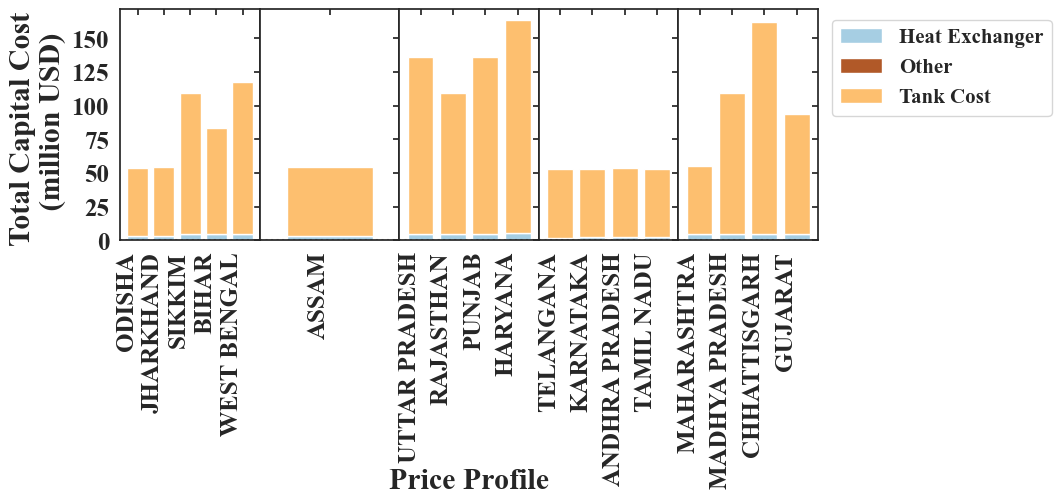

In [278]:

plotparams()


fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(1, 5, wspace=0)
(ax1, ax2, ax3, ax4, ax5) = gs.subplots( sharey=True)


def plotting_bottomup_CAPEX(data,ax):

    data['Other'] = data.loc[:,['Pipes and Valves',
        'Charger', 'Pumps']].sum(axis=0)
    
    columns = [
      'Name','Heat Exchanger','Tank Cost','Other'
       ]
    

    cost_data = data.loc[:,columns]    
    cost_data.loc[:,['Heat Exchanger','Tank Cost','Other']] = cost_data.loc[:,['Heat Exchanger','Tank Cost','Other']]/-1000000

    cost_data.plot(kind='bar',stacked = True, x = 'Name', colormap='Paired',xlabel=None, legend=False,width=0.8,ax=ax)

    ax.axhline(y=0,color='black',alpha=0.4,ls=':')
    ax.set_xlabel(None)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)



    

#set plot style
sns.set(style="white")

for state_region in df_capex_filter['state_region'].unique():
    #if state_region_data Capacity is greater than 0 
    state_region_data = df_capex_filter[df_capex_filter.state_region==state_region]
    if state_region == 'ER':
        plotting_bottomup_CAPEX(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_bottomup_CAPEX(data=state_region_data,ax=ax2)
    if state_region == 'NR':
        plotting_bottomup_CAPEX(data=state_region_data,ax=ax3)
    if state_region == 'SR':
        plotting_bottomup_CAPEX(data=state_region_data,ax=ax4)
    if state_region == 'WR':
        plotting_bottomup_CAPEX(data=state_region_data,ax=ax5)




ax1.set_ylabel('Total Capital Cost \n (million USD)')
ax3.set_xlabel('Price Profile')

handles_legend, labels_legend = ax5.get_legend_handles_labels()
ax5.legend([handles_legend[0]]+[handles_legend[-1]]+handles_legend[1:-1], [labels_legend[0]]+[labels_legend[-1]]+labels_legend[1:-1], loc='upper right',bbox_to_anchor=(2.75, 1),prop=font)
    #ax.legend(loc='upper right',bbox_to_anchor=(1.3, 1),prop=font)


plt.savefig('figures/figures/bottomup/CAPEX_priceprofiles', bbox_inches='tight',dpi=1000)




In [279]:
df_energy_capacity = pd.read_csv('figures/data/bottomup/energy_capacity.csv')
df_energy_capacity['states'] = [df_energy_capacity.loc[i,'Name'].lower().replace(' ','_') .replace('__','_') for i in np.arange(len(df_energy_capacity))]

df_energy_capacity_filter = df_energy_capacity[(df_energy_capacity['Name']!='CHANDIGARH')&(df_energy_capacity['Name']!='BANGLADESH') & (df_energy_capacity['Name']!='NEPAL') 
                    & (df_energy_capacity['Name']!='BHUTAN') 
                    & (df_energy_capacity['Name']!='ARUNACHAL PRADESH') 
                    & (df_energy_capacity['Name']!='DADRA  NAGAR HAVELI') 
                    & (df_energy_capacity['Name']!='DELHI') 
                    & (df_energy_capacity['Name']!='GOA') 
                    & (df_energy_capacity['Name']!='HIMACHAL PRADESH') 
                    & (df_energy_capacity['Name']!='JAMMU  KASHMIR') 
                    & (df_energy_capacity['Name']!='KERALA') 
                    & (df_energy_capacity['Name']!='LADAKH') 
                    & (df_energy_capacity['Name']!='LAKSHADWEEP') 
                    & (df_energy_capacity['Name']!='MANIPUR') 
                    & (df_energy_capacity['Name']!='MEGHALAYA') 
                    & (df_energy_capacity['Name']!='MIZORAM') 
                    & (df_energy_capacity['Name']!='NAGALAND') 
                    & (df_energy_capacity['Name']!='PUDUCHERRY') 
                    & (df_energy_capacity['Name']!='UTTARAKHAND')
                    & (df_energy_capacity['Name']!='DAMAN  DIU')
                    & (df_energy_capacity['Name']!='TRIPURA')]

df_energy_capacity_filter['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list()[0] for state_name in df_energy_capacity_filter.states]
df_energy_capacity_filter=pd.merge(df_lcoe_filtered.loc[:,['Profits','Name']],df_energy_capacity_filter,on='Name')


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/1998574676.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy_capacity_filter['state_region'] = [state_region_df[state_region_df['State']==state_name]['region'].to_list()[0] for state_name in df_energy_capacity_filter.states]


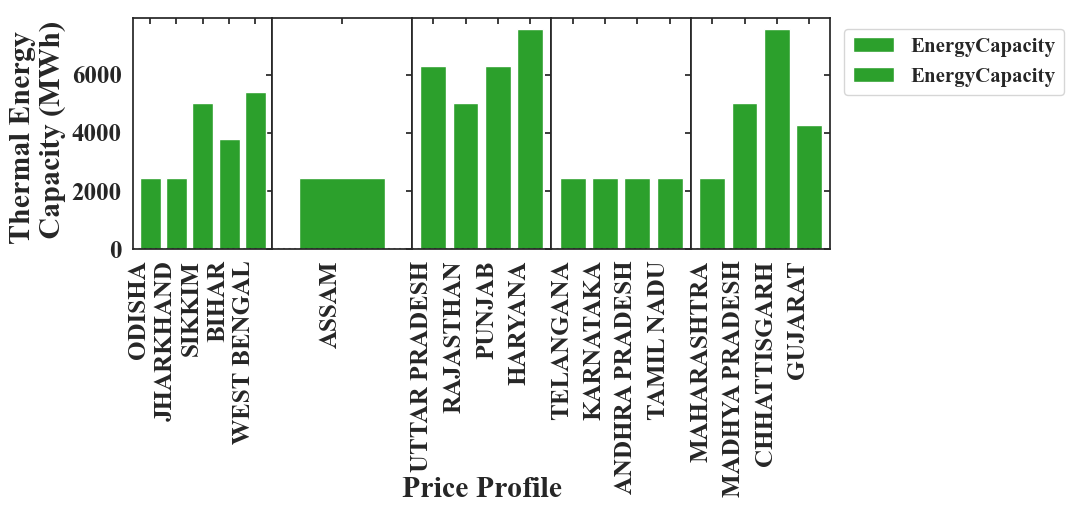

In [280]:
plotparams()


fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(1, 5, wspace=0)
(ax1, ax2, ax3, ax4, ax5) = gs.subplots( sharey=True)


def plotting_bottomup_capacity(data,ax):
    
    columns = [
      'EnergyCapacity','Name'
       ]

    cost_data = data.loc[:,columns]
    cost_data.plot(kind='bar',stacked = True, x = 'Name', color='tab:green',xlabel=None, legend=False,width=0.8,ax=ax)
    
        
    ax.axhline(y=0,color='black',alpha=0.4,ls=':')
    ax.set_xlabel(None)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)

    

#set plot style
sns.set(style="white")

for state_region in df_energy_capacity_filter['state_region'].unique():
    #if state_region_data Capacity is greater than 0 
    state_region_data = df_energy_capacity_filter[df_energy_capacity_filter.state_region==state_region]
    if state_region == 'ER':
        plotting_bottomup_capacity(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_bottomup_capacity(data=state_region_data,ax=ax2)
    if state_region == 'NR':
        plotting_bottomup_capacity(data=state_region_data,ax=ax3)
    if state_region == 'SR':
        plotting_bottomup_capacity(data=state_region_data,ax=ax4)
    if state_region == 'WR':
        plotting_bottomup_capacity(data=state_region_data,ax=ax5)




ax1.set_ylabel('Thermal Energy \n Capacity (MWh)')
ax3.set_xlabel('Price Profile')

handles_legend, labels_legend = ax5.get_legend_handles_labels()
ax5.legend([handles_legend[0]]+[handles_legend[-1]]+handles_legend[1:-1], [labels_legend[0]]+[labels_legend[-1]]+labels_legend[1:-1], loc='upper right',bbox_to_anchor=(2.75, 1),prop=font)


plt.savefig('figures/figures/bottomup/energycapacity', bbox_inches='tight',dpi=1000)


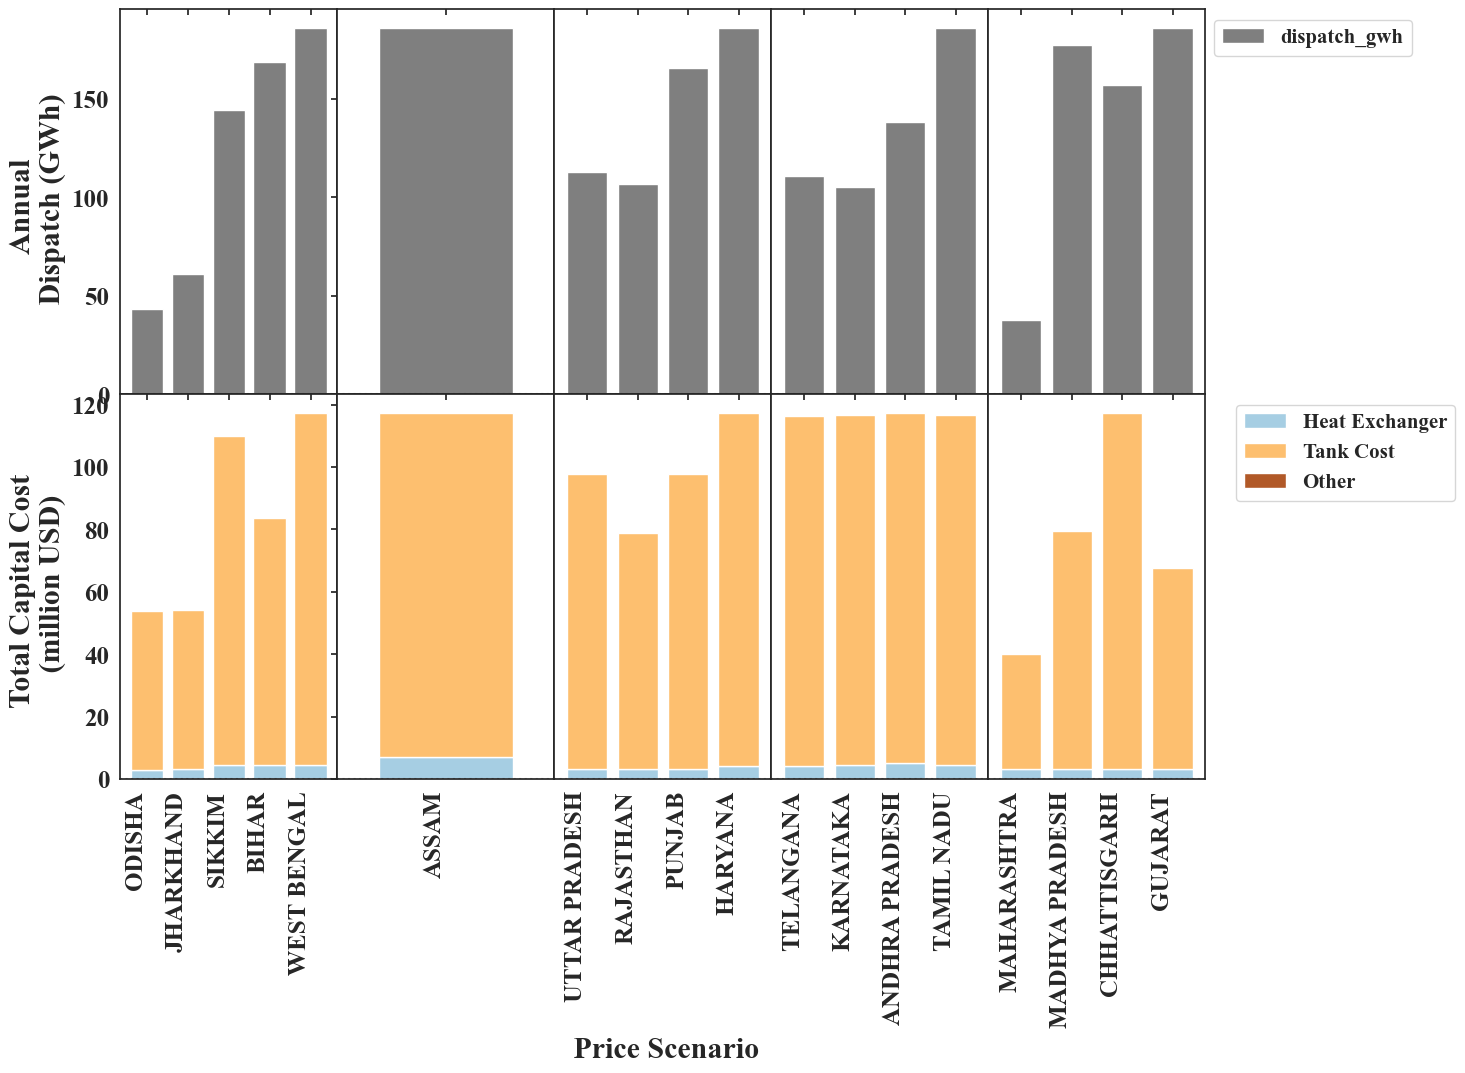

In [281]:
plotparams()



fig = plt.figure(figsize=(14,10))
gs = fig.add_gridspec(2, 5, wspace=0,hspace=0)
((ax1, ax2, ax3, ax4, ax5),(ax6, ax7, ax8, ax9, ax10)) = gs.subplots()


for state_region in df_lcoe_filtered['state_region'].unique():
    #if state_region_data Capacity is greater than 0 
    state_region_dispatch_data = df_dispatch_filter[df_dispatch_filter.state_region==state_region].sort_values('Profits',ascending=True)
    state_region_capex_data = df_capex_filter[df_capex_filter.state_region==state_region].sort_values('Profits',ascending=True)

    if state_region == 'ER':
        plotting_bottomup_CAPEX(data=state_region_capex_data,ax=ax6)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax1)
    if state_region == 'NER':
        plotting_bottomup_CAPEX(data=state_region_capex_data,ax=ax7)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax2)
        ax7.yaxis.set_tick_params(labelleft=False)
        ax7.set_yticks([])
        ax7.set_ylabel('')
        ax2.yaxis.set_tick_params(labelleft=False)
        ax2.set_yticks([])
        

    if state_region == 'NR':
        plotting_bottomup_CAPEX(data=state_region_capex_data,ax=ax8)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax3)
        ax8.yaxis.set_tick_params(labelleft=False)
        ax8.set_yticks([])
        ax8.set_ylabel('')
        ax3.yaxis.set_tick_params(labelleft=False)
        ax3.set_yticks([])

    if state_region == 'SR':
        plotting_bottomup_CAPEX(data=state_region_capex_data,ax=ax9)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax4)
        ax9.yaxis.set_tick_params(labelleft=False)
        ax9.set_yticks([])
        ax9.set_ylabel('')
        ax4.yaxis.set_tick_params(labelleft=False)
        ax4.set_yticks([])

    if state_region == 'WR':
        plotting_bottomup_CAPEX(data=state_region_capex_data,ax=ax10)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax5)
        ax10.yaxis.set_tick_params(labelleft=False)
        ax10.set_yticks([])
        ax10.set_ylabel('')
        ax5.yaxis.set_tick_params(labelleft=False)
        ax5.set_yticks([])


handles_legend, labels_legend = ax5.get_legend_handles_labels()


legend = ax5.legend(handles_legend[::-1],labels_legend[::-1], loc='upper right',bbox_to_anchor=(2, 1),prop=font)
legend.get_title().set_fontname('Times New Roman') 
legend.get_title().set_fontsize('15') 
ax6.set_ylabel('Total Capital Cost \n (million USD)')

ax1.set_ylabel('Annual \n Dispatch (GWh)')
ax8.set_xlabel('\n Price Scenario')


handles_legend, labels_legend = ax10.get_legend_handles_labels()
ax10.legend(loc='upper right',bbox_to_anchor=(2.2, 1),prop=font)


plt.savefig('figures/figures/bottomup/price_profiles_capex_dispatch', bbox_inches='tight',dpi=1000)


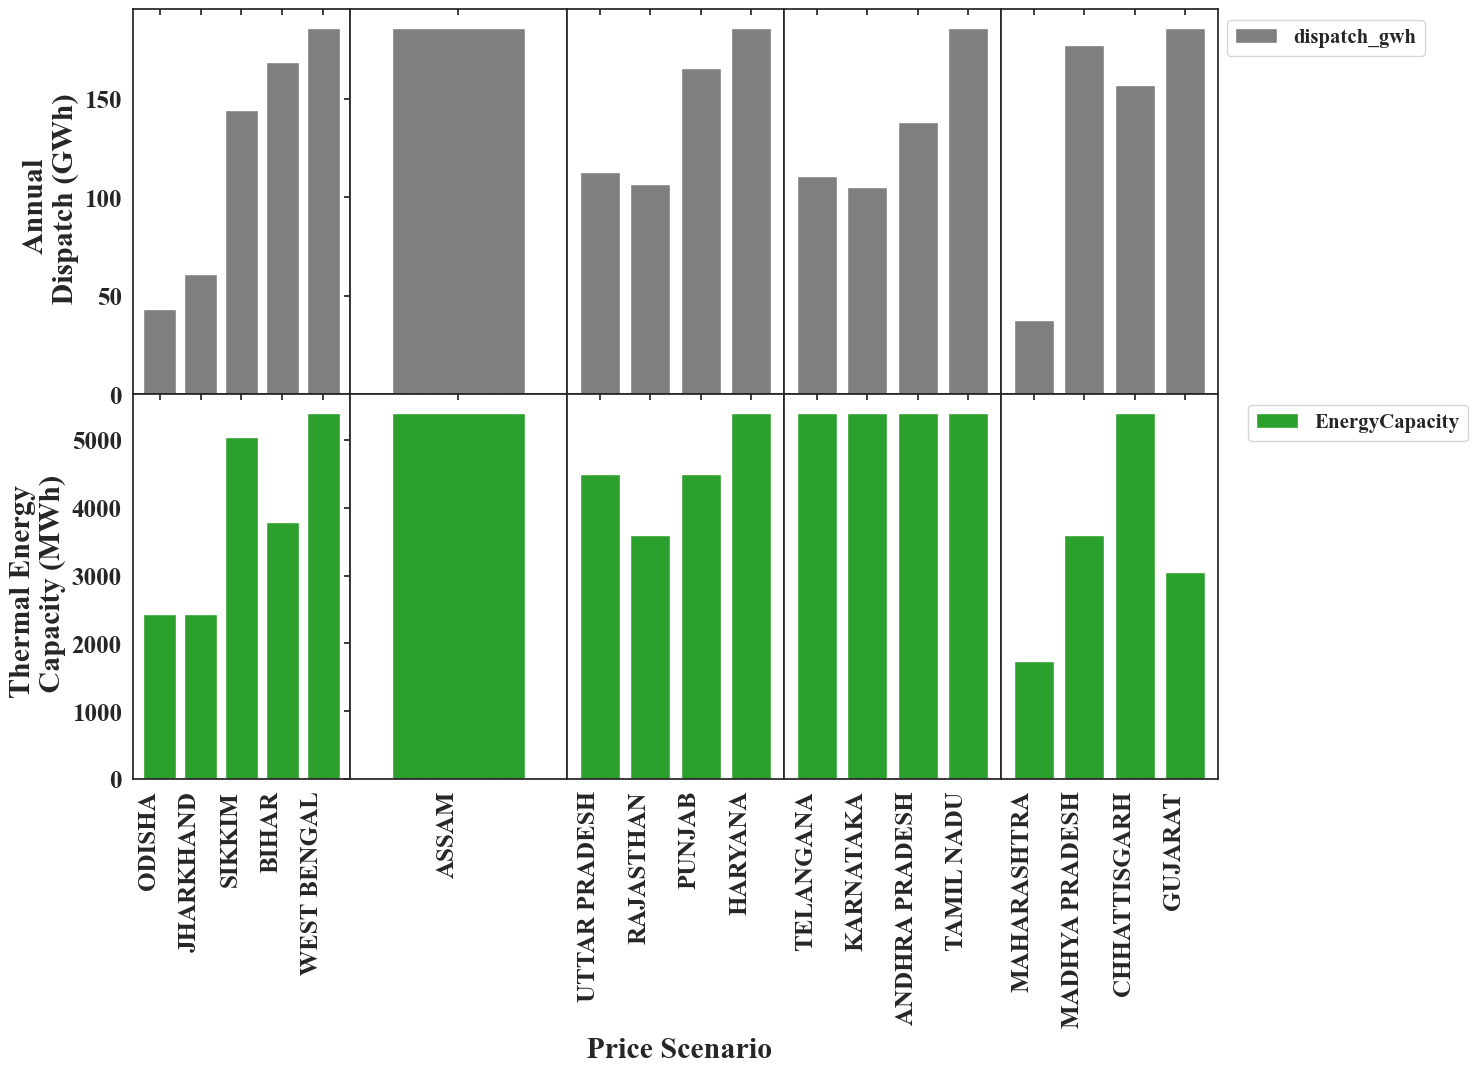

In [282]:

plotparams()

fig = plt.figure(figsize=(14,10))
gs = fig.add_gridspec(2, 5, wspace=0,hspace=0)
((ax1, ax2, ax3, ax4, ax5),(ax6, ax7, ax8, ax9, ax10)) = gs.subplots()


for state_region in df_lcoe_filtered['state_region'].unique():
    #if state_region_data Capacity is greater than 0 
    state_region_dispatch_data = df_dispatch_filter[df_dispatch_filter.state_region==state_region].sort_values('Profits',ascending=True)
    state_region_capex_data = df_energy_capacity_filter[df_energy_capacity_filter.state_region==state_region].sort_values('Profits',ascending=True)

    if state_region == 'ER':
        plotting_bottomup_capacity(data=state_region_capex_data,ax=ax6)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax1)
    if state_region == 'NER':
        plotting_bottomup_capacity(data=state_region_capex_data,ax=ax7)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax2)
        ax7.yaxis.set_tick_params(labelleft=False)
        ax7.set_yticks([])
        ax7.set_ylabel('')
        ax2.yaxis.set_tick_params(labelleft=False)
        ax2.set_yticks([])
        

    if state_region == 'NR':
        plotting_bottomup_capacity(data=state_region_capex_data,ax=ax8)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax3)
        ax8.yaxis.set_tick_params(labelleft=False)
        ax8.set_yticks([])
        ax8.set_ylabel('')
        ax3.yaxis.set_tick_params(labelleft=False)
        ax3.set_yticks([])

    if state_region == 'SR':
        plotting_bottomup_capacity(data=state_region_capex_data,ax=ax9)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax4)
        ax9.yaxis.set_tick_params(labelleft=False)
        ax9.set_yticks([])
        ax9.set_ylabel('')
        ax4.yaxis.set_tick_params(labelleft=False)
        ax4.set_yticks([])

    if state_region == 'WR':
        plotting_bottomup_capacity(data=state_region_capex_data,ax=ax10)
        plotting_bottomup_dispatch(data=state_region_dispatch_data,ax=ax5)
        ax10.yaxis.set_tick_params(labelleft=False)
        ax10.set_yticks([])
        ax10.set_ylabel('')
        ax5.yaxis.set_tick_params(labelleft=False)
        ax5.set_yticks([])


handles_legend, labels_legend = ax5.get_legend_handles_labels()


legend = ax5.legend(handles_legend[::-1],labels_legend[::-1], loc='upper right',bbox_to_anchor=(2, 1),prop=font)
legend.get_title().set_fontname('Times New Roman') 
legend.get_title().set_fontsize('15') 
ax6.set_ylabel('Thermal Energy \n Capacity (MWh)')

ax1.set_ylabel('Annual \n Dispatch (GWh)')
ax8.set_xlabel('\n Price Scenario')

handles_legend, labels_legend = ax10.get_legend_handles_labels()
ax10.legend(loc='upper right',bbox_to_anchor=(2.2, 1),prop=font)


plt.savefig('figures/figures/bottomup/price_profiles_capacity_dispatch', bbox_inches='tight',dpi=1000)




/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3452634567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Other'] = data.loc[:,['Pipes and Valves',
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3452634567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Other'] = data.loc[:,['Pipes and Valves',
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/3452634567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

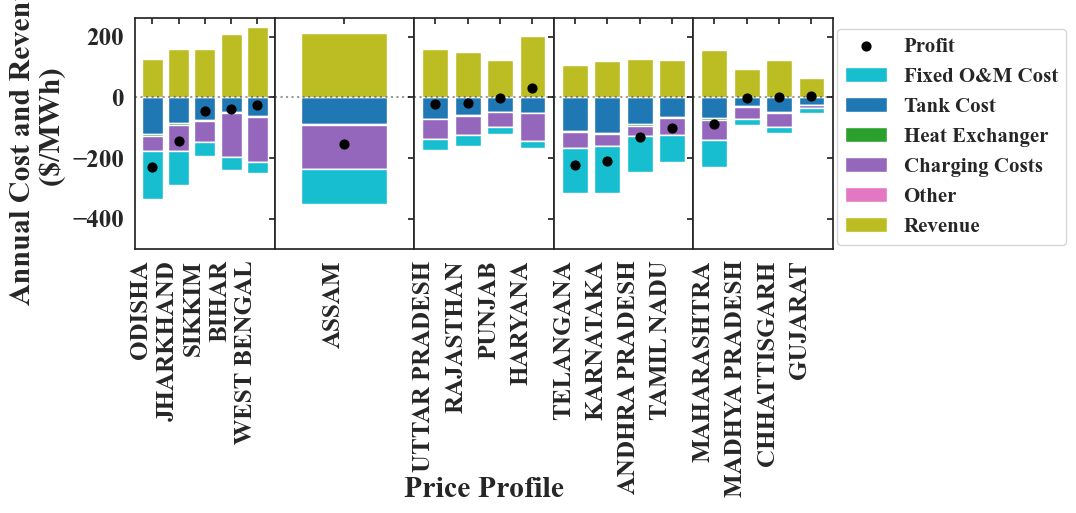

In [283]:

plotparams()


fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(1, 5, wspace=0)
(ax1, ax2, ax3, ax4, ax5) = gs.subplots( sharey=True)


def plotting_bottomup_CAPEX(data,ax):

    data['Other'] = data.loc[:,['Pipes and Valves',
        'Charger', 'Pumps','Start-Up Costs']].sum(axis=0)
    
    columns = [
      'Tank Cost','Heat Exchanger',
       'Charging Costs','Other',
       'Revenue', 'Fixed O&M Cost','Name'
       ]

    cost_data = data.loc[:,columns]
    cost_data.plot(kind='bar',stacked = True, x = 'Name', colormap='tab10',xlabel=None, legend=False,width=0.8,ax=ax)
    
    if ax==ax5:
        label='Profit'
    else:
        label=None
    data.plot(kind='scatter',x = 'Name', y = 'Profits',color= 'black',xlabel = None,label=label, ax=ax,s=40)
    ax.axhline(y=0,color='black',alpha=0.4,ls=':')
    ax.set_xlabel(None)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)



    

#set plot style
sns.set(style="white")


columns = ['Tank Cost', 'Capital Cost', 'Annualized Capital Cost', 'Profits',
       'Operational Cost', 'Fixed O&M Cost', 'Charging Costs', 'Heat Exchanger',
       'Pipes and Valves', 'Pumps', 'Charger', 'Start-Up Costs',
       'Industrial Electric Heater Costs', 'Revenue', 'Name', 'states',
       'state_region']

df_lcoe_filtered = lcoe_india.loc[:,columns].reset_index(drop=True)


for state_region in df_lcoe_filtered['state_region'].unique():
    #if state_region_data Capacity is greater than 0 
    state_region_data = df_lcoe_filtered[df_lcoe_filtered.state_region==state_region]
    if state_region == 'ER':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax2)
    if state_region == 'NR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax3)
    if state_region == 'SR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax4)
    if state_region == 'WR':
        plotting_bottomup_LCOE(data=state_region_data,ax=ax5)




ax1.set_ylabel('Annual Cost and Revenue \n  ($/MWh)')
ax3.set_xlabel('Price Profile')

handles_legend, labels_legend = ax5.get_legend_handles_labels()
ax5.legend([handles_legend[0]]+[handles_legend[-1]]+handles_legend[1:-1], [labels_legend[0]]+[labels_legend[-1]]+labels_legend[1:-1], loc='upper right',bbox_to_anchor=(2.75, 1),prop=font)
plt.ylim(bottom=-500)

plt.savefig('figures/figures/bottomup/LCOS_priceprofiles', bbox_inches='tight',dpi=1000)


In [295]:
dir = 'data/NREL_2030_fullyear_profiles/'

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2557966049.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  regional_bands_df = regional_bands_df.append(price_bands_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2557966049.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  regional_top5_df = regional_top5_df.append(price_top5_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2557966049.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  regional_bands_df = regional_bands_df.append(price_bands_df)
/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_97529/2557966049.py:36: FutureWarning: The frame.append method is deprecated and will be removed from panda

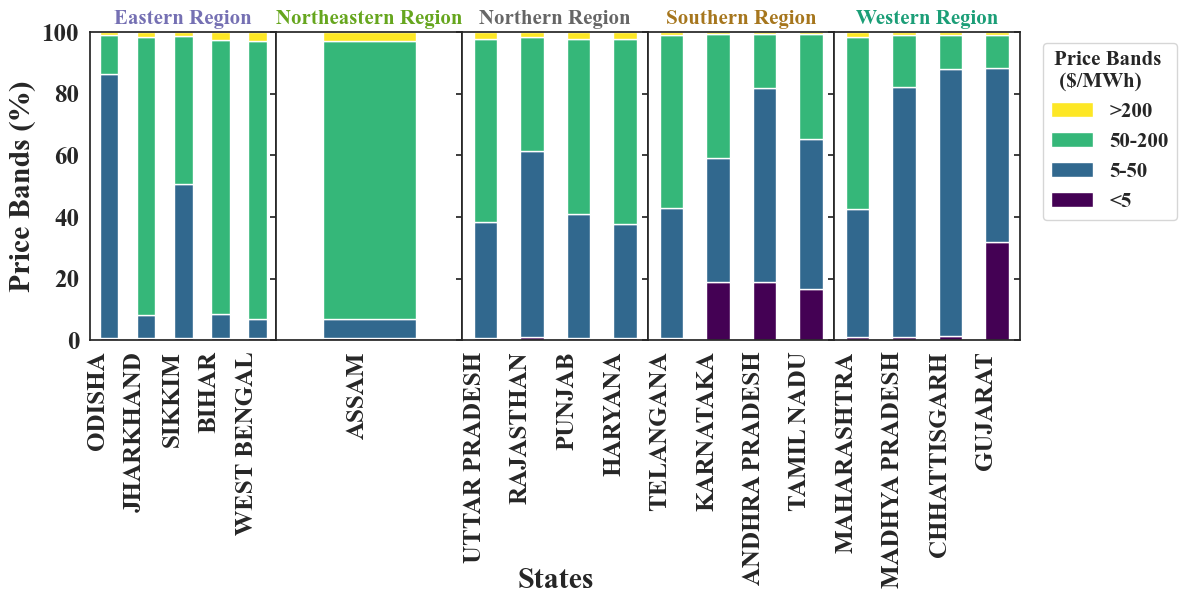

In [296]:
def plotting_duration(data,ax):
    plotparams()

    #iniitalize df
    regional_bands_df = pd.DataFrame()
    regional_top5_df = pd.DataFrame()
    # for each state name in the dataset of the region
    for state_name in list(data.Name):
        #get the price file

        price_file = state_name+'.csv'
        #get the price file dicitonary that maps to the color and names
        price_file_dict = color_map[price_file]
        #read the csv file
        price_df = pd.read_csv(dir+price_file)

        price_bands_df = pd.DataFrame(index=[state_name])
        price_top5_df = pd.DataFrame(index=[state_name])
        #populate price_bands_df
         
        #less than 5
        price_bands_df['<5'] = [len(price_df[price_df.Value<5]) / len(price_df) * 100] 


        #5 to 50
        price_bands_df['5-50']= [len(price_df[(price_df.Value>=5) & (price_df.Value<50)]) / len(price_df) * 100 ]

        #50 to 200
        price_bands_df['50-200']= [len(price_df[(price_df.Value>=50) & (price_df.Value<200)]) / len(price_df) * 100] 

        #greater than 1000
        price_bands_df['>200']= [len(price_df[(price_df.Value>=200)]) / len(price_df) * 100 ]

        #append
        regional_bands_df = regional_bands_df.append(price_bands_df)
        regional_top5_df = regional_top5_df.append(price_top5_df)



    #plot the price bands df
    regional_bands_df.plot(kind='bar',stacked=True,cmap='viridis',ax=ax,legend=False)

    ax.set_title(price_file_dict['label'],color=price_file_dict['color'],fontweight='bold',font="Times New Roman")
    plt.setp(ax.get_xticklabels(), ha="right", rotation=90)




plotparams()

fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 5, wspace=0)
(ax1, ax2, ax3, ax4, ax5) = gs.subplots( sharey=True)
plt.ylim(0,100)
ax3.set_xlabel('States')
ax1.set_ylabel('Price Bands (%)')
plt.xlim(0)

for state_region in df_lcoe_filtered['state_region'].unique():
    state_region_data = df_lcoe_filtered[df_lcoe_filtered.state_region==state_region]
    if state_region == 'ER':
        plotting_duration(data=state_region_data,ax=ax1)
    if state_region == 'NER':
        plotting_duration(data=state_region_data,ax=ax2)
    if state_region == 'NR':
        plotting_duration(data=state_region_data,ax=ax3)
    if state_region == 'SR':
        plotting_duration(data=state_region_data,ax=ax4)
    if state_region == 'WR':
        plotting_duration(data=state_region_data,ax=ax5)

handles_legend, labels_legend = ax5.get_legend_handles_labels()
legend =plt.legend(handles_legend[::-1],labels_legend[::-1], loc='upper right',bbox_to_anchor=(1.9, 1),prop=font,title = 'Price Bands \n ($/MWh)')
legend.get_title().set_fontname('Times New Roman')
legend.get_title().set_fontsize('15')


#plt.savefig('figures/figures/pricebands',dpi=1000, bbox_inches='tight')
plt.savefig('figures/figures/bottomup/pricebands',dpi=1000, bbox_inches='tight')



<Figure size 2000x1600 with 0 Axes>

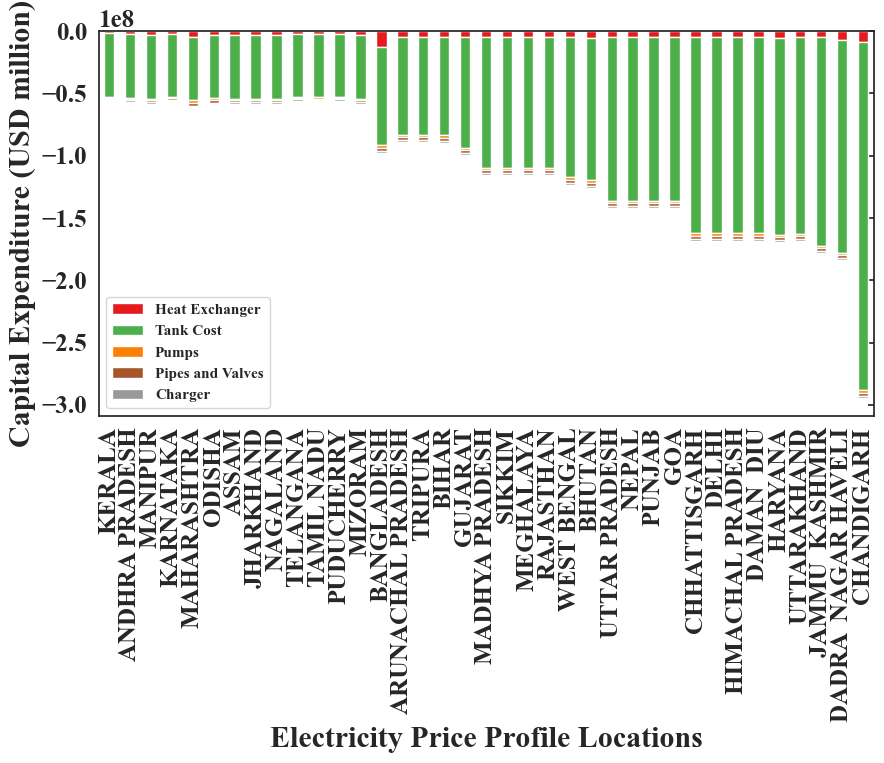

In [297]:
#capex stacked bars
plotparams()
 
df_capex=pd.read_csv('figures/data/bottomup/CAPEX.csv').sort_values('Tank Cost',ascending=False)


plt.figure(figsize=(20,16))
df_capex.loc[:,['Name','Heat Exchanger','Tank Cost', 'Pumps', 'Pipes and Valves', 'Charger']].plot(kind='bar',x = 'Name', stacked = True, colormap='Set1',figsize=(10,5))

plt.ylabel('Capital Expenditure (USD million)')
plt.xlabel('Electricity Price Profile Locations')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend()


## 9.9: Duration

<Axes: >

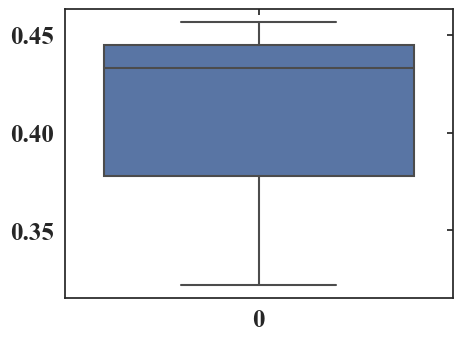

In [298]:
#percentage of capital cost is the total costs
df=pd.DataFrame(bottomup_min_hours_dict[2]).T

#profitable scenarios 
df_1 = df[df['objective_value']<0]

#get indices of the filtered ones (the ones we are analyzing)
indices = []
for name in df_lcoe_filtered.Name: 
    for i_name in df_1.index:
        if name in i_name: 
            indices.append(i_name)

df_2 = df_1.loc[indices]
percentage_capex=df_2['TES_LCOE_Capex']/df_2['TES_LCOE_total'] 
sns.boxplot(data=percentage_capex)



# 10. Representative Optimization Outputs of dispatch / energy arbitrage

In [299]:
base_age_dir = 'RESULTS/base_age/'
base_age_dir_index = 40

base_age_scenarios_dict = create_sensitivity_dict(base_age_dir)

#set download paths
base_age_path_data_download = 'figures/data/base_age/'
base_age_path_figures_download  = 'figures/figures/base_age/'


40.0
39.0
41.0
42.0
46.0
45.0
37.0
43.0
49.0
50.0
44.0
38.0
28.0
27.0
25.0
26.0
24.0
23.0
33.0
47.0
48.0
34.0
36.0
35.0
31.0
32.0
30.0
29.0


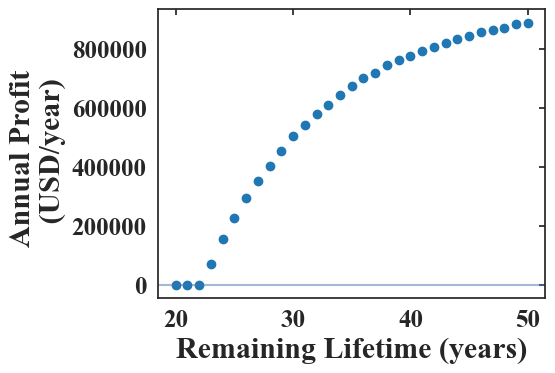

In [300]:
plotparams()

for key in base_age_scenarios_dict.keys(): 
    plt.scatter(base_age_scenarios_dict[key]['lifetime'],base_age_scenarios_dict[key]['objective_value']*-1000,color='tab:blue')

    if base_age_scenarios_dict[key]['objective_value'] < -1:
        print(base_age_scenarios_dict[key]['lifetime'])

plt.ylabel('Annual Profit \n (USD/year)')
plt.xlabel('Remaining Lifetime (years)')
plt.axhline(y=0,alpha=0.5)

plt.savefig(base_age_path_figures_download+'age_SI')
# plt.axvline(x=22)

In [301]:
#set your base age
key25 = 'bayU5_25.csv'
dict25 = base_age_scenarios_dict[key25]
rep_week = 7 #randomly chosen
state_ind = 2#17 #for UP

In [302]:
T=int(T)
# call on fn_map correctly  
fn_map = dict25['fn_map']

#for 1 to 52 (each of the weeks)
SOC_array = []
Li_array = []

alpha_hot = 0.00041666666 #change this

#for each week in the year 
for week in np.arange(52):
    ## TO DO: simulation
    #n is the representative week that it maps to 
    n = fn_map[week]

    #get charging and discharging, cp, Thot-Tcold, and alpha (self discharge) from the associated rep week: 
    flowSalt_charge_n_t = dict25['flowSalt_charge_t'][n]
    flowSalt_discharge_n_t = dict25['flowSalt_discharge_t'][n]

    #get charging and discharging for Li-in
    a_ch_n_t = dict25['Li_net_charge_t'][n]
    a_dis_n_t = dict25['Li_net_discharge_t'][n]
            

    #define SOC week
    SOC_week = np.zeros(T)
    Li_SOC_week = np.zeros(T)


    #set the first value
    Q_w = dict25['Q'][week] 

    SOC_week[0] = Q_w + (flowSalt_charge_n_t[0] - flowSalt_discharge_n_t[0])*cp*(dict25['deltaT_salt'])
            #SOC_week[0] = Q_w + new_dict['tank_energy_t'][n][0]
            
    #set the rest of values: 
    for i in np.arange(1,T): 
        SOC_week[i] = (flowSalt_charge_n_t[i] - flowSalt_discharge_n_t[i])*cp*(dict25['deltaT_salt']) + (1-alpha_hot)*SOC_week[i-1]
        #SOC_week[i] = new_dict['tank_energy_t'][n][i] + (1-alpha_hot)*SOC_week[i-1]
        #Li_SOC_week[i] = 

               

    SOC_array = SOC_array + list(SOC_week / dict25["tank_energy_max"])



## 10.1: Figures

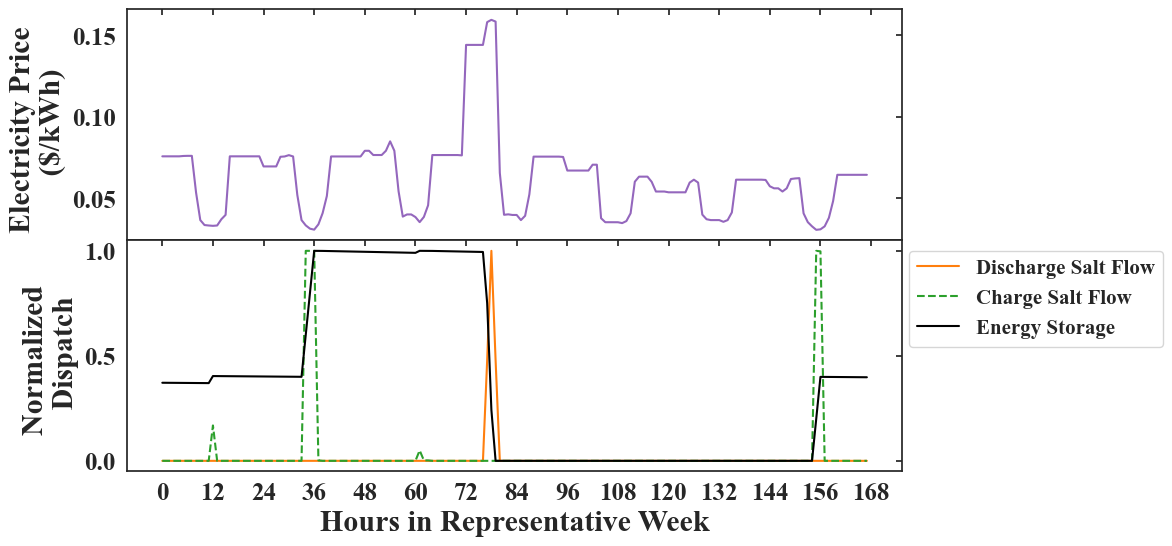

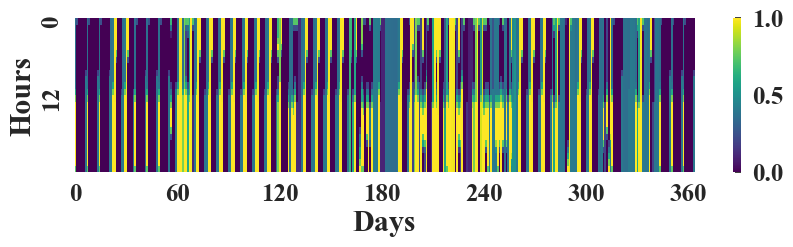

In [303]:
#plot the figures
plotparams()
fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2,1, hspace=0)
(ax1,ax2) = gs.subplots( sharex=True)


ax1.plot(dict25['cost_energy_t'][rep_week],label='Electricity Price ($/kWh)',color='tab:purple')
ax1.set_ylabel('Electricity Price \n ($/kWh)') 
ax1.tick_params(axis='both')

def abs_max(x):
    y = abs(max(x))
    return y

flow_d = dict25['flowSalt_discharge_t'].loc[:,rep_week]/abs_max(dict25['flowSalt_discharge_t'].loc[:,rep_week])
ax2.plot(flow_d,label='Discharge Salt Flow',color='tab:orange')

flow_c = dict25['flowSalt_charge_t'].loc[:,rep_week]/abs_max(dict25['flowSalt_charge_t'].loc[:,rep_week])
ax2.plot(flow_c,label='Charge Salt Flow',color='tab:green',linestyle='dashed')

ax2.set_ylabel('Normalized \n Dispatch')
ax2.set_xlabel('Hours in Representative Week')
handles, labels = plt.gca().get_legend_handles_labels()

tank_e = dict25['tank_energy_t'].loc[:,rep_week]/1000/abs_max(dict25['tank_energy_t'].loc[:,rep_week]/1000)
ax2.plot(tank_e,label = 'Energy Storage',color='black')
ax2.set_xlabel('Hours in Representative Week')
ax2.xaxis.set_ticks(np.arange(0, 168+12, 12))

handles2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles2,loc='upper right', bbox_to_anchor=(1.35, 1),prop=font)
plt.savefig('figures/figures/base_age/representative_dispatch_week.svg',format='svg')
plt.savefig('figures/figures/base_age/representative_dispatch_week')

#SOC heat map 
plt.figure(figsize = (10,2))
im=sns.heatmap(pd.DataFrame(np.array(SOC_array).reshape((364,24))).T,yticklabels=12,xticklabels=60,cmap='viridis',vmin=0,vmax=1)


plt.xlabel('Days')
plt.ylabel('Hours')
plt.savefig('figures/figures/base_age/representative_figs', bbox_inches='tight',dpi=1000)


In [304]:
print('lifetime: ', dict25['lifetime'])
#sizes 
print('Thermal Storage Cap: ', dict25['tank_energy_max'])
print('Discharge Capacity:  ', dict25['powerPeak'])
print('Turbine Capacity:  ', dict25['powerTurbine'])
print('min hours', dict25['min_hours'])


print('Charger Capacity:   ', dict25['flowSalt_charge_peak']*cp*deltaT_salt/0.95) 

print('Heat Exchanger Area:   ', dict25['UA_1'])
print('Heat Exchanger Area:   ', dict25['UA_2'])
print('Heat Exchanger Area:   ', dict25['UA_3'])

print('hot Salt Pump Size: ', dict25['P_hotpump'])
print('cold Salt Pump Size: ', dict25['P_coldpump'])
print('charge salt peak', dict25['flowSalt_charge_peak'])
print('discharge salt peak', dict25['flowSalt_discharge_peak'])

print('LCOS_Li', dict25['Li_LCOE_total'])
print('LCOS_TES', dict25['TES_LCOE_total']) 
print('TES_duration', dict25['TES_duration'])
print('coal objective', dict25['coal_objective'])
print('Li-ion size', dict25['capE_Li'])
print('TES Capex', dict25['CAPEX_TES_total'])
print('Annualized CAPEX', dict25['TES_annualized_capex'])
print('FOM', dict25['TES_fom_yr'])

print('TES_dispatch', dict25['TES_dispatch'])


print('CRF', dict25['CRF'])

print('objective value', dict25['objective_value'])


lifetime:  25.0
Thermal Storage Cap:  2371.998523330556
Discharge Capacity:   500.0
Turbine Capacity:   515.4639175257732
min hours 0.0
Charger Capacity:    499.7844237278104
Heat Exchanger Area:    5.259393990750662
Heat Exchanger Area:    2.822888017147811
Heat Exchanger Area:    3.8997531905079246
hot Salt Pump Size:  548.1709166302306
cold Salt Pump Size:  215.57627218973101
charge salt peak 1.0987577583574466
discharge salt peak 2.909444291252505
LCOS_Li 0
LCOS_TES 0.23896855264281053
TES_duration 1.886687625457124
coal objective 0.0
Li-ion size 0.0
TES Capex 59840.43841869162
Annualized CAPEX 6091.756631022807
FOM 6946.407233364936
TES_dispatch 77786.60186968902
CRF 0.1018
objective value -227.81984145536808


# 11. Boxplots of duration

In [305]:
durations_dict = {'UP': durations_UP,
                             'bottomup': durations_bottomup,
                             'industry': durations_industrial,
                             'temp_eff': durations_temp_eff,
                             'storage': durations_storage}

durations_profitable_dict = {'UP': durations_UP_profitable,
                             'bottomup': durations_bottomup_profitable,
                             'industry': durations_industrial,
                             'temp_eff': durations_temp_eff_profitable,
                             'storage': durations_storage_profitable}

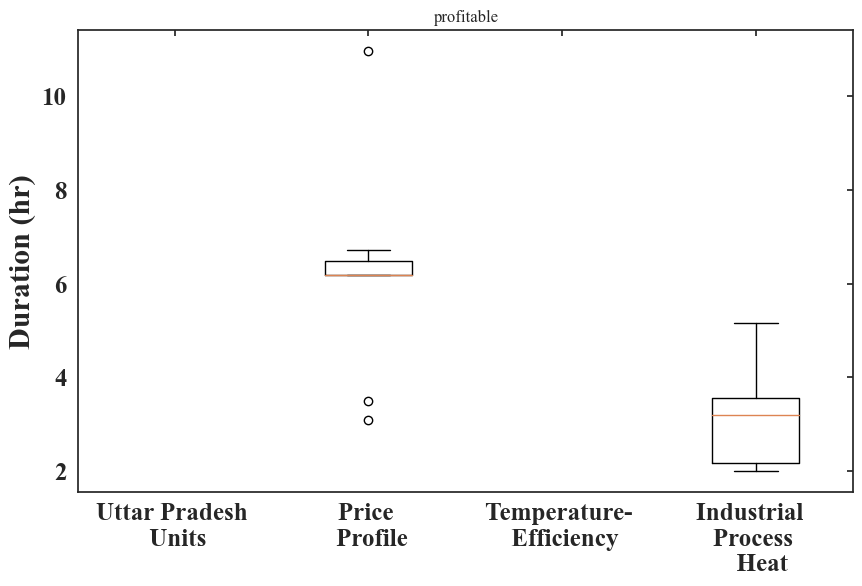

In [306]:
plotparams()
plt.figure(figsize=(10,6))
plt.boxplot([durations_UP_profitable,durations_bottomup_profitable,durations_temp_eff_profitable,durations_industrial],
            labels = ['Uttar Pradesh \n Units','Price \n Profile','Temperature- \n Efficiency','Industrial  \nProcess \n  Heat']);
plt.ylabel('Duration (hr)')
plt.title('profitable')

plt.savefig('figures/figures/durations_boxplot',bbox_inches='tight',dpi=1000)

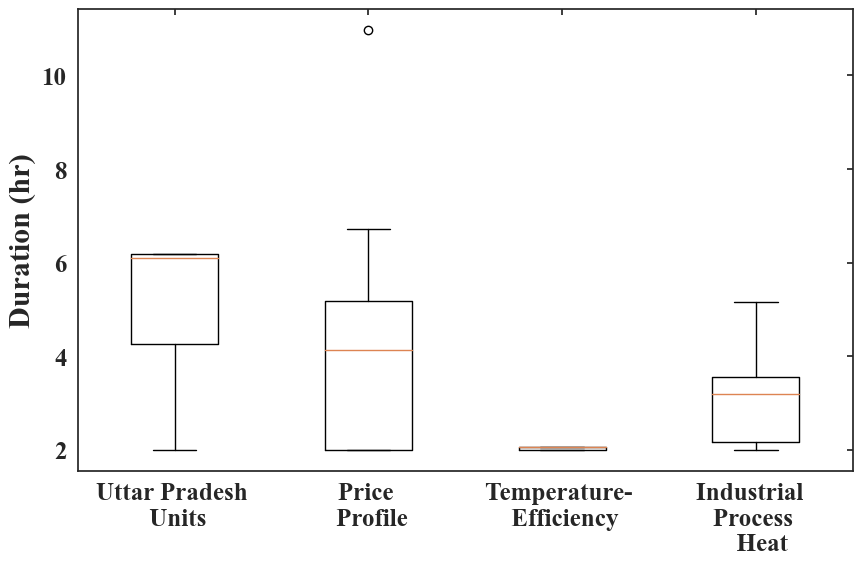

In [307]:
plotparams()
plt.figure(figsize=(10,6))
plt.boxplot([durations_UP,durations_bottomup,durations_temp_eff,durations_industrial],
            labels = ['Uttar Pradesh \n Units','Price \n Profile','Temperature- \n Efficiency','Industrial  \nProcess \n  Heat']);
plt.ylabel('Duration (hr)')

plt.savefig('figures/figures/durations_boxplot',bbox_inches='tight',dpi=1000)

## fin
